
=== Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/ ===


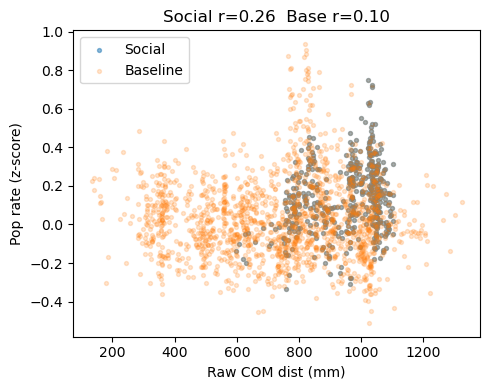

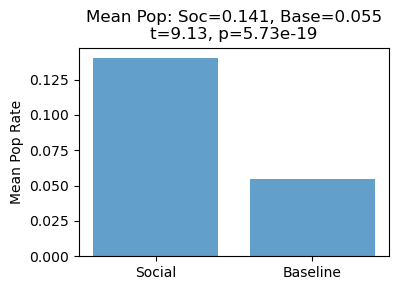

  window        r            p  mean_pop    n
  social 0.255051 2.355798e-08  0.140527  466
baseline 0.098442 9.508282e-06  0.054947 2016


In [5]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. 排除字典 & 加载HDF5 的函数
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. 处理神经元信号：排除 & z-score
# ----------------------------------------------------------------------------
def process_neuron_activity(
    df,
    exclude_dict=None,
    manual_exclude_indices=None,
    apply_exclusion=True
):
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        else:
            if 'session_path' not in df.columns:
                excluded = []
            else:
                session_path = df['session_path'].iloc[0]
                excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        return np.empty((0, df.shape[0])), [], df.reset_index()

    activity = df[neuron_cols].values.T   # (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]           # (n_kept_neurons, n_frames)
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    return normalized, filtered_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 3. 计算 COM 距离（不平滑版本）
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    直接用 df_new 中最基础的 com0/com1 三坐标来算未经平滑的距离。
    返回一个 NumPy 数组 dist_raw，长度 = n_frames。
    """
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    if len(com_prefixes) < 2:
        raise ValueError("至少需要两个 com 前缀来计算距离。")
    p1, p2 = com_prefixes[0], com_prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    dist_raw = np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)
    return dist_raw

# ----------------------------------------------------------------------------
# 4. 极度粗略的“社交 vs 非社交”比较函数
# ----------------------------------------------------------------------------
def rough_social_vs_baseline(
    rec_path,
    social_start_s,
    social_end_s,
    exclude_dict=None,
    baseline_mode='whole',
    baseline_ranges_s=None
):
    """
    对齐不做极限要求，只用“秒”为单位指定社交区间，进行粗略比较。

    Parameters
    ----------
    rec_path : str
      会话根文件夹路径，内部会加载 MIR_Aligned/*.h5 得到 DataFrame。
    social_start_s : float
      社交时段开始时间，单位秒（如 41.0 表示 00:41）。
    social_end_s : float
      社交时段结束时间，单位秒（如 88.0 表示 01:28）。
    exclude_dict : dict or None
      神经元排除字典。
    baseline_mode : str, 'whole' or 'outside'
      - 'whole'：baseline = 整个会话。
      - 'outside'：baseline = 社交段以外的所有时段，需要提供 `baseline_ranges_s`。
    baseline_ranges_s : list of (start_s,end_s) tuples
      只有当 baseline_mode=='outside' 时才需要，比如 [(0,40),(89,120)]，以秒为单位。
    """
    # 1. Load & preprocess
    df = load_session_data(rec_path)
    if 'timestamp_ms_mini' not in df.columns:
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        else:
            raise KeyError("DataFrame 中缺少 'timestamp_ms_mini' 列或索引。")

    # 转换时间戳到秒
    t_ms = df['timestamp_ms_mini'].values
    t_s = t_ms / 1000.0

    # 2. Process neural activity
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df, exclude_dict=exclude_dict, manual_exclude_indices=None, apply_exclusion=True
    )
    # 转成 (n_frames,n_neurons)
    if neuron_norm.size:
        neuron_norm_T = neuron_norm.T
        pop_rate = neuron_norm_T.mean(axis=1)
    else:
        neuron_norm_T = np.empty((len(t_s), 0))
        pop_rate = np.zeros(len(t_s))

    # 3. Compute raw COM distance
    dist_raw = compute_com_distance_raw(df_new)  # (n_frames,)

    # 4. 找到社交时段的索引区间（粗略按秒映射）
    idx_start = np.searchsorted(t_s, social_start_s)
    idx_end   = np.searchsorted(t_s, social_end_s)
    if idx_start >= idx_end:
        raise ValueError("social_start_s 必须 < social_end_s，且在会话时长范围内。")

    dist_social = dist_raw[idx_start:idx_end]
    pop_social  = pop_rate[idx_start:idx_end]

    # 5. Baseline
    if baseline_mode == 'whole':
        dist_baseline = dist_raw
        pop_baseline  = pop_rate
    elif baseline_mode == 'outside':
        if not baseline_ranges_s:
            raise ValueError("baseline_mode='outside' 时必须提供 baseline_ranges_s")
        mask = np.zeros_like(t_s, dtype=bool)
        for (bstart, bend) in baseline_ranges_s:
            bi = np.searchsorted(t_s, bstart)
            bj = np.searchsorted(t_s, bend)
            mask[bi:bj] = True
        dist_baseline = dist_raw[mask]
        pop_baseline  = pop_rate[mask]
    else:
        raise ValueError("baseline_mode 必须是 'whole' 或 'outside'")

    # 6. 计算粗略 Pearson r
    if len(dist_social) >= 2:
        r_social, p_social = pearsonr(dist_social, pop_social)
    else:
        r_social, p_social = np.nan, np.nan
    if len(dist_baseline) >= 2:
        r_base, p_base = pearsonr(dist_baseline, pop_baseline)
    else:
        r_base, p_base = np.nan, np.nan

    # 7. 平均 pop_rate 对比
    mean_social = pop_social.mean()  if pop_social.size  else np.nan
    mean_base   = pop_baseline.mean() if pop_baseline.size else np.nan
    if pop_social.size and pop_baseline.size:
        t_stat, p_t = ttest_ind(pop_social, pop_baseline, equal_var=False)
    else:
        t_stat, p_t = np.nan, np.nan

    # 8. 绘图（可选）
    # 8a. 社交 vs 基线的散点
    plt.figure(figsize=(5,4))
    plt.scatter(dist_social, pop_social, s=8, alpha=0.5, label='Social')
    plt.scatter(dist_baseline, pop_baseline, s=8, alpha=0.2, label='Baseline')
    plt.xlabel("Raw COM dist (mm)")
    plt.ylabel("Pop rate (z-score)")
    plt.title(f"Social r={r_social:.2f}  Base r={r_base:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8b. 平均 pop_rate 柱状对比
    plt.figure(figsize=(4,3))
    plt.bar(['Social','Baseline'], [mean_social, mean_base], alpha=0.7)
    plt.ylabel("Mean Pop Rate")
    plt.title(f"Mean Pop: Soc={mean_social:.3f}, Base={mean_base:.3f}\n"
              f"t={t_stat:.2f}, p={p_t:.2e}")
    plt.tight_layout()
    plt.show()

    # 9. 返回结果
    results = {
        'r_social': r_social, 'p_social': p_social,
        'r_baseline': r_base, 'p_baseline': p_base,
        'mean_social': mean_social, 'mean_baseline': mean_base,
        't_stat': t_stat, 'p_t': p_t,
        'n_social': len(dist_social), 'n_baseline': len(dist_baseline)
    }
    summary_df = pd.DataFrame([
        {'window':'social','r':r_social,'p':p_social,'mean_pop':mean_social,'n':len(dist_social)},
        {'window':'baseline','r':r_base,'p':p_base,'mean_pop':mean_base,'n':len(dist_baseline)}
    ])
    return results, summary_df

# ----------------------------------------------------------------------------
# 10. 示例调用
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    session_paths = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/"
    ]
    for path in session_paths:
        print(f"\n=== Processing {path} ===")
        # 以秒为单位指定社交大窗口
        social_start_s = 41.0   # 00:41
        social_end_s   = 88.0   # 01:28

        # baseline_mode='outside' 时需要给出一段简单的非社交时段，例如视频开头前 40s，以及后面 10s
        # 只要“非社交”段戴进来就行，没必要精确
        # baseline_ranges_s = [
        #     (0.0, 40.0),      # 00:00–00:40
        #     (89.0, 120.0)     # 01:29–02:00（若会话继续到 2 分钟）
        # ]
        

        baseline_ranges_s = [
            (0.0, 40.0),         # 00:00–00:40
            (89.0, 120.0),       # 01:29–02:00
            (41.0, 54.0),        # 00:41–00:54
            (54.0, 88.0),        # 00:54–01:28
            (137.0, 149.0),      # 02:17–02:29
            (162.0, 165.0),      # 02:42–02:45
            (200.0, 218.0),      # 03:20–03:38
            (230.0, 243.0),      # 03:50–04:03
            (337.0, 343.0),      # 05:37–05:43
            (371.0, 375.0),      # 06:11–06:15
            (466.0, 468.0),      # 07:46–07:48
            (468.0, 472.0),      # 07:48–07:52
            (530.0, 530.0),      # 08:50 — single frame
            (533.0, 540.0),      # 08:53–09:00
            (562.0, 566.0),      # 09:22–09:26
                (562.0, 572.0),      # 09:22–09:32 (new)
    (573.0, 576.0),      # 09:33–09:36 (new)
    (615.0, 617.0),      # 10:15–10:17 (new)
    (670.0, 671.0),      # 11:10–11:11 (new)
        ]

        results, summary_df = rough_social_vs_baseline(
            rec_path=path,
            social_start_s=social_start_s,
            social_end_s=social_end_s,
            exclude_dict=exclude_mapping,
            baseline_mode='outside',
            baseline_ranges_s=baseline_ranges_s
        )
        print(summary_df.to_string(index=False))



=== Processing /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/ ===


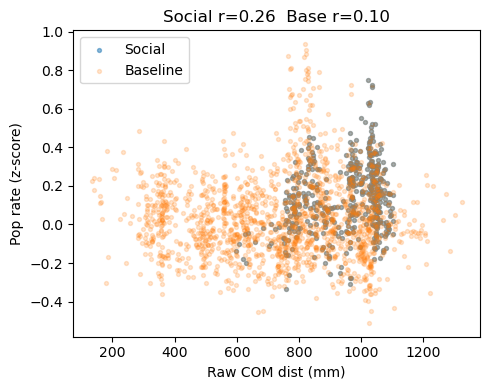

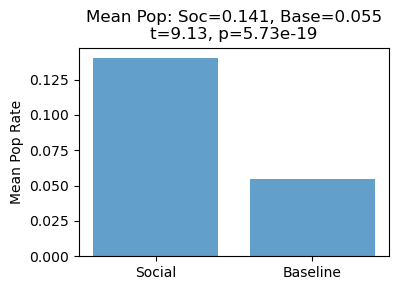

  window        r            p  mean_pop    n
  social 0.255051 2.355798e-08  0.140527  466
baseline 0.098442 9.508282e-06  0.054947 2016


In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. 排除字典 & 加载HDF5 的函数
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. 处理神经元信号：排除 & z-score
# ----------------------------------------------------------------------------
def process_neuron_activity(
    df,
    exclude_dict=None,
    manual_exclude_indices=None,
    apply_exclusion=True
):
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        else:
            if 'session_path' not in df.columns:
                excluded = []
            else:
                session_path = df['session_path'].iloc[0]
                excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        return np.empty((0, df.shape[0])), [], df.reset_index()

    activity = df[neuron_cols].values.T   # (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]           # (n_kept_neurons, n_frames)
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    return normalized, filtered_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 3. 计算 COM 距离（不平滑版本）
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    直接用 df_new 中最基础的 com0/com1 三坐标来算未经平滑的距离。
    返回一个 NumPy 数组 dist_raw，长度 = n_frames。
    """
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    if len(com_prefixes) < 2:
        raise ValueError("至少需要两个 com 前缀来计算距离。")
    p1, p2 = com_prefixes[0], com_prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    dist_raw = np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)
    return dist_raw

# ----------------------------------------------------------------------------
# 4. 极度粗略的“社交 vs 非社交”比较函数
# ----------------------------------------------------------------------------
def rough_social_vs_baseline(
    rec_path,
    social_start_s,
    social_end_s,
    exclude_dict=None,
    baseline_mode='whole',
    baseline_ranges_s=None
):
    """
    对齐不做极限要求，只用“秒”为单位指定社交区间，进行粗略比较。

    Parameters
    ----------
    rec_path : str
      会话根文件夹路径，内部会加载 MIR_Aligned/*.h5 得到 DataFrame。
    social_start_s : float
      社交时段开始时间，单位秒（如 41.0 表示 00:41）。
    social_end_s : float
      社交时段结束时间，单位秒（如 88.0 表示 01:28）。
    exclude_dict : dict or None
      神经元排除字典。
    baseline_mode : str, 'whole' or 'outside'
      - 'whole'：baseline = 整个会话。
      - 'outside'：baseline = 社交段以外的所有时段，需要提供 `baseline_ranges_s`。
    baseline_ranges_s : list of (start_s,end_s) tuples
      只有当 baseline_mode=='outside' 时才需要，比如 [(0,40),(89,120)]，以秒为单位。
    """
    # 1. Load & preprocess
    df = load_session_data(rec_path)
    if 'timestamp_ms_mini' not in df.columns:
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        else:
            raise KeyError("DataFrame 中缺少 'timestamp_ms_mini' 列或索引。")

    # 转换时间戳到秒
    t_ms = df['timestamp_ms_mini'].values
    t_s = t_ms / 1000.0

    # 2. Process neural activity
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df, exclude_dict=exclude_dict, manual_exclude_indices=None, apply_exclusion=True
    )
    # 转成 (n_frames,n_neurons)
    if neuron_norm.size:
        neuron_norm_T = neuron_norm.T
        pop_rate = neuron_norm_T.mean(axis=1)
    else:
        neuron_norm_T = np.empty((len(t_s), 0))
        pop_rate = np.zeros(len(t_s))

    # 3. Compute raw COM distance
    dist_raw = compute_com_distance_raw(df_new)  # (n_frames,)

    # 4. 找到社交时段的索引区间（粗略按秒映射）
    idx_start = np.searchsorted(t_s, social_start_s)
    idx_end   = np.searchsorted(t_s, social_end_s)
    if idx_start >= idx_end:
        raise ValueError("social_start_s 必须 < social_end_s，且在会话时长范围内。")

    dist_social = dist_raw[idx_start:idx_end]
    pop_social  = pop_rate[idx_start:idx_end]

    # 5. Baseline
    if baseline_mode == 'whole':
        dist_baseline = dist_raw
        pop_baseline  = pop_rate
    elif baseline_mode == 'outside':
        if not baseline_ranges_s:
            raise ValueError("baseline_mode='outside' 时必须提供 baseline_ranges_s")
        mask = np.zeros_like(t_s, dtype=bool)
        for (bstart, bend) in baseline_ranges_s:
            bi = np.searchsorted(t_s, bstart)
            bj = np.searchsorted(t_s, bend)
            mask[bi:bj] = True
        dist_baseline = dist_raw[mask]
        pop_baseline  = pop_rate[mask]
    else:
        raise ValueError("baseline_mode 必须是 'whole' 或 'outside'")

    # 6. 计算粗略 Pearson r
    if len(dist_social) >= 2:
        r_social, p_social = pearsonr(dist_social, pop_social)
    else:
        r_social, p_social = np.nan, np.nan
    if len(dist_baseline) >= 2:
        r_base, p_base = pearsonr(dist_baseline, pop_baseline)
    else:
        r_base, p_base = np.nan, np.nan

    # 7. 平均 pop_rate 对比
    mean_social = pop_social.mean()  if pop_social.size  else np.nan
    mean_base   = pop_baseline.mean() if pop_baseline.size else np.nan
    if pop_social.size and pop_baseline.size:
        t_stat, p_t = ttest_ind(pop_social, pop_baseline, equal_var=False)
    else:
        t_stat, p_t = np.nan, np.nan

    # 8. 绘图（可选）
    # 8a. 社交 vs 基线的散点
    plt.figure(figsize=(5,4))
    plt.scatter(dist_social, pop_social, s=8, alpha=0.5, label='Social')
    plt.scatter(dist_baseline, pop_baseline, s=8, alpha=0.2, label='Baseline')
    plt.xlabel("Raw COM dist (mm)")
    plt.ylabel("Pop rate (z-score)")
    plt.title(f"Social r={r_social:.2f}  Base r={r_base:.2f}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8b. 平均 pop_rate 柱状对比
    plt.figure(figsize=(4,3))
    plt.bar(['Social','Baseline'], [mean_social, mean_base], alpha=0.7)
    plt.ylabel("Mean Pop Rate")
    plt.title(f"Mean Pop: Soc={mean_social:.3f}, Base={mean_base:.3f}\n"
              f"t={t_stat:.2f}, p={p_t:.2e}")
    plt.tight_layout()
    plt.show()

    # 9. 返回结果
    results = {
        'r_social': r_social, 'p_social': p_social,
        'r_baseline': r_base, 'p_baseline': p_base,
        'mean_social': mean_social, 'mean_baseline': mean_base,
        't_stat': t_stat, 'p_t': p_t,
        'n_social': len(dist_social), 'n_baseline': len(dist_baseline)
    }
    summary_df = pd.DataFrame([
        {'window':'social','r':r_social,'p':p_social,'mean_pop':mean_social,'n':len(dist_social)},
        {'window':'baseline','r':r_base,'p':p_base,'mean_pop':mean_base,'n':len(dist_baseline)}
    ])
    return results, summary_df

# ----------------------------------------------------------------------------
# 10. 示例调用
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    session_paths = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/"
    ]
    for path in session_paths:
        print(f"\n=== Processing {path} ===")
        # 以秒为单位指定社交大窗口
        social_start_s = 41.0   # 00:41
        social_end_s   = 88.0   # 01:28

        # baseline_mode='outside' 时需要给出一段简单的非社交时段，例如视频开头前 40s，以及后面 10s
        # 只要“非社交”段戴进来就行，没必要精确
        # baseline_ranges_s = [
        #     (0.0, 40.0),      # 00:00–00:40
        #     (89.0, 120.0)     # 01:29–02:00（若会话继续到 2 分钟）
        # ]
        

        baseline_ranges_s = [
            (0.0, 40.0),         # 00:00–00:40
            (89.0, 120.0),       # 01:29–02:00
            (41.0, 54.0),        # 00:41–00:54
            (54.0, 88.0),        # 00:54–01:28
            (137.0, 149.0),      # 02:17–02:29
            (162.0, 165.0),      # 02:42–02:45
            (200.0, 218.0),      # 03:20–03:38
            (230.0, 243.0),      # 03:50–04:03
            (337.0, 343.0),      # 05:37–05:43
            (371.0, 375.0),      # 06:11–06:15
            (466.0, 468.0),      # 07:46–07:48
            (468.0, 472.0),      # 07:48–07:52
            (530.0, 530.0),      # 08:50 — single frame
            (533.0, 540.0),      # 08:53–09:00
            (562.0, 566.0),      # 09:22–09:26
                (562.0, 572.0),      # 09:22–09:32 (new)
    (573.0, 576.0),      # 09:33–09:36 (new)
    (615.0, 617.0),      # 10:15–10:17 (new)
    (670.0, 671.0),      # 11:10–11:11 (new)
        ]

        results, summary_df = rough_social_vs_baseline(
            rec_path=path,
            social_start_s=social_start_s,
            social_end_s=social_end_s,
            exclude_dict=exclude_mapping,
            baseline_mode='outside',
            baseline_ranges_s=baseline_ranges_s
        )
        print(summary_df.to_string(index=False))



Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30


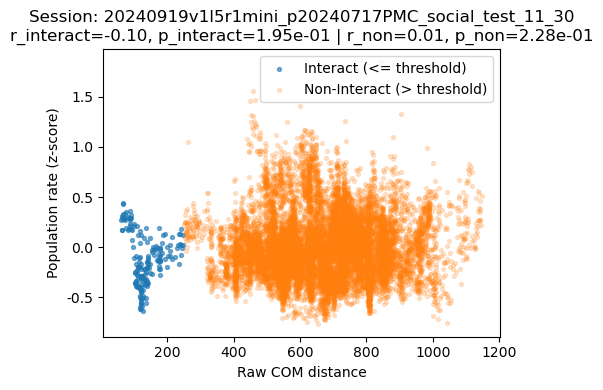

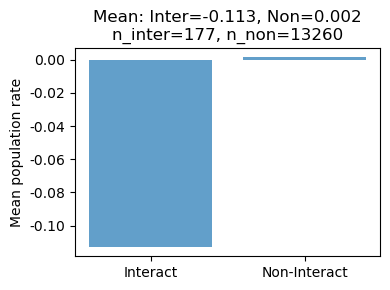


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33


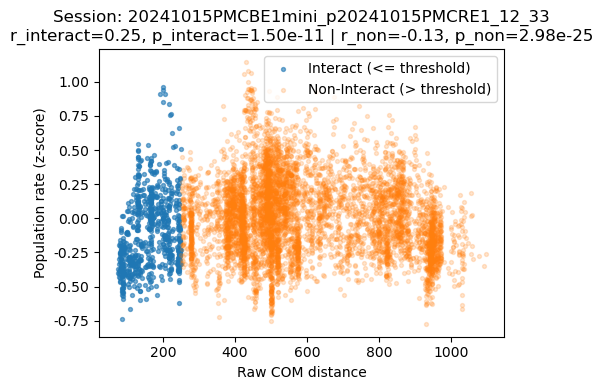

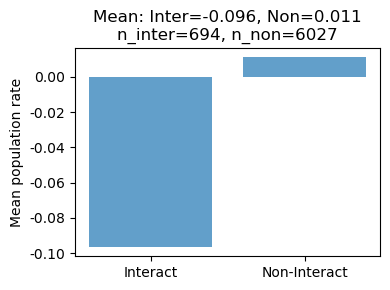


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04


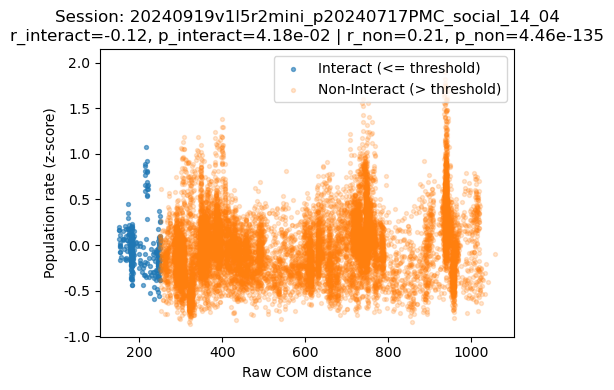

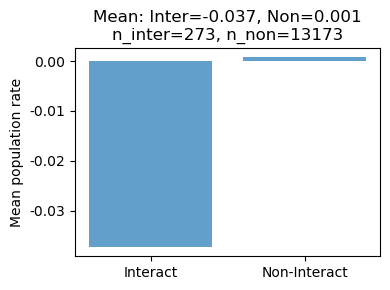


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50


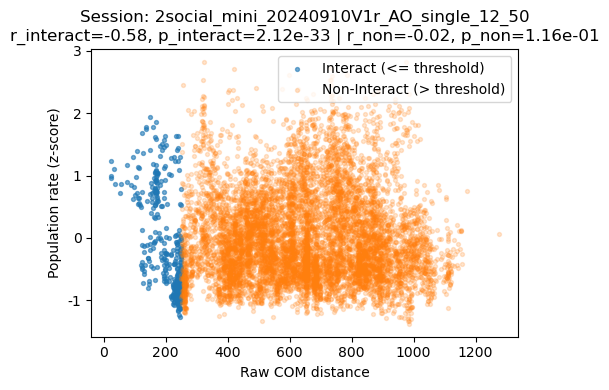

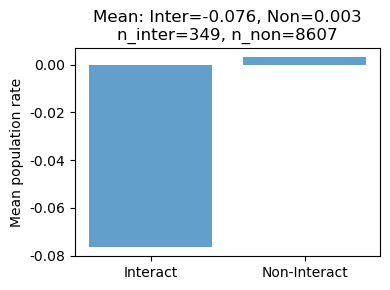


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30


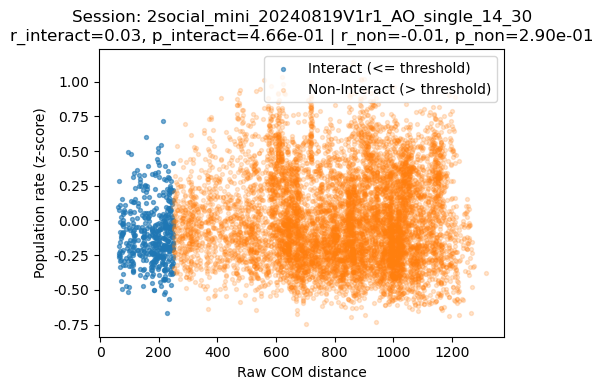

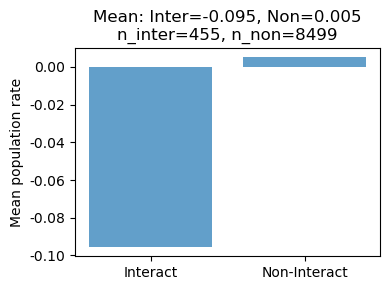


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29


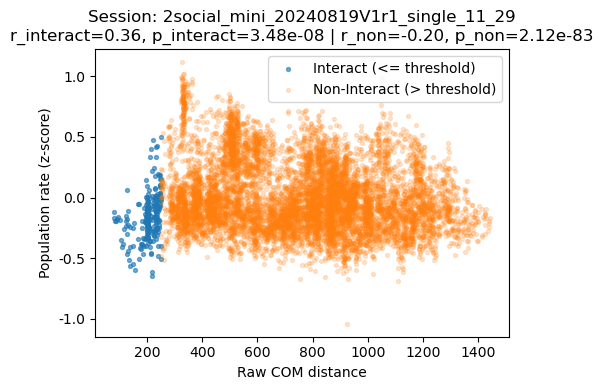

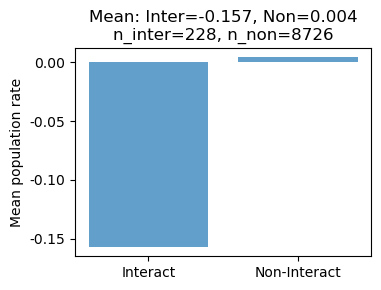


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48


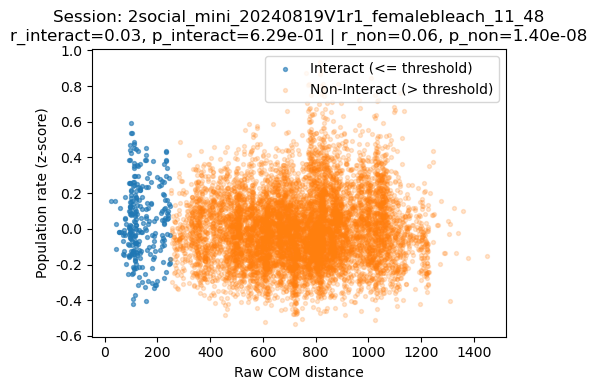

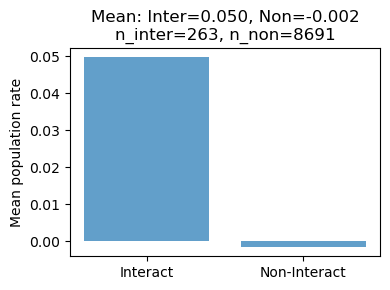


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2


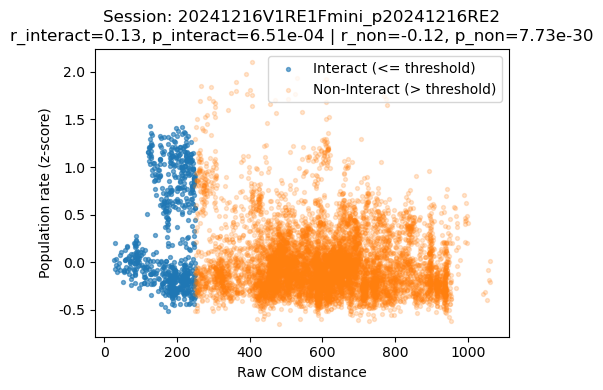

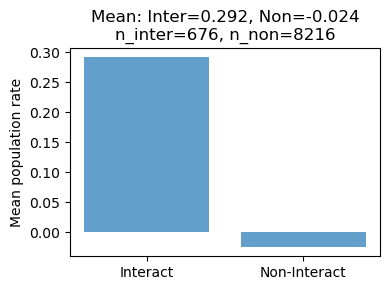


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1


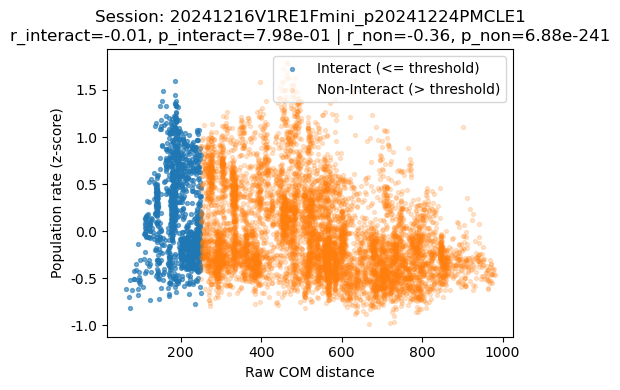

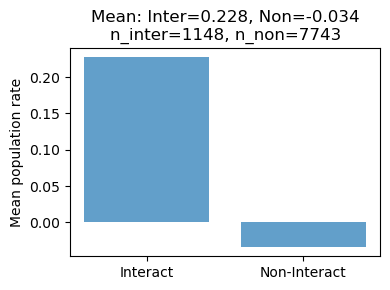


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1


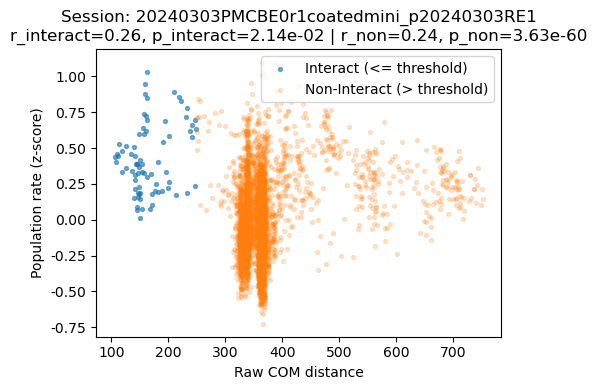

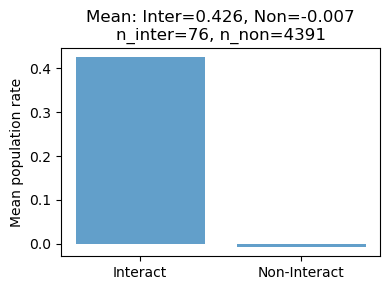


=== Summary of Correlations per Session ===
                                                                                   session_path  threshold  r_interact   p_interact  mean_pop_interact  n_interact  r_non_interact  p_non_interact  mean_pop_non_interact  n_non_interact
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30      250.0   -0.097963 1.945607e-01          -0.112773         177        0.010476    2.277323e-01               0.001505           13260
         /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33      250.0    0.252425 1.504766e-11          -0.096337         694       -0.133167    2.982244e-25               0.011093            6027
     /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04      250.0   -0.123304 4.177538e-02          -0.037268         273        0.213055   4.464099e-135               0.000772           13173
         /data/big_

In [26]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. 排除字典 & 加载HDF5 的函数
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    根据 session_path 从排除字典中获取需要排除的神经元索引列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    加载指定会话下的第一个符合模式的 HDF5 文件，返回包含信号与时间戳的 DataFrame，
    并在其中添加 session_id, recording_date, experiment, session_path, file_path 等列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. 处理神经元信号：排除 & z-score
# ----------------------------------------------------------------------------
def process_neuron_activity(
    df,
    exclude_dict=None,
    manual_exclude_indices=None,
    apply_exclusion=True
):
    """
    对 DataFrame 中的 dF_F_roi* 列进行排除与 z-score 标准化。
    返回标准化后 (n_neurons, n_frames) 的矩阵、保留的列名列表，以及带索引的原 DataFrame。
    """
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        else:
            if 'session_path' not in df.columns:
                excluded = []
            else:
                session_path = df['session_path'].iloc[0]
                excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    else:
        excluded = []

    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        # 如果没有剩余的神经元列，就返回空矩阵
        return np.empty((0, df.shape[0])), [], df.reset_index()

    activity = df[neuron_cols].values.T   # (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]           # (n_kept_neurons, n_frames)
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    return normalized, filtered_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 3. 计算 COM 距离（不平滑版本）
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    根据 df_new 中的 com0/com1 三坐标列，计算两点间未经平滑计算的距离。
    返回长度为 n_frames 的 NumPy 数组 dist_raw。
    """
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    if len(com_prefixes) < 2:
        raise ValueError("至少需要两个 com 前缀来计算距离。")
    p1, p2 = com_prefixes[0], com_prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    dist_raw = np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)
    return dist_raw

# ----------------------------------------------------------------------------
# 4. 使用阈值划分互动 & 非互动 并进行相关性计算 + 可视化
# ----------------------------------------------------------------------------
def process_session_with_threshold(
    rec_path,
    exclude_dict=None,
    threshold=250.0
):
    """
    对单个会话进行以下处理：
      1. 加载数据并转换时间戳到秒
      2. 标准化神经元活动，计算 population rate
      3. 计算原始 COM 距离 dist_raw
      4. 根据 threshold 将帧分为 互动(interact) 与 非互动(non_interact) 两组
      5. 计算两组内 dist vs pop_rate 的 Pearson 相关系数及平均值
      6. 画出两组在 dist vs pop_rate 上的散点图，以及平均 pop_rate 柱状图
      7. 返回一个汇总字典和包含各组统计的 DataFrame
    """
    # ——1. 加载 & 转换时间戳
    df = load_session_data(rec_path)
    if 'timestamp_ms_mini' not in df.columns:
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        else:
            raise KeyError("DataFrame 中缺少 'timestamp_ms_mini' 列或索引。")
    t_ms = df['timestamp_ms_mini'].values
    t_s = t_ms / 1000.0

    # ——2. 处理神经元活动并计算 population rate
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df, exclude_dict=exclude_dict, manual_exclude_indices=None, apply_exclusion=True
    )
    if neuron_norm.size:
        neuron_norm_T = neuron_norm.T  # (n_frames, n_kept_neurons)
        pop_rate = neuron_norm_T.mean(axis=1)
    else:
        pop_rate = np.zeros(len(t_s))

    # ——3. 计算原始 COM 距离
    dist_raw = compute_com_distance_raw(df_new)  # (n_frames,)

    # ——4. 根据 threshold 划分互动 / 非互动
    interact_mask = dist_raw <= threshold
    non_interact_mask = ~interact_mask

    dist_interact = dist_raw[interact_mask]
    pop_interact = pop_rate[interact_mask]
    dist_non = dist_raw[non_interact_mask]
    pop_non = pop_rate[non_interact_mask]

    # ——5. 计算各自组内的 Pearson 相关系数 & 平均值
    if len(dist_interact) >= 2:
        r_interact, p_interact = pearsonr(dist_interact, pop_interact)
        mean_pop_interact = pop_interact.mean()
    else:
        r_interact, p_interact, mean_pop_interact = np.nan, np.nan, np.nan

    if len(dist_non) >= 2:
        r_non, p_non = pearsonr(dist_non, pop_non)
        mean_pop_non = pop_non.mean()
    else:
        r_non, p_non, mean_pop_non = np.nan, np.nan, np.nan

    # ——6. 可视化：散点图 + 柱状图
    session_name = os.path.basename(os.path.normpath(rec_path))
    # 6a. Scatter：互动 vs 非互动 的 dist vs pop_rate
    plt.figure(figsize=(5, 4))
    plt.scatter(dist_interact, pop_interact, s=8, alpha=0.6, label='Interact (<= threshold)')
    plt.scatter(dist_non, pop_non, s=8, alpha=0.2, label='Non-Interact (> threshold)')
    plt.xlabel("Raw COM distance")
    plt.ylabel("Population rate (z-score)")
    title_str = (f"Session: {session_name}\n"
                 f"r_interact={r_interact:.2f}, p_interact={p_interact:.2e} | "
                 f"r_non={r_non:.2f}, p_non={p_non:.2e}")
    plt.title(title_str)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 6b. Bar plot：互动 vs 非互动 的平均 pop_rate
    plt.figure(figsize=(4, 3))
    plt.bar(
        ['Interact', 'Non-Interact'],
        [mean_pop_interact, mean_pop_non],
        alpha=0.7
    )
    plt.ylabel("Mean population rate")
    subtitle = (f"Mean: Inter={mean_pop_interact:.3f}, Non={mean_pop_non:.3f}\n"
                f"n_inter={len(dist_interact)}, n_non={len(dist_non)}")
    plt.title(subtitle)
    plt.tight_layout()
    plt.show()

    # ——7. 返回数值结果
    results = {
        'session_path': rec_path,
        'threshold': threshold,
        'r_interact': r_interact,
        'p_interact': p_interact,
        'mean_pop_interact': mean_pop_interact,
        'n_interact': len(dist_interact),
        'r_non_interact': r_non,
        'p_non_interact': p_non,
        'mean_pop_non_interact': mean_pop_non,
        'n_non_interact': len(dist_non)
    }
    summary_df = pd.DataFrame([
        {
            'group': 'interact',
            'r': r_interact,
            'p': p_interact,
            'mean_pop': mean_pop_interact,
            'n': len(dist_interact)
        },
        {
            'group': 'non_interact',
            'r': r_non,
            'p': p_non,
            'mean_pop': mean_pop_non,
            'n': len(dist_non)
        }
    ])
    return results, summary_df

# ----------------------------------------------------------------------------
# 5. 按照用户提供的 session_paths 列表执行批量处理
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    session_paths = [
    #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
    #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
    #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/"

    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
    ]

    # 可根据需求随时调整阈值
    threshold = 250.0

    all_results = []
    all_summaries = []

    for path in session_paths:
        try:
            print(f"\nProcessing session: {path}")
            result_dict, summary_df = process_session_with_threshold(
                rec_path=path,
                exclude_dict=exclude_mapping,
                threshold=threshold
            )
            all_results.append(result_dict)
            summary_df['session_path'] = path
            all_summaries.append(summary_df)
        except Exception as e:
            print(f"  Skipped {path} due to error: {e}")

    # 汇总数值结果
    if all_results:
        results_df = pd.DataFrame(all_results)
        print("\n=== Summary of Correlations per Session ===")
        print(results_df.to_string(index=False))
        # 如果需要将结果保存为 CSV：
        # results_df.to_csv("com_threshold_results.csv", index=False)

    if all_summaries:
        combined_summary = pd.concat(all_summaries, ignore_index=True)
        print("\n=== Group-Level Summary (interact vs non_interact) for All Sessions ===")
        print(combined_summary.to_string(index=False))
        # 如果需要将分组详情保存为 CSV：
        # combined_summary.to_csv("com_threshold_group_summary.csv", index=False)


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/
  Skipped /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/ due to error: 无法识别会话类型（缺少 com0_x/com1_x 或 com_x/com_y/com_z）：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/

Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/
  Skipped /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/ due to error: 无法识别会话类型（缺少 com0_x/com1_x 或 com_x/com_y/com_z）：/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/

Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/
  Skipped /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/ due to error: 无法识别会话类型（缺少 com0_x/com1_x 或 com_x/com_y/com_z）：/data/big_ri

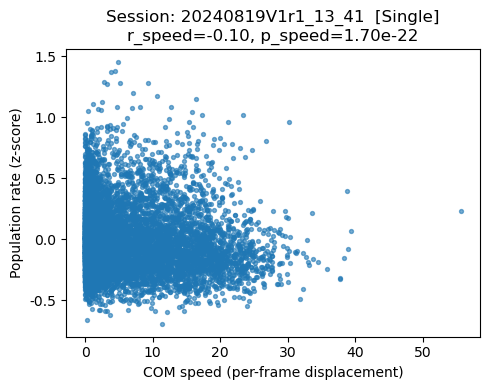

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

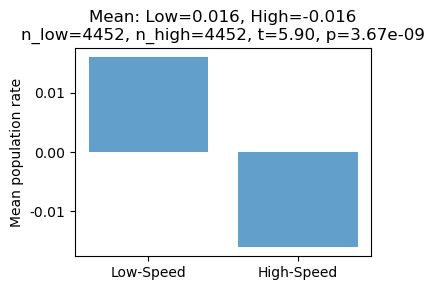


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

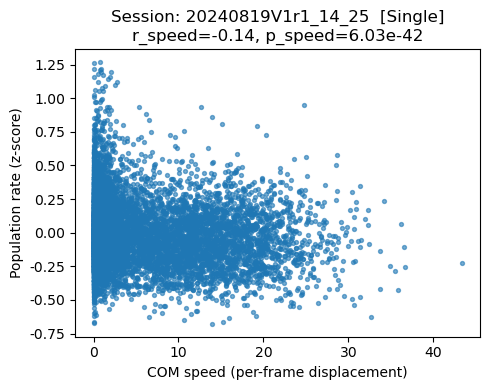

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

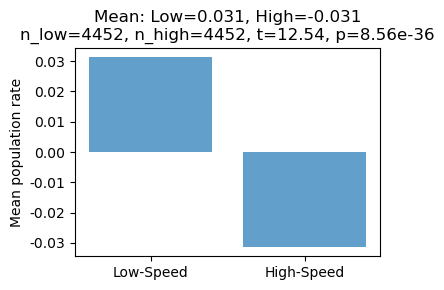


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

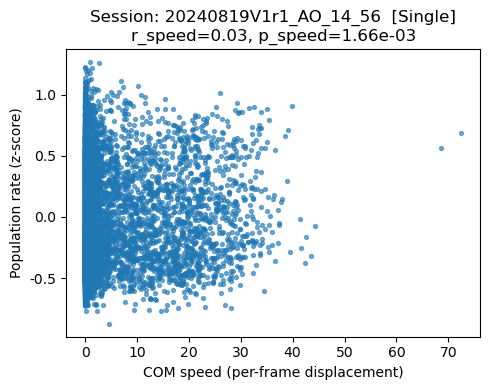

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

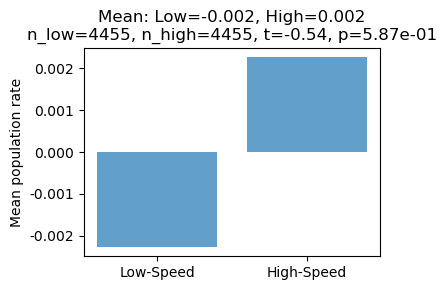


=== Summary of All Sessions ===
                                                        session_path   mode   r_speed      p_speed  mean_low_speed  n_low_speed  mean_high_speed  n_high_speed    t_stat          p_t
   /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/ single -0.103155 1.696723e-22        0.016056         4452        -0.016056          4452  5.904521 3.669610e-09
   /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/ single -0.143090 6.026093e-42        0.031325         4452        -0.031325          4452 12.544831 8.557955e-36
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/ single  0.033321 1.656916e-03       -0.002263         4455         0.002263          4455 -0.543902 5.865223e-01

=== Detailed Summary (by group) ===
     group  mean_pop    n                                                         session_path
 low_speed  0.016056 4452    /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/
high_speed -

In [13]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. 排除字典 & 加载 HDF5 的函数
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    根据 session_path 从排除字典中获取需要排除的神经元索引列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    加载指定会话下的第一个符合模式的 HDF5 文件，返回包含信号与时间戳的 DataFrame，
    并在其中添加 session_id, recording_date, experiment, session_path, file_path 等列。
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 with aligned_predictions_with_ca_and_dF_F in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. 处理神经元信号：排除 & z-score
# ----------------------------------------------------------------------------
def process_neuron_activity(
    df,
    exclude_dict=None,
    manual_exclude_indices=None,
    apply_exclusion=True
):
    """
    对 DataFrame 中的 dF_F_roi* 列进行排除与 z-score 标准化。
    返回标准化后 (n_neurons, n_frames) 的矩阵、保留的列名列表，以及带索引的原 DataFrame。
    """
    # 1) 确定要排除的 roi 索引
    if apply_exclusion:
        if manual_exclude_indices is not None:
            excluded = manual_exclude_indices
        else:
            if 'session_path' not in df.columns:
                excluded = []
            else:
                session_path = df['session_path'].iloc[0]
                excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    else:
        excluded = []

    # 2) 列出所有以 dF_F_roi 开头但不在排除列表中的列
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        return np.empty((0, df.shape[0])), [], df.reset_index()

    # 3) 将这些列提取为矩阵：shape=(n_neurons, n_frames)
    activity = df[neuron_cols].values.T
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]           # (n_kept_neurons, n_frames)
    filtered_cols = [col for i, col in enumerate(neuron_cols) if keep[i]]
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    return normalized, filtered_cols, df.reset_index()

# ----------------------------------------------------------------------------
# 3. 计算 COM 距离（社交会话使用）
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    根据 df_new 中的 com0/com1 三坐标列，计算两点间未经平滑计算的距离。
    返回长度为 n_frames 的 NumPy 数组 dist_raw。
    """
    com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com')})
    # com_prefixes 里应该至少含有 ['com0', 'com1']
    if 'com0' not in com_prefixes or 'com1' not in com_prefixes:
        raise ValueError("社交会话需要同事存在 com0_x, com1_x 等字段")
    dx = df_new['com0_x'] - df_new['com1_x']
    dy = df_new['com0_y'] - df_new['com1_y']
    dz = df_new['com0_z'] - df_new['com1_z']
    dist_raw = np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)
    return dist_raw

# ----------------------------------------------------------------------------
# 4. 计算单独会话的 COM 速度
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    单独会话：df_new 只有 com_x, com_y, com_z 三列。计算连续帧之间的速度 magnitude：
      speed[t] = sqrt((x[t] - x[t-1])^2 + ...)，第一个帧速度设为 0。 
    返回长度为 n_frames 的 NumPy 数组 speed。
    """
    # 确认存在单独的 com_x, com_y, com_z
    if not all(k in df_new.columns for k in ['com_x', 'com_y', 'com_z']):
        raise ValueError("单独会话需要包含 com_x, com_y, com_z")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    # 计算差分
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    speed = np.sqrt(dx**2 + dy**2 + dz**2)
    return speed

# ----------------------------------------------------------------------------
# 5. 处理“社交”会话（阈值分组 + 可视化）
# ----------------------------------------------------------------------------
def process_social_session(
    df_new,
    pop_rate,
    rec_path,
    threshold=250.0
):
    """
    对一个社交会话（存在 com0/com1）：
      - 计算 dist_raw
      - 按照 dist ≤ threshold 分组：Interact / Non-Interact
      - 分别计算 r, p, mean_pop, n，并绘图
    df_new: 已经包含 timestamp_ms_mini 且已 reset_index 的 DataFrame
    pop_rate: (n_frames,) 的 NumPy 数组
    rec_path: 会话路径，用于图标题
    threshold: COM 距离阈值
    返回 results_dict, summary_df
    """
    dist_raw = compute_com_distance_raw(df_new)  # (n_frames,)
    interact_mask = dist_raw <= threshold
    non_interact_mask = ~interact_mask

    dist_interact = dist_raw[interact_mask]
    pop_interact = pop_rate[interact_mask]
    dist_non = dist_raw[non_interact_mask]
    pop_non = pop_rate[non_interact_mask]

    # 相关性 & 均值
    if len(dist_interact) >= 2:
        r_interact, p_interact = pearsonr(dist_interact, pop_interact)
        mean_pop_interact = pop_interact.mean()
    else:
        r_interact, p_interact, mean_pop_interact = np.nan, np.nan, np.nan

    if len(dist_non) >= 2:
        r_non, p_non = pearsonr(dist_non, pop_non)
        mean_pop_non = pop_non.mean()
    else:
        r_non, p_non, mean_pop_non = np.nan, np.nan, np.nan

    # 可视化：散点 + 柱状
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.figure(figsize=(5, 4))
    plt.scatter(dist_interact, pop_interact, s=8, alpha=0.6, label='Interact (≤ thr)')
    plt.scatter(dist_non, pop_non, s=8, alpha=0.2, label='Non-Interact (> thr)')
    plt.xlabel("Raw COM distance")
    plt.ylabel("Population rate (z-score)")
    title_str = (f"Session: {session_name}  [Social]\n"
                 f"r_int={r_interact:.2f}, p_int={p_interact:.2e} | "
                 f"r_non={r_non:.2f}, p_non={p_non:.2e}")
    plt.title(title_str)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4, 3))
    plt.bar(['Interact','Non-Interact'], [mean_pop_interact, mean_pop_non], alpha=0.7)
    plt.ylabel("Mean population rate")
    subtitle = (f"Mean: Int={mean_pop_interact:.3f}, Non={mean_pop_non:.3f}\n"
                f"n_int={len(dist_interact)}, n_non={len(dist_non)}")
    plt.title(subtitle)
    plt.tight_layout()
    plt.show()

    results = {
        'session_path': rec_path,
        'mode': 'social',
        'threshold': threshold,
        'r_interact': r_interact,
        'p_interact': p_interact,
        'mean_pop_interact': mean_pop_interact,
        'n_interact': len(dist_interact),
        'r_non_interact': r_non,
        'p_non_interact': p_non,
        'mean_pop_non_interact': mean_pop_non,
        'n_non_interact': len(dist_non)
    }
    summary_df = pd.DataFrame([
        {'group': 'interact', 'r': r_interact, 'p': p_interact,
         'mean_pop': mean_pop_interact, 'n': len(dist_interact)},
        {'group': 'non_interact', 'r': r_non, 'p': p_non,
         'mean_pop': mean_pop_non, 'n': len(dist_non)}
    ])
    return results, summary_df

# ----------------------------------------------------------------------------
# 6. 处理“单独”会话（速度 vs 放电率 的相关 + 可视化）
# ----------------------------------------------------------------------------
def process_single_session(
    df_new,
    pop_rate,
    rec_path,
    speed_split_quantile=0.5
):
    """
    对一个单独会话（只有 com_x,y,z）：
      - 计算 speed = 连续帧之间位移大小
      - 计算 speed vs pop_rate 的 Pearson 相关（r_speed, p_speed）
      - 把 speed 按照中位数（quantile=0.5）分组：Low-Speed / High-Speed
      - 计算两组的 mean_pop_rate、样本量 & t-test
      - 绘制：speed vs pop_rate 散点；Low vs High 的平均放电率柱状
    df_new: 已 reset_index 的 DataFrame，含 com_x,com_y,com_z
    pop_rate: (n_frames,) 的 NumPy 数组
    rec_path: 会话路径
    speed_split_quantile: 用于划分低速/高速的分位数，默认 0.5（中位数）
    返回 results_dict, summary_df
    """
    speed = compute_com_speed(df_new)  # (n_frames,)
    # Pearson 相关
    if len(speed) >= 2:
        r_speed, p_speed = pearsonr(speed, pop_rate)
    else:
        r_speed, p_speed = np.nan, np.nan

    # 按照分位数划分：低速 vs 高速
    cut_val = np.quantile(speed, speed_split_quantile)
    low_mask = speed <= cut_val
    high_mask = speed > cut_val

    pop_low = pop_rate[low_mask]
    pop_high = pop_rate[high_mask]
    mean_low = pop_low.mean() if pop_low.size else np.nan
    mean_high = pop_high.mean() if pop_high.size else np.nan
    n_low = len(pop_low)
    n_high = len(pop_high)

    # t-test 两组均值差异
    if pop_low.size and pop_high.size:
        t_stat, p_t = ttest_ind(pop_low, pop_high, equal_var=False)
    else:
        t_stat, p_t = np.nan, np.nan

    # 可视化：散点 + 柱状
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.figure(figsize=(5, 4))
    plt.scatter(speed, pop_rate, s=8, alpha=0.6)
    plt.xlabel("COM speed (per-frame displacement)")
    plt.ylabel("Population rate (z-score)")
    title_str = (f"Session: {session_name}  [Single]\n"
                 f"r_speed={r_speed:.2f}, p_speed={p_speed:.2e}")
    plt.title(title_str)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(4, 3))
    plt.bar(['Low-Speed','High-Speed'], [mean_low, mean_high], alpha=0.7)
    plt.ylabel("Mean population rate")
    subtitle = (f"Mean: Low={mean_low:.3f}, High={mean_high:.3f}\n"
                f"n_low={n_low}, n_high={n_high}, t={t_stat:.2f}, p={p_t:.2e}")
    plt.title(subtitle)
    plt.tight_layout()
    plt.show()

    results = {
        'session_path': rec_path,
        'mode': 'single',
        'r_speed': r_speed,
        'p_speed': p_speed,
        'mean_low_speed': mean_low,
        'n_low_speed': n_low,
        'mean_high_speed': mean_high,
        'n_high_speed': n_high,
        't_stat': t_stat,
        'p_t': p_t
    }
    summary_df = pd.DataFrame([
        {'group': 'low_speed', 'mean_pop': mean_low, 'n': n_low},
        {'group': 'high_speed', 'mean_pop': mean_high, 'n': n_high}
    ])
    return results, summary_df

# ----------------------------------------------------------------------------
# 7. 统一入口：自动判断是“社交”还是“单独”会话
# ----------------------------------------------------------------------------
def process_session_auto(
    rec_path,
    exclude_dict=None,
    threshold=250.0,
    speed_split_quantile=0.5
):
    """
    自动识别 rec_path 属于“社交”还是“单独”会话：
      - 如果 df_new 中包含 com0_x，就按社交处理
      - 否则如果包含 com_x，就按单独处理
    返回对应的 (results_dict, summary_df)。
    """
    # 先加载原始 DataFrame，并把 index 恢复到列
    df = load_session_data(rec_path)
    if 'timestamp_ms_mini' not in df.columns:
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        else:
            raise KeyError("DataFrame 中缺少 'timestamp_ms_mini' 列或索引。")
    df_new = df.reset_index()

    # 处理神经元信号，得到标准化后的神经元活动 & pop_rate
    neuron_norm, neuron_cols, df_new = process_neuron_activity(
        df_new, exclude_dict=exclude_dict, manual_exclude_indices=None, apply_exclusion=True
    )
    if neuron_norm.size:
        neuron_norm_T = neuron_norm.T  # (n_frames, n_kept_neurons)
        pop_rate = neuron_norm_T.mean(axis=1)
    else:
        pop_rate = np.zeros(len(df_new))

    # 识别 com0_x 是否存在
    cols = set(df_new.columns)
    if 'com0_x' in cols and 'com1_x' in cols:
        # 社交会话
        return process_social_session(df_new, pop_rate, rec_path, threshold)
    elif all(k in cols for k in ['com_x', 'com_y', 'com_z']):
        # 单独会话
        return process_single_session(df_new, pop_rate, rec_path, speed_split_quantile)
    else:
        raise ValueError(f"无法识别会话类型（缺少 com0_x/com1_x 或 com_x/com_y/com_z）：{rec_path}")

# ----------------------------------------------------------------------------
# 8. 批量执行示例
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    session_paths = [
        # 原来的三条社交会话
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # 新增的三条单独会话
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"
    ]

    threshold = 250.0            # 社交会话 COM 距离阈值 (单位与坐标一致)
    speed_split_quantile = 0.5   # 单独会话速度分组的分位数 (0.5 表示中位数)

    all_results = []
    all_summaries = []

    for path in session_paths:
        print(f"\nProcessing session: {path}")
        try:
            results_dict, summary_df = process_session_auto(
                rec_path=path,
                exclude_dict=exclude_mapping,
                threshold=threshold,
                speed_split_quantile=speed_split_quantile
            )
            all_results.append(results_dict)
            summary_df['session_path'] = path
            all_summaries.append(summary_df)
        except Exception as e:
            print(f"  Skipped {path} due to error: {e}")

    # 输出整体数值结果
    if all_results:
        results_df = pd.DataFrame(all_results)
        print("\n=== Summary of All Sessions ===")
        print(results_df.to_string(index=False))
        # 如果需要将结果保存为 CSV：
        # results_df.to_csv("all_sessions_comparison.csv", index=False)

    if all_summaries:
        combined_summary = pd.concat(all_summaries, ignore_index=True)
        print("\n=== Detailed Summary (by group) ===")
        print(combined_summary.to_string(index=False))
        # 如果需要将分组详情保存为 CSV：
        # combined_summary.to_csv("all_sessions_group_details.csv", index=False)


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/

Samples: single = 26718, social_non = 25916, social_int = 946



/tmp/ipykernel_919466/3633720245.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


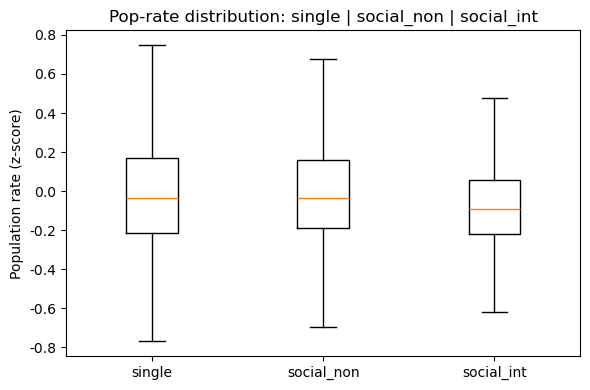

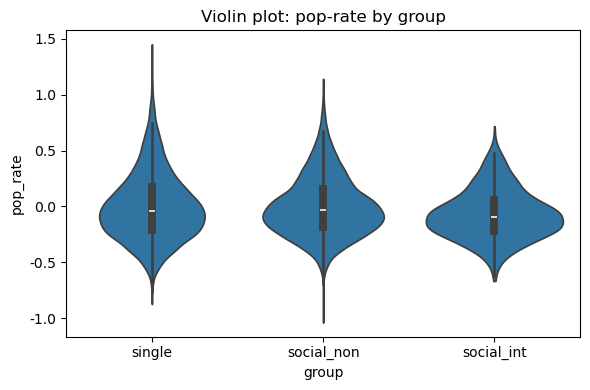

Kruskal–Wallis H = 62.136, p = 3.216e-14
  single vs social_non → U = 340167139.0, p = 5.234e-04
  single vs social_int → U = 14158199.0, p = 2.991e-10
  social_non vs social_int → U = 14067319.0, p = 1.144e-14

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/:


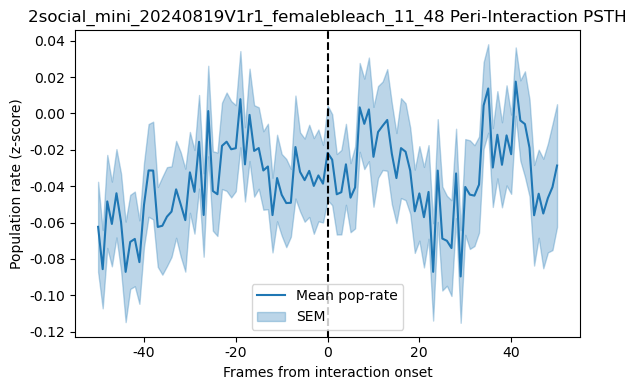


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/:


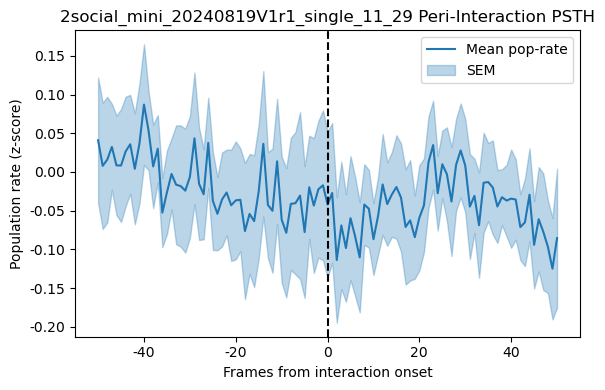


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/:


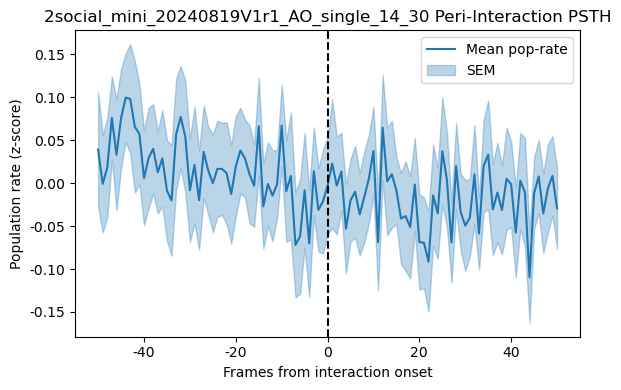


Analysis complete.


In [20]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Process and aggregate "social" vs "single" sessions
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    Given a list of session_paths, automatically determine for each whether it is social or single,
    collect pop_rate into:
      - all_pop_single
      - all_pop_social_int (interaction frames)
      - all_pop_social_non (non-interaction frames)
    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single     = []
    all_pop_social_int = []
    all_pop_social_non = []
    social_onsets_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_new)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_int = pop_rate[dist_raw <= threshold].tolist()
            pop_non = pop_rate[dist_raw > threshold].tolist()
            all_pop_social_int += pop_int
            all_pop_social_non += pop_non

            # Record indices where non-interaction → interaction transitions occur
            labels = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels[:-1] == 'non') & (labels[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_new)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_int, all_pop_social_non, social_onsets_dict

# ----------------------------------------------------------------------------
# 5. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests.
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            u_stat, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            print(f"  {a_name} vs {b_name} → U = {u_stat:.1f}, p = {p_u:.3e}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 7. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    session_paths = [
        # Social sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # Single sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"
    ]

    threshold = 250.0  # COM distance threshold for social sessions

    # Collect three groups of pop_rate and social event onsets
    pop_single, pop_sint, pop_snon, social_onsets_dict = collect_groups(session_paths, threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")

    # Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    # Optional: Plot Peri-Event PSTH for each social session
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)

    print("\nAnalysis complete.")


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58
Processing session

/tmp/ipykernel_919466/2337098875.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


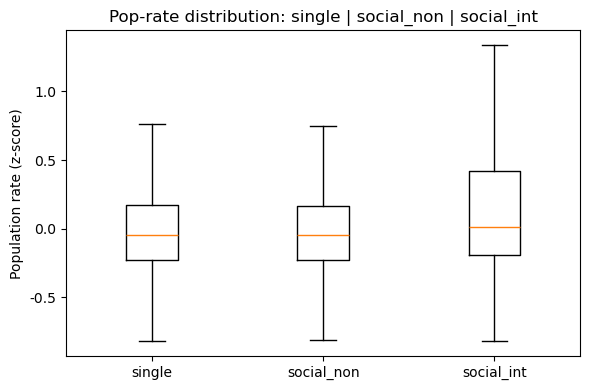

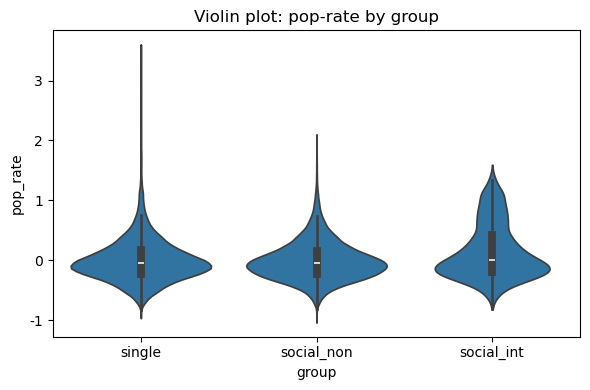

Kruskal–Wallis H = 191.487, p = 2.625e-42
  single vs social_non → U = 2368995642.0, p = 5.696e-01
  single vs social_int → U = 92740232.0, p = 5.173e-42
  social_non vs social_int → U = 69834487.0, p = 1.478e-43

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30:


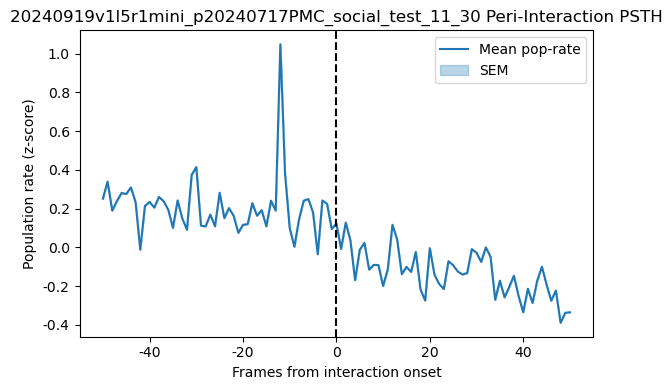


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04:


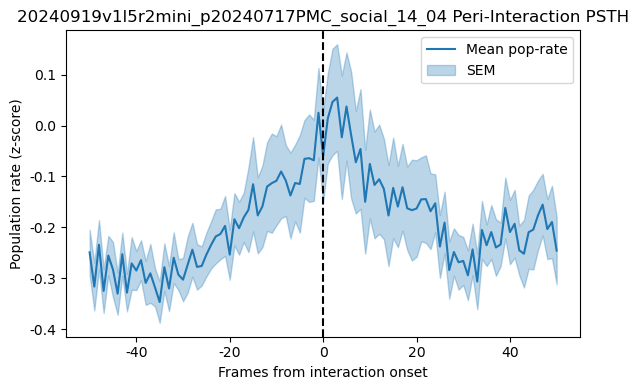


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29:


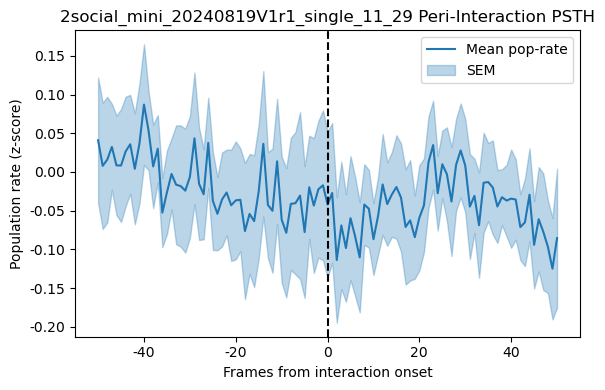


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48:


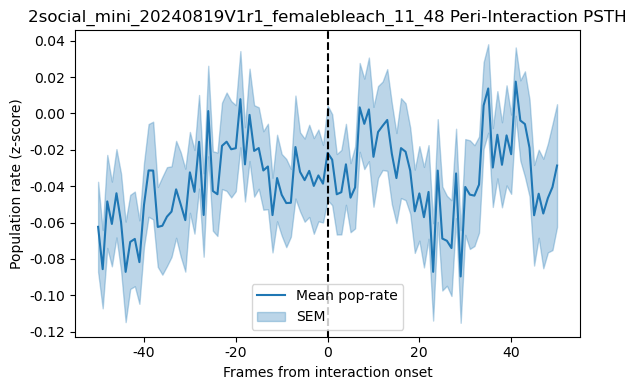


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2:


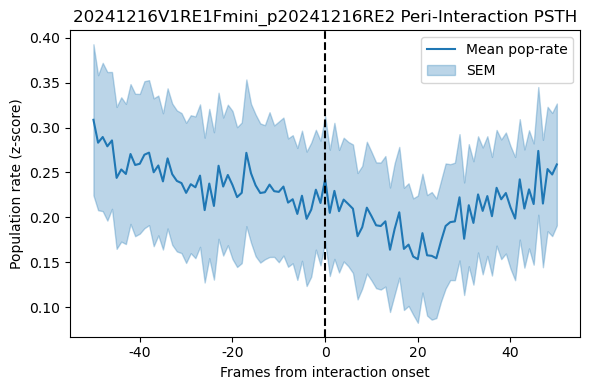


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1:


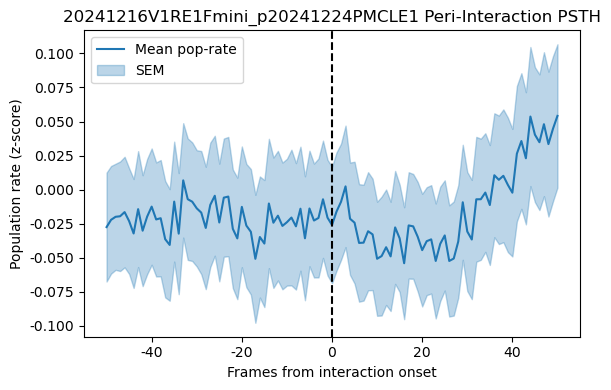


Analysis complete.


In [40]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Process and aggregate "social" vs "single" sessions
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    Given a list of session_paths, automatically determine for each whether it is social or single,
    collect pop_rate into:
      - all_pop_single
      - all_pop_social_int (interaction frames)
      - all_pop_social_non (non-interaction frames)
    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single     = []
    all_pop_social_int = []
    all_pop_social_non = []
    social_onsets_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_new)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_int = pop_rate[dist_raw <= threshold].tolist()
            pop_non = pop_rate[dist_raw > threshold].tolist()
            all_pop_social_int += pop_int
            all_pop_social_non += pop_non

            # Record indices where non-interaction → interaction transitions occur
            labels = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels[:-1] == 'non') & (labels[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_new)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_int, all_pop_social_non, social_onsets_dict

# ----------------------------------------------------------------------------
# 5. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests.
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            u_stat, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            print(f"  {a_name} vs {b_name} → U = {u_stat:.1f}, p = {p_u:.3e}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 7. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    session_paths = [
        # Social sessions
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_1
        

    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",


        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # Single sessions
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"


        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240910V1r_AO_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"

    ]
# 
    threshold = 250.0  # COM distance threshold for social sessions

    # Collect three groups of pop_rate and social event onsets
    pop_single, pop_sint, pop_snon, social_onsets_dict = collect_groups(session_paths, threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")

    # Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    # Optional: Plot Peri-Event PSTH for each social session
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)

    print("\nAnalysis complete.")


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1m

/tmp/ipykernel_919466/2607410572.py:200: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


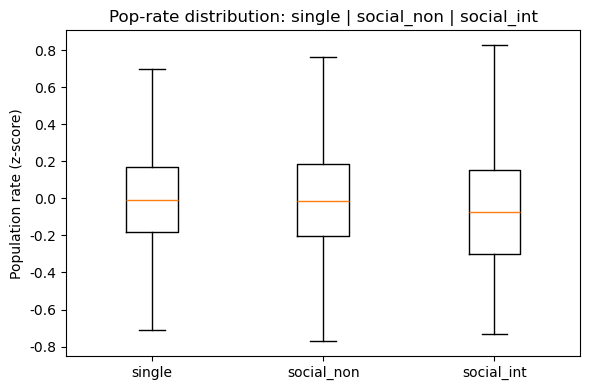

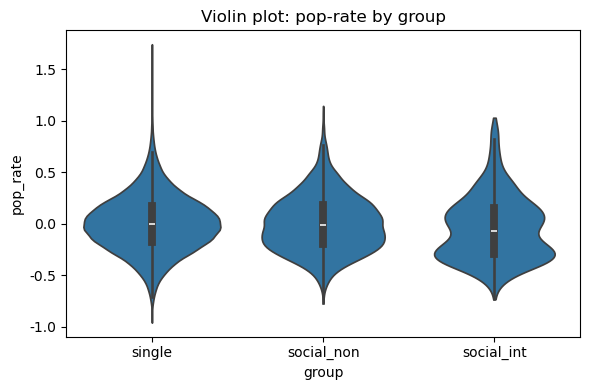

Kruskal–Wallis H = 34.359, p = 3.460e-08
  single vs social_non → U = 378041329.0, p = 3.810e-01
  single vs social_int → U = 31163790.0, p = 6.773e-09
  social_non vs social_int → U = 4494958.0, p = 2.185e-08

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33:


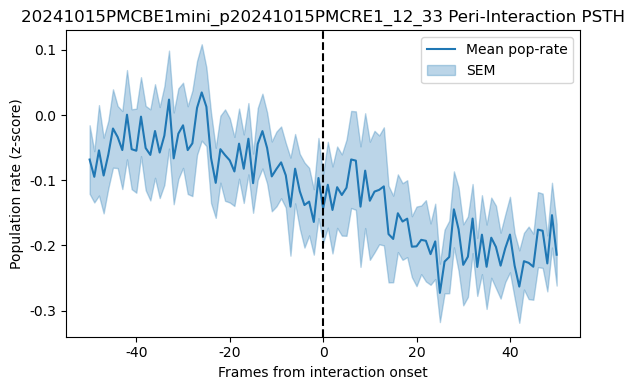


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1:


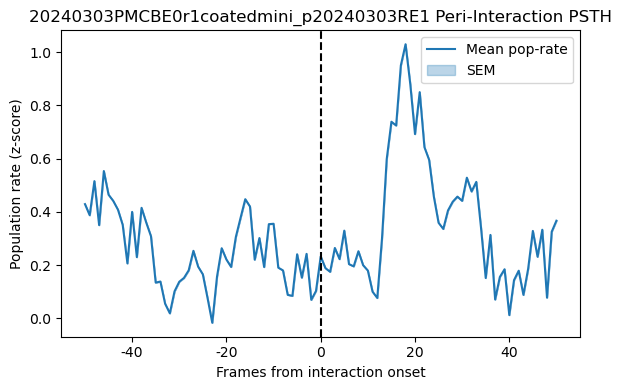


Analysis complete.


In [41]:
#


import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Process and aggregate "social" vs "single" sessions
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    Given a list of session_paths, automatically determine for each whether it is social or single,
    collect pop_rate into:
      - all_pop_single
      - all_pop_social_int (interaction frames)
      - all_pop_social_non (non-interaction frames)
    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single     = []
    all_pop_social_int = []
    all_pop_social_non = []
    social_onsets_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_new)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_int = pop_rate[dist_raw <= threshold].tolist()
            pop_non = pop_rate[dist_raw > threshold].tolist()
            all_pop_social_int += pop_int
            all_pop_social_non += pop_non

            # Record indices where non-interaction → interaction transitions occur
            labels = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels[:-1] == 'non') & (labels[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_new)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_int, all_pop_social_non, social_onsets_dict

# ----------------------------------------------------------------------------
# 5. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests.
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            u_stat, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            print(f"  {a_name} vs {b_name} → U = {u_stat:.1f}, p = {p_u:.3e}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 7. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    session_paths = [
        # Social sessions
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_1
        

    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",


        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # Single sessions
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"


    #     "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_24/20241001PMCr2_16_19",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_25/20241002PMCr2_16_25",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240910V1r_AO_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_16_53",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_06/20241015pmcr2_17_13",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_07/20241015pmcr2_AO_12_52",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_44",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_13_57",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_12/20241001PMCRE2mini_15_35",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_13/20241225PMCLE1mini_11_06",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_12_24"

    ]
# 
    threshold = 250.0  # COM distance threshold for social sessions

    # Collect three groups of pop_rate and social event onsets
    pop_single, pop_sint, pop_snon, social_onsets_dict = collect_groups(session_paths, threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")

    # Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    # Optional: Plot Peri-Event PSTH for each social session
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)

    print("\nAnalysis complete.")


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_

/tmp/ipykernel_919466/3345197783.py:198: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


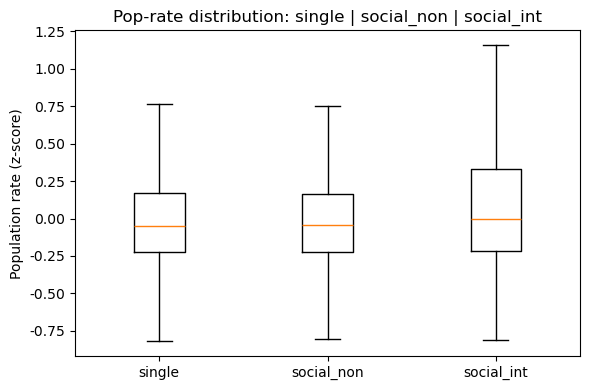

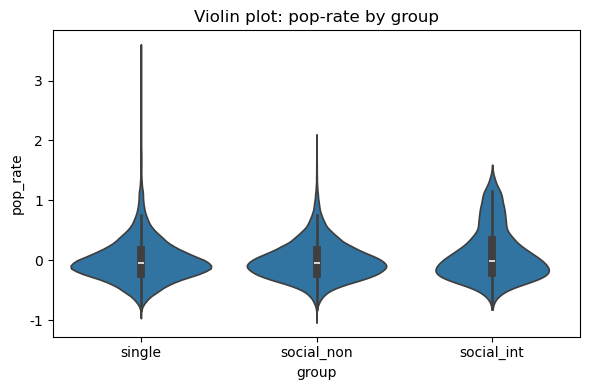

Kruskal–Wallis H = 110.758, p = 8.896e-25, eta² ≈ 0.0007
  single vs social_non: U = 2761967454.0, p = 7.623e-02, rank-biserial r ≈ 0.0053
  single vs social_int: U = 125323138.0, p = 2.136e-25, rank-biserial r ≈ 0.1034
  social_non vs social_int: U = 111669060.0, p = 6.486e-24, rank-biserial r ≈ 0.1004

--- Splitting social_int into categories ---


/tmp/ipykernel_919466/3345197783.py:283: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


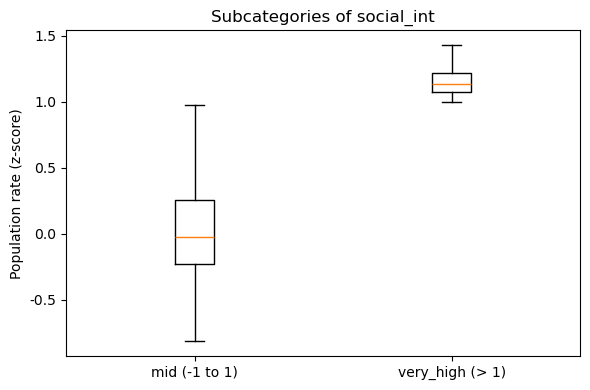

very_low_count: 0
mid_count: 3338
very_high_count: 197

--- Peri-Event PSTH significance tests per session ---

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30:


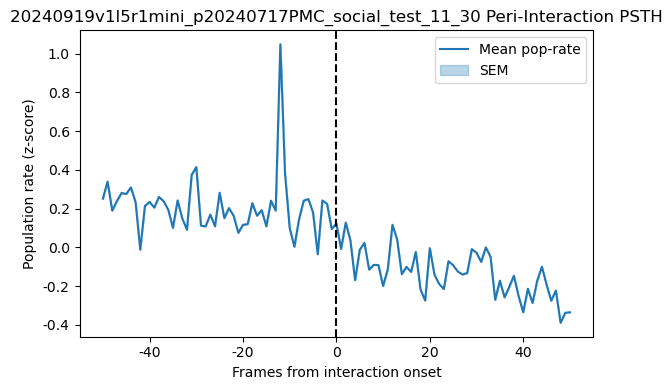

Baseline vs Suppress:  W = 0.0, p = 1.000e+00
Suppress vs Rebound:   W = 0.0, p = 1.000e+00

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33:


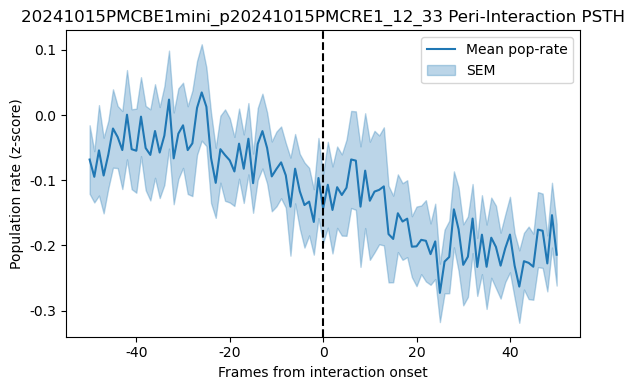

Baseline vs Suppress:  W = 25.0, p = 9.058e-02
Suppress vs Rebound:   W = 20.0, p = 4.187e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04:


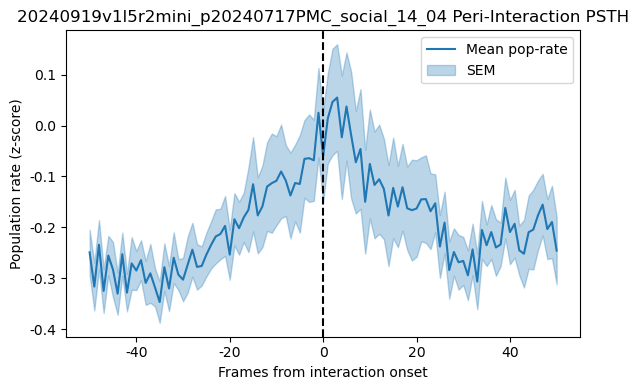

Baseline vs Suppress:  W = 16.0, p = 1.025e-02
Suppress vs Rebound:   W = 19.0, p = 1.807e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29:


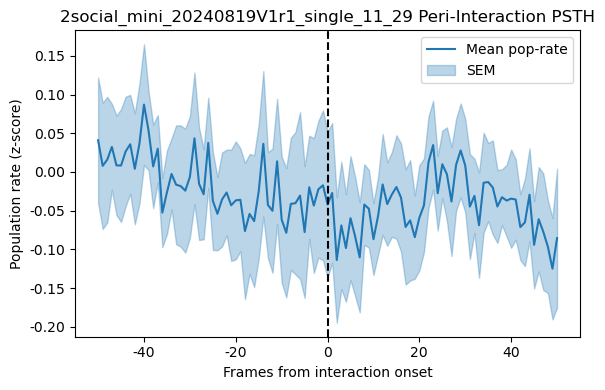

Baseline vs Suppress:  W = 15.0, p = 4.258e-01
Suppress vs Rebound:   W = 19.0, p = 7.344e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48:


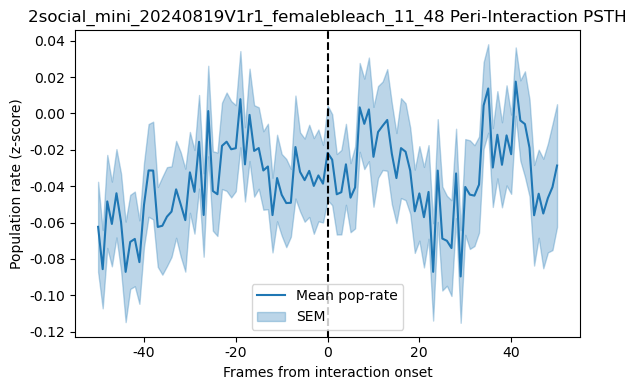

Baseline vs Suppress:  W = 445.0, p = 9.408e-01
Suppress vs Rebound:   W = 409.0, p = 6.030e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2:


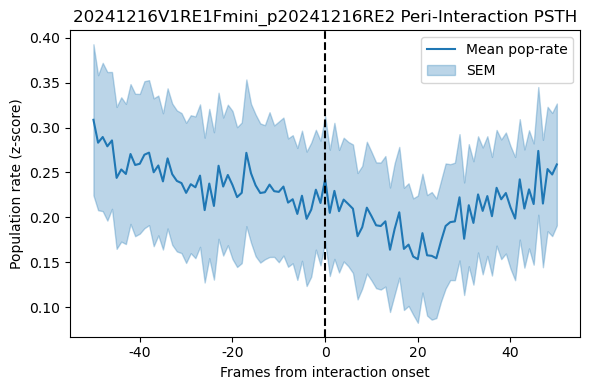

Baseline vs Suppress:  W = 401.0, p = 1.297e-01
Suppress vs Rebound:   W = 329.0, p = 2.014e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1:


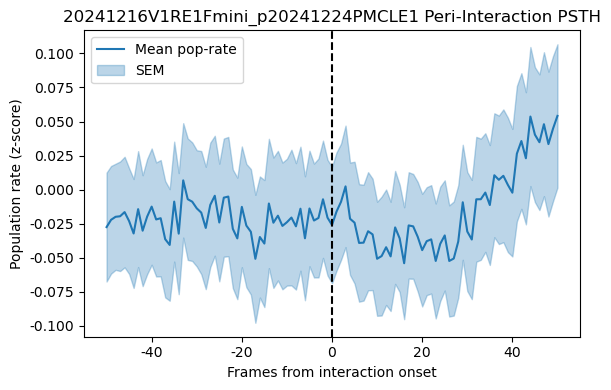

Baseline vs Suppress:  W = 1423.0, p = 2.635e-01
Suppress vs Rebound:   W = 1195.0, p = 2.840e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1:


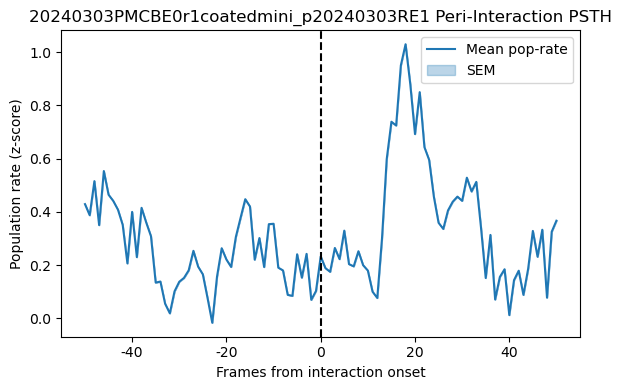

Baseline vs Suppress:  W = 0.0, p = 1.000e+00
Suppress vs Rebound:   W = 0.0, p = 1.000e+00

Analysis complete.


In [28]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu, wilcoxon
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Process and aggregate "social" vs "single" sessions
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    Given a list of session_paths, automatically determine for each whether it is social or single,
    collect pop_rate into:
      - all_pop_single
      - all_pop_social_int (interaction frames)
      - all_pop_social_non (non-interaction frames)
    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single     = []
    all_pop_social_int = []
    all_pop_social_non = []
    social_onsets_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_new)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_int = pop_rate[dist_raw <= threshold].tolist()
            pop_non = pop_rate[dist_raw > threshold].tolist()
            all_pop_social_int += pop_int
            all_pop_social_non += pop_non

            # Record indices where non-interaction → interaction transitions occur
            labels = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels[:-1] == 'non') & (labels[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_new)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_int, all_pop_social_non, social_onsets_dict

# ----------------------------------------------------------------------------
# 5. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests,
    then compute effect sizes (eta-squared for KW, rank-biserial for MWU).
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        N = len(pop_single) + len(pop_snon) + len(pop_sint)
        k = 3
        eta2 = (h_stat - k + 1) / (N - k)  # Eta-squared approximation
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}, eta² ≈ {eta2:.4f}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests and rank-biserial effect sizes
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            U, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            # Compute rank-biserial r: r = 1 - (2*U)/(n1*n2)
            n1, n2 = len(a_data), len(b_data)
            r_rb = 1 - (2*U) / (n1 * n2)
            print(f"  {a_name} vs {b_name}: U = {U:.1f}, p = {p_u:.3e}, rank-biserial r ≈ {r_rb:.4f}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Categorize "social_int" into Very Low, Mid, Very High
# ----------------------------------------------------------------------------
def categorize_social_int(pop_sint):
    """
    Given a list or array of pop_rate values during social_int,
    categorize each frame as 'very_low' (< -1), 'mid' (-1 <= <= 1), or 'very_high' (> 1).
    Return counts and also return the three subsets.
    """
    pop_sint = np.array(pop_sint)
    very_low_mask  = pop_sint < -1
    very_high_mask = pop_sint > 1
    mid_mask       = (~very_low_mask) & (~very_high_mask)

    pop_very_low  = pop_sint[very_low_mask]
    pop_mid       = pop_sint[mid_mask]
    pop_very_high = pop_sint[very_high_mask]

    counts = {
        'very_low_count': len(pop_very_low),
        'mid_count': len(pop_mid),
        'very_high_count': len(pop_very_high)
    }

    return (pop_very_low, pop_mid, pop_very_high), counts

def plot_social_int_subcategories(pop_sint):
    """
    Visualize the distribution of social_int split into Very Low, Mid, and Very High.
    """
    (pop_very_low, pop_mid, pop_very_high), counts = categorize_social_int(pop_sint)
    labels = ['very_low (< -1)', 'mid (-1 to 1)', 'very_high (> 1)']
    data = [pop_very_low, pop_mid, pop_very_high]
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Subcategories of social_int")
    plt.tight_layout()
    plt.show()

    for label, cnt in counts.items():
        print(f"{label}: {cnt}")
    return counts

# ----------------------------------------------------------------------------
# 7. Peri-Event PSTH significance tests
# ----------------------------------------------------------------------------
def analyze_psth_significance(snippets, t_window_frames=50):
    """
    Given an array `snippets` of shape (n_events, 2*t_window_frames+1),
    compute paired Wilcoxon tests for:
      - baseline (frames [-50:-10]) vs suppress (frames [-5:+5])
      - suppress ([-5:+5]) vs rebound ([+10:+30])
    """
    if snippets.size == 0:
        print("No snippets provided for PSTH analysis.")
        return

    n_events, total_len = snippets.shape
    window = (total_len - 1) // 2

    before_means = snippets[:, :window-10].mean(axis=1)          # [-50:-10]
    suppress_means = snippets[:, window-5:window+6].mean(axis=1)  # [-5:+5]
    rebound_means = snippets[:, window+10:window+31].mean(axis=1) # [10:30]

    # baseline vs suppress
    if len(before_means) == len(suppress_means) and len(before_means) > 0:
        stat1, p1 = wilcoxon(before_means, suppress_means)
        print(f"Baseline vs Suppress:  W = {stat1:.1f}, p = {p1:.3e}")
    else:
        print("Cannot test Baseline vs Suppress: insufficient data.")

    # suppress vs rebound
    if len(suppress_means) == len(rebound_means) and len(suppress_means) > 0:
        stat2, p2 = wilcoxon(suppress_means, rebound_means)
        print(f"Suppress vs Rebound:   W = {stat2:.1f}, p = {p2:.3e}")
    else:
        print("Cannot test Suppress vs Rebound: insufficient data.")

# ----------------------------------------------------------------------------
# 8. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event, and return the snippets matrix.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return np.array([])

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return np.array([])

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return snippets

# ----------------------------------------------------------------------------
# 9. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    session_paths = [
        # Social sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1",

        # Single sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54"
    ]

    threshold = 250.0  # COM distance threshold for social sessions

    # 1) Collect three groups of pop_rate and social event onsets
    pop_single, pop_sint, pop_snon, social_onsets_dict = collect_groups(session_paths, threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")

    # 2) Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    # 3) Split social_int into Very Low, Mid, Very High and visualize / count
    print("\n--- Splitting social_int into categories ---")
    counts = plot_social_int_subcategories(pop_sint)

    # 4) Optional: Plot Peri-Event PSTH and analyze significance for each social session
    print("\n--- Peri-Event PSTH significance tests per session ---")
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        snippets = plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)
        if snippets.size > 0:
            analyze_psth_significance(snippets, t_window_frames=50)

    print("\nAnalysis complete.")



=== Frame‐Level Analysis ===
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1
Proces

/tmp/ipykernel_919466/743355271.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


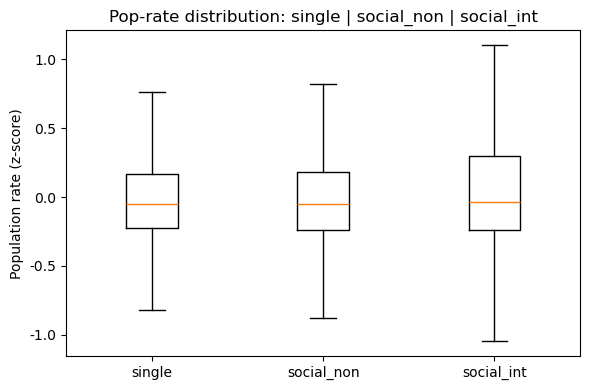

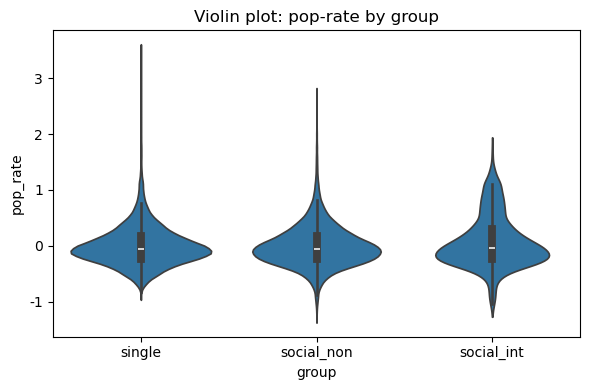

Kruskal–Wallis H = 39.186, p = 3.097e-09, eta² ≈ 0.0002
  single vs social_non: U = 3465548618.0, p = 2.019e-01, rank-biserial r ≈ -0.0036
  single vs social_int: U = 162644703.0, p = 7.813e-09, rank-biserial r ≈ 0.0520
  social_non vs social_int: U = 178746324.0, p = 2.936e-10, rank-biserial r ≈ 0.0566

--- Splitting social_int into subcategories ---


/tmp/ipykernel_919466/743355271.py:283: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


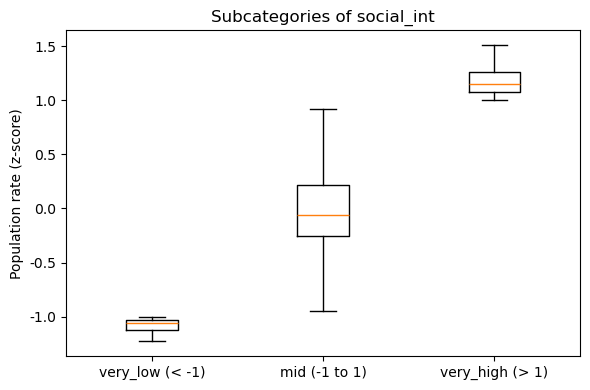

very_low_count: 26
mid_count: 4067
very_high_count: 246

=== Peri-Event PSTH & Significance (Frame‐Level) ===

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30:


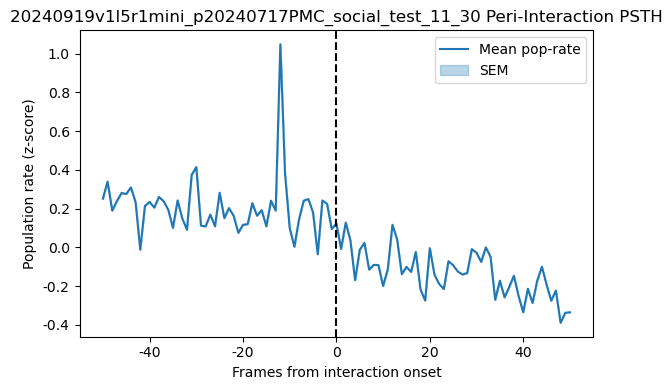

Baseline vs Suppress:  W = 0.0, p = 1.000e+00
Suppress vs Rebound:   W = 0.0, p = 1.000e+00

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33:


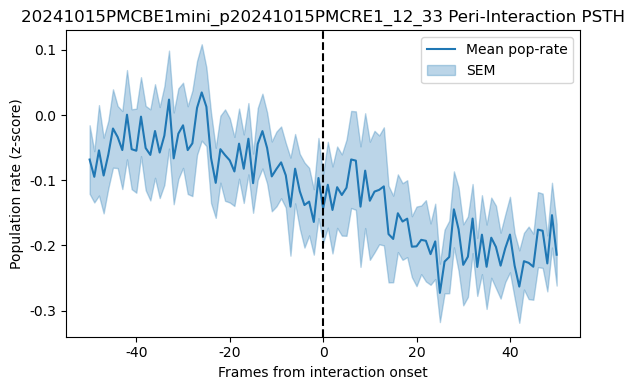

Baseline vs Suppress:  W = 25.0, p = 9.058e-02
Suppress vs Rebound:   W = 20.0, p = 4.187e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04:


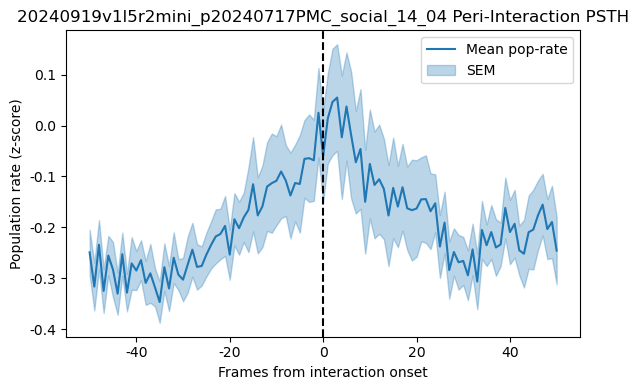

Baseline vs Suppress:  W = 16.0, p = 1.025e-02
Suppress vs Rebound:   W = 19.0, p = 1.807e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50:


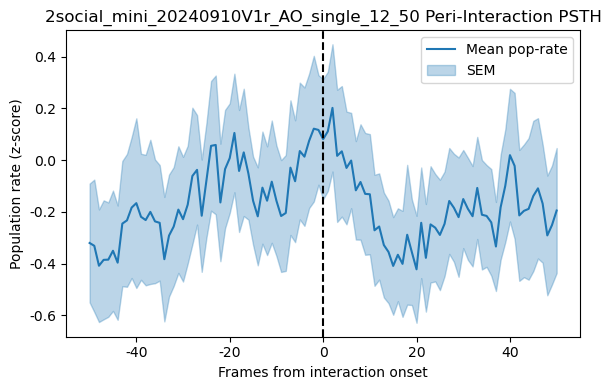

Baseline vs Suppress:  W = 14.0, p = 5.225e-02
Suppress vs Rebound:   W = 9.0, p = 1.611e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30:


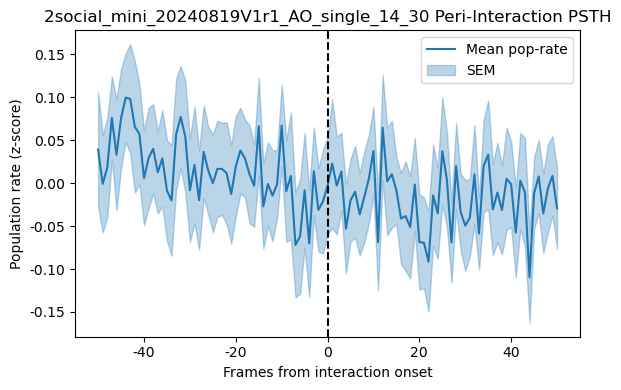

Baseline vs Suppress:  W = 60.0, p = 1.688e-01
Suppress vs Rebound:   W = 65.0, p = 2.413e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29:


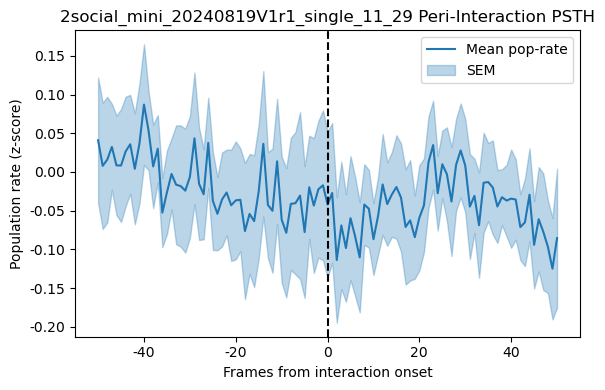

Baseline vs Suppress:  W = 15.0, p = 4.258e-01
Suppress vs Rebound:   W = 19.0, p = 7.344e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48:


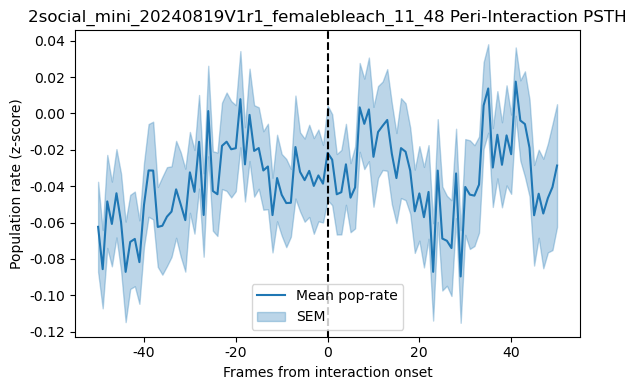

Baseline vs Suppress:  W = 445.0, p = 9.408e-01
Suppress vs Rebound:   W = 409.0, p = 6.030e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2:


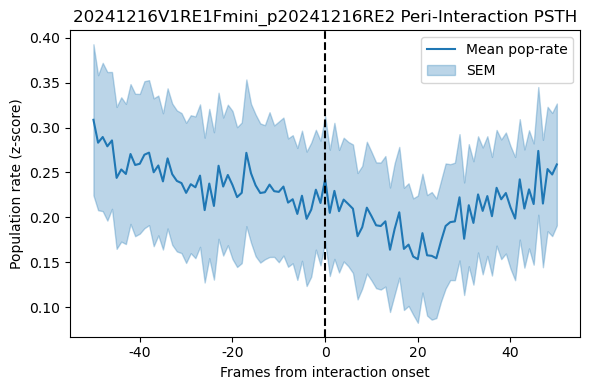

Baseline vs Suppress:  W = 401.0, p = 1.297e-01
Suppress vs Rebound:   W = 329.0, p = 2.014e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1:


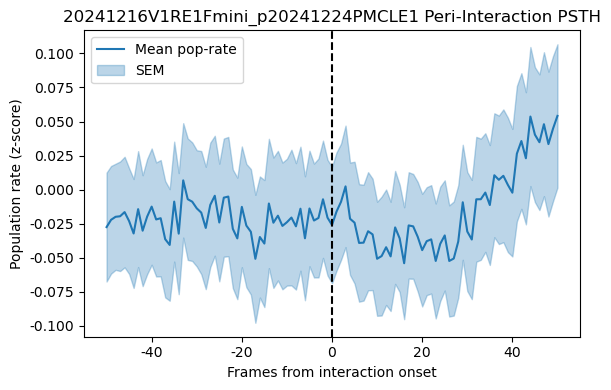

Baseline vs Suppress:  W = 1423.0, p = 2.635e-01
Suppress vs Rebound:   W = 1195.0, p = 2.840e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1:


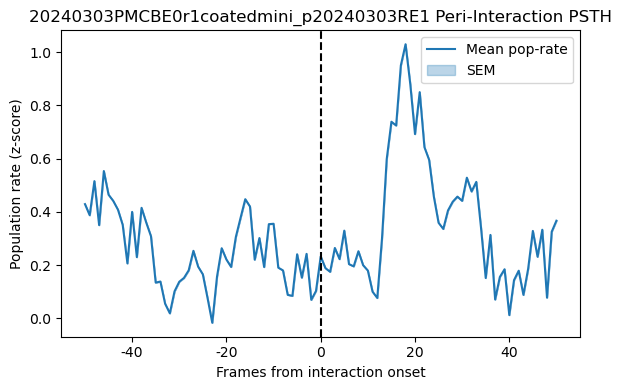

Baseline vs Suppress:  W = 0.0, p = 1.000e+00
Suppress vs Rebound:   W = 0.0, p = 1.000e+00

=== Session‐Level Analysis ===

Single means per session: [-7.977351922758506e-18, -6.351219984447823e-18, -3.814567868972689e-17, 1.5951122140758787e-17, 3.032415089721901e-17, 6.3840317678355815e-18, -1.780529956485764e-17, -1.7773288160965534e-17]
Social_non means per session: [0.0015053373006806681, 0.011093031533005449, 0.0007723596195282322, 0.0030941964664578554, 0.005107737462746283, 0.004092746710886572, -0.0015039291269231107, -0.023997401183476683, -0.033734304814783636, -0.007366544952584213]
Social_int means per session: [-0.11277272659336551, -0.0963367450279882, -0.03726847350932417, -0.07630873635187038, -0.09540804548545213, -0.1566373149087552, 0.049698281528854284, 0.29166072207610105, 0.22753024580215123, 0.42561182745785825]

--- Session‐Level Kruskal–Wallis & Mann–Whitney U ---
Session‐level Kruskal–Wallis: H = 0.958, p = 6.195e-01
Session: single vs social_non → U = 32.00

In [29]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu, wilcoxon, zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Process and aggregate "social" vs "single" sessions (frame-level)
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    Given a list of session_paths, automatically determine for each whether it is social or single,
    collect pop_rate into:
      - all_pop_single
      - all_pop_social_int (interaction frames)
      - all_pop_social_non (non-interaction frames)
    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single     = []
    all_pop_social_int = []
    all_pop_social_non = []
    social_onsets_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_new)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_int = pop_rate[dist_raw <= threshold].tolist()
            pop_non = pop_rate[dist_raw > threshold].tolist()
            all_pop_social_int += pop_int
            all_pop_social_non += pop_non

            # Record indices where non-interaction → interaction transitions occur
            labels = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels[:-1] == 'non') & (labels[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_new)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_int, all_pop_social_non, social_onsets_dict

# ----------------------------------------------------------------------------
# 5. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U + Effect Sizes
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests,
    then compute effect sizes (eta-squared for KW, rank-biserial for MWU).
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        N = len(pop_single) + len(pop_snon) + len(pop_sint)
        k = 3
        eta2 = (h_stat - k + 1) / (N - k)  # Eta-squared approximation
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}, eta² ≈ {eta2:.4f}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests and rank-biserial effect sizes
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            U, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            # Compute rank-biserial r: r = 1 - (2*U)/(n1*n2)
            n1, n2 = len(a_data), len(b_data)
            r_rb = 1 - (2 * U) / (n1 * n2)
            print(f"  {a_name} vs {b_name}: U = {U:.1f}, p = {p_u:.3e}, rank-biserial r ≈ {r_rb:.4f}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Categorize "social_int" into Very Low, Mid, Very High
# ----------------------------------------------------------------------------
def categorize_social_int(pop_sint):
    """
    Given a list or array of pop_rate values during social_int,
    categorize each frame as 'very_low' (< -1), 'mid' (-1 <= <= 1), or 'very_high' (> 1).
    Return the three subsets and their counts.
    """
    pop_sint = np.array(pop_sint)
    very_low_mask  = pop_sint < -1
    very_high_mask = pop_sint > 1
    mid_mask       = (~very_low_mask) & (~very_high_mask)

    pop_very_low  = pop_sint[very_low_mask]
    pop_mid       = pop_sint[mid_mask]
    pop_very_high = pop_sint[very_high_mask]

    counts = {
        'very_low_count': len(pop_very_low),
        'mid_count': len(pop_mid),
        'very_high_count': len(pop_very_high)
    }

    return (pop_very_low, pop_mid, pop_very_high), counts

def plot_social_int_subcategories(pop_sint):
    """
    Visualize the distribution of social_int split into Very Low (< -1), Mid (-1 to +1), and Very High (> +1).
    Print counts for each subcategory.
    """
    (pop_very_low, pop_mid, pop_very_high), counts = categorize_social_int(pop_sint)
    labels = ['very_low (< -1)', 'mid (-1 to 1)', 'very_high (> 1)']
    data = [pop_very_low, pop_mid, pop_very_high]
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Subcategories of social_int")
    plt.tight_layout()
    plt.show()

    for label, cnt in counts.items():
        print(f"{label}: {cnt}")
    return counts

# ----------------------------------------------------------------------------
# 7. Peri-Event PSTH significance tests
# ----------------------------------------------------------------------------
def analyze_psth_significance(snippets, t_window_frames=50):
    """
    Given an array `snippets` of shape (n_events, 2*t_window_frames+1),
    compute paired Wilcoxon tests for:
      - baseline (frames [-50:-10]) vs suppress (frames [-5:+5])
      - suppress ([-5:+5]) vs rebound ([+10:+30])
    """
    if snippets.size == 0:
        print("No snippets provided for PSTH analysis.")
        return

    n_events, total_len = snippets.shape
    window = (total_len - 1) // 2

    before_means = snippets[:, :window-10].mean(axis=1)          # [-50:-10]
    suppress_means = snippets[:, window-5:window+6].mean(axis=1)  # [-5:+5]
    rebound_means = snippets[:, window+10:window+31].mean(axis=1) # [10:30]

    # baseline vs suppress
    if len(before_means) == len(suppress_means) and len(before_means) > 0:
        stat1, p1 = wilcoxon(before_means, suppress_means)
        print(f"Baseline vs Suppress:  W = {stat1:.1f}, p = {p1:.3e}")
    else:
        print("Cannot test Baseline vs Suppress: insufficient data.")

    # suppress vs rebound
    if len(suppress_means) == len(rebound_means) and len(suppress_means) > 0:
        stat2, p2 = wilcoxon(suppress_means, rebound_means)
        print(f"Suppress vs Rebound:   W = {stat2:.1f}, p = {p2:.3e}")
    else:
        print("Cannot test Suppress vs Rebound: insufficient data.")

# ----------------------------------------------------------------------------
# 8. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event, and return the snippets matrix.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return np.array([])

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return np.array([])

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return snippets

# ----------------------------------------------------------------------------
# 9. Session-level mean calculations & comparisons
# ----------------------------------------------------------------------------
def collect_session_level_means(social_paths, single_paths, threshold=250.0):
    """
    For each session, compute:
      - mean pop_rate for entire single session
      - mean pop_rate during social_non and social_int for each social session
    Return three lists of means.
    """
    single_means = []
    social_non_means = []
    social_int_means = []

    # Process single sessions
    for rec_path in single_paths:
        try:
            df = load_session_data(rec_path)
            if df.index.name == 'timestamp_ms_mini':
                df = df.reset_index()
            pop_rate, df_new = process_neuron_activity(df, exclude_mapping)
            mean_single = np.nanmean(pop_rate) if pop_rate.size else np.nan
            single_means.append(mean_single)
        except Exception as e:
            print(f"Skipping single session {rec_path}: {e}")

    # Process social sessions
    for rec_path in social_paths:
        try:
            df = load_session_data(rec_path)
            if df.index.name == 'timestamp_ms_mini':
                df = df.reset_index()
            pop_rate, df_new = process_neuron_activity(df, exclude_mapping)
            dist_raw = compute_com_distance_raw(df_new)
            mask_int = dist_raw <= threshold
            mask_non = dist_raw > threshold
            mean_int = np.nanmean(pop_rate[mask_int]) if np.any(mask_int) else np.nan
            mean_non = np.nanmean(pop_rate[mask_non]) if np.any(mask_non) else np.nan
            social_int_means.append(mean_int)
            social_non_means.append(mean_non)
        except Exception as e:
            print(f"Skipping social session {rec_path}: {e}")

    return single_means, social_non_means, social_int_means

# ----------------------------------------------------------------------------
# 10. Main execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # ----------------------------------------------------------------------------
    # 10.1 Define your session lists here
    # ----------------------------------------------------------------------------
    social_sessions = [
        # Replace these with your actual social-session paths:
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
    ]

    single_sessions = [
        # Replace these with your actual single-session paths:
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54"
    ]

    threshold = 250.0  # COM distance threshold for social sessions

    # ----------------------------------------------------------------------------
    # 10.2 Frame-level analysis
    # ----------------------------------------------------------------------------
    print("\n=== Frame‐Level Analysis ===")
    all_sessions = social_sessions + single_sessions
    pop_single, pop_sint, pop_snon, social_onsets_dict = collect_groups(all_sessions, threshold)

    print(f"\nFrame counts: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    print("\n--- Splitting social_int into subcategories ---")
    counts = plot_social_int_subcategories(pop_sint)

    print("\n=== Peri-Event PSTH & Significance (Frame‐Level) ===")
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        snippets = plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)
        if snippets.size > 0:
            analyze_psth_significance(snippets, t_window_frames=50)

    # ----------------------------------------------------------------------------
    # 10.3 Session-level analysis
    # ----------------------------------------------------------------------------
    print("\n=== Session‐Level Analysis ===")
    single_means, social_non_means, social_int_means = collect_session_level_means(
        social_sessions, single_sessions, threshold
    )

    print("\nSingle means per session:", single_means)
    print("Social_non means per session:", social_non_means)
    print("Social_int means per session:", social_int_means)

    # Remove any nan before testing
    single_vals   = [v for v in single_means if not np.isnan(v)]
    social_non_vals = [v for v in social_non_means if not np.isnan(v)]
    social_int_vals = [v for v in social_int_means if not np.isnan(v)]

    print("\n--- Session‐Level Kruskal–Wallis & Mann–Whitney U ---")
    if len(single_vals) > 0 and len(social_non_vals) > 0 and len(social_int_vals) > 0:
        H_sess, p_kw_sess = kruskal(single_vals, social_non_vals, social_int_vals)
        print(f"Session‐level Kruskal–Wallis: H = {H_sess:.3f}, p = {p_kw_sess:.3e}")
    else:
        print("Cannot perform session-level Kruskal–Wallis: insufficient data in one group.")

    if len(single_vals) > 0 and len(social_non_vals) > 0:
        U1, p1 = mannwhitneyu(single_vals, social_non_vals, alternative='two-sided')
        print(f"Session: single vs social_non → U = {U1:.3f}, p = {p1:.3e}")
    else:
        print("Skipping session‐level single vs social_non: insufficient data.")

    if len(single_vals) > 0 and len(social_int_vals) > 0:
        U2, p2 = mannwhitneyu(single_vals, social_int_vals, alternative='two-sided')
        print(f"Session: single vs social_int → U = {U2:.3f}, p = {p2:.3e}")
    else:
        print("Skipping session‐level single vs social_int: insufficient data.")

    if len(social_non_vals) > 0 and len(social_int_vals) > 0:
        U3, p3 = mannwhitneyu(social_non_vals, social_int_vals, alternative='two-sided')
        print(f"Session: social_non vs social_int → U = {U3:.3f}, p = {p3:.3e}")
    else:
        print("Skipping session‐level social_non vs social_int: insufficient data.")

    print("\nAnalysis complete.")



=== Frame‐Level Analysis with Clustering ===
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37
Processing ses

/tmp/ipykernel_919466/174087118.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


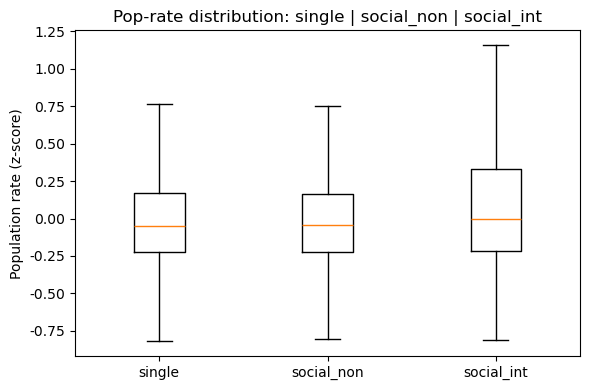

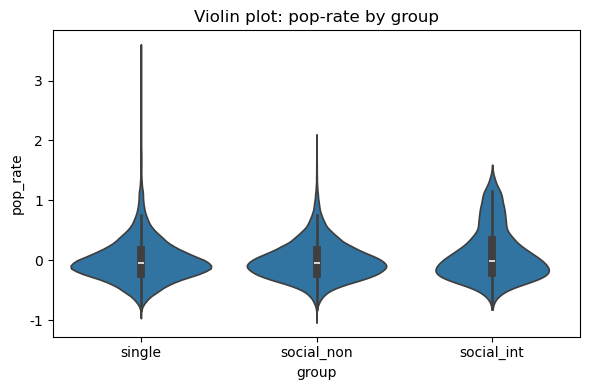

Kruskal–Wallis H = 110.758, p = 8.896e-25, eta² ≈ 0.0007
  single vs social_non: U = 2761967454.0, p = 7.623e-02, rank-biserial r ≈ 0.0053
  single vs social_int: U = 125323138.0, p = 2.136e-25, rank-biserial r ≈ 0.1034
  social_non vs social_int: U = 111669060.0, p = 6.486e-24, rank-biserial r ≈ 0.1004

--- Splitting social_int into subcategories ---


/tmp/ipykernel_919466/174087118.py:374: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


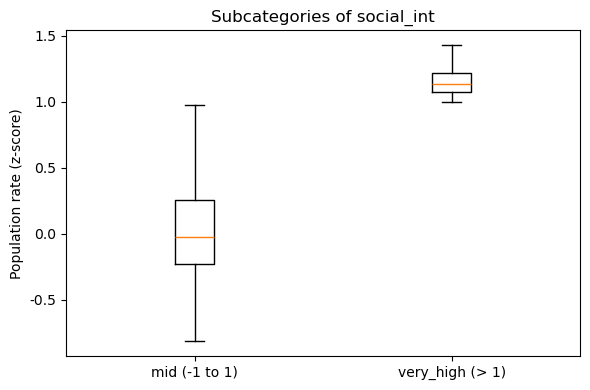

very_low_count: 0
mid_count: 3338
very_high_count: 197

Cluster 0 (n = varying by session):


/tmp/ipykernel_919466/174087118.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


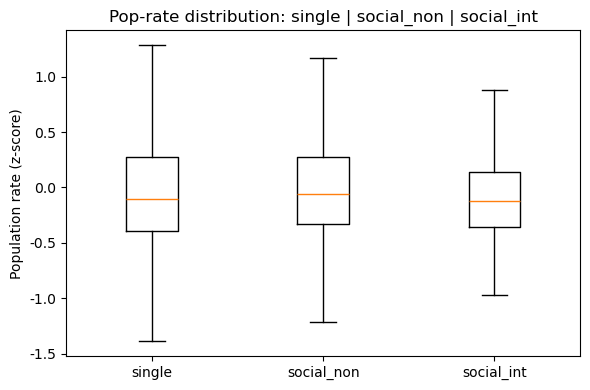

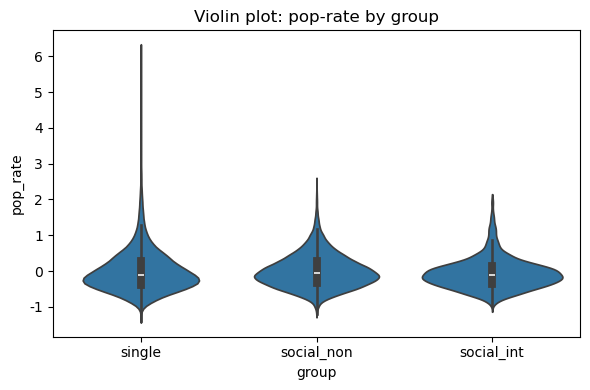

Kruskal–Wallis H = 274.889, p = 2.035e-60, eta² ≈ 0.0018
  single vs social_non: U = 2648696893.0, p = 1.646e-53, rank-biserial r ≈ 0.0461
  single vs social_int: U = 144151419.0, p = 1.588e-03, rank-biserial r ≈ -0.0313
  social_non vs social_int: U = 135107973.0, p = 6.117e-19, rank-biserial r ≈ -0.0885

Cluster 1 (n = varying by session):


/tmp/ipykernel_919466/174087118.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


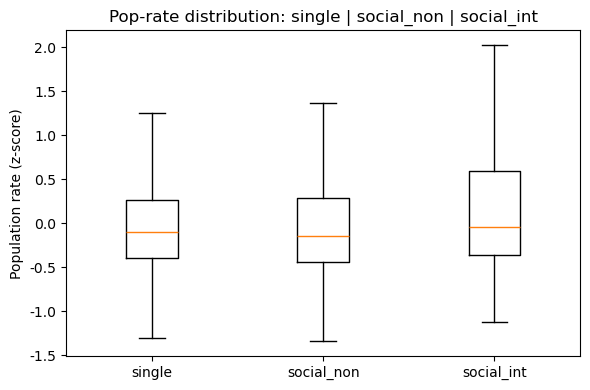

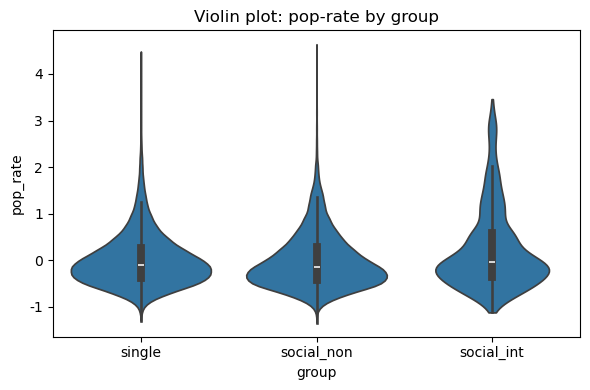

Kruskal–Wallis H = 271.182, p = 1.299e-59, eta² ≈ 0.0018
  single vs social_non: U = 2870813391.0, p = 1.029e-29, rank-biserial r ≈ -0.0339
  single vs social_int: U = 125163511.0, p = 6.333e-26, rank-biserial r ≈ 0.1045
  social_non vs social_int: U = 107624222.0, p = 1.055e-40, rank-biserial r ≈ 0.1329

Cluster 2 (n = varying by session):


/tmp/ipykernel_919466/174087118.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


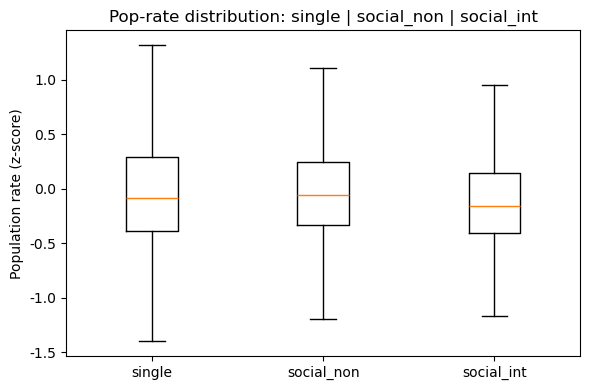

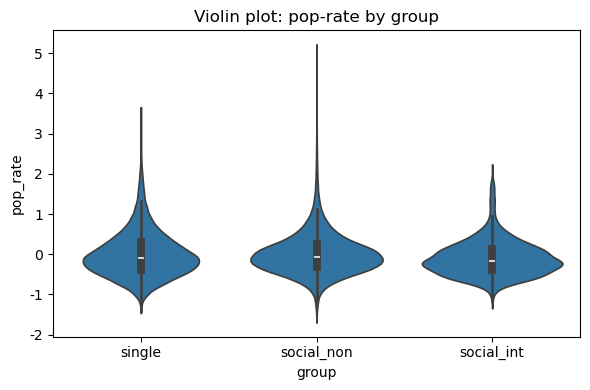

Kruskal–Wallis H = 177.542, p = 2.800e-39, eta² ≈ 0.0011
  single vs social_non: U = 2708822285.0, p = 3.176e-16, rank-biserial r ≈ 0.0244
  single vs social_int: U = 151780327.0, p = 4.830e-18, rank-biserial r ≈ -0.0859
  social_non vs social_int: U = 139236302.0, p = 2.102e-34, rank-biserial r ≈ -0.1217

=== Peri-Event PSTH & Significance (Frame‐Level) ===

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30:


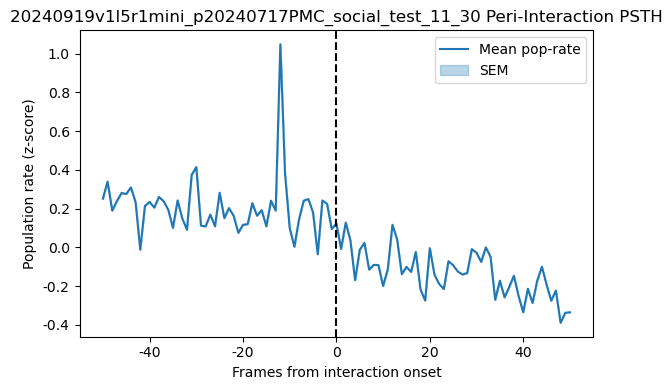

Baseline vs Suppress:  W = 0.0, p = 1.000e+00
Suppress vs Rebound:   W = 0.0, p = 1.000e+00

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33:


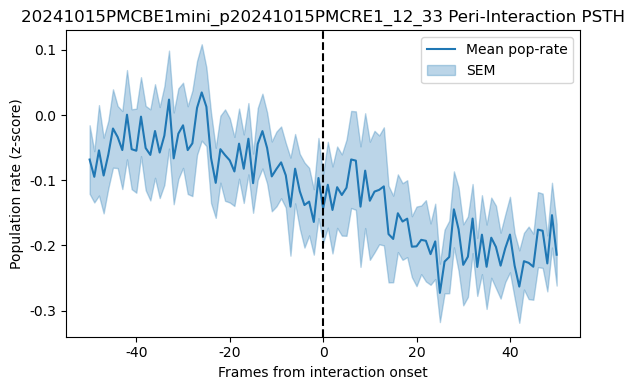

Baseline vs Suppress:  W = 25.0, p = 9.058e-02
Suppress vs Rebound:   W = 20.0, p = 4.187e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04:


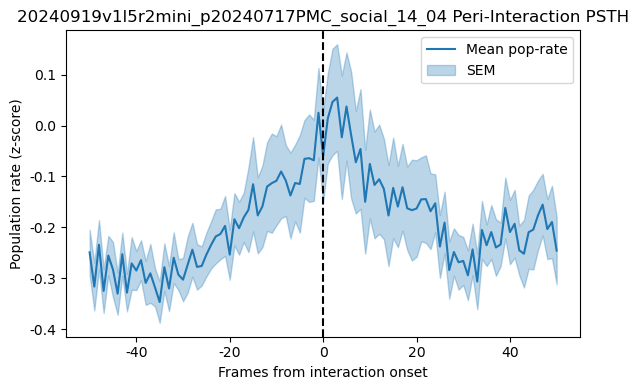

Baseline vs Suppress:  W = 16.0, p = 1.025e-02
Suppress vs Rebound:   W = 19.0, p = 1.807e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29:


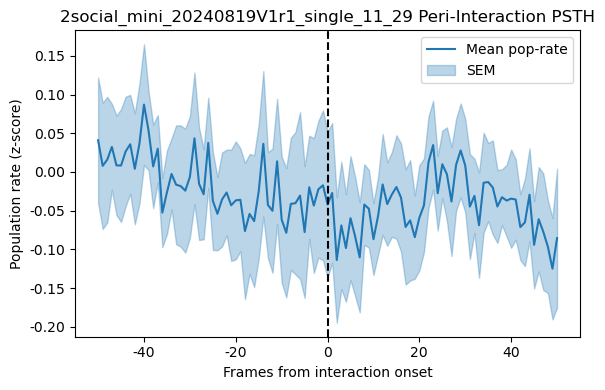

Baseline vs Suppress:  W = 15.0, p = 4.258e-01
Suppress vs Rebound:   W = 19.0, p = 7.344e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48:


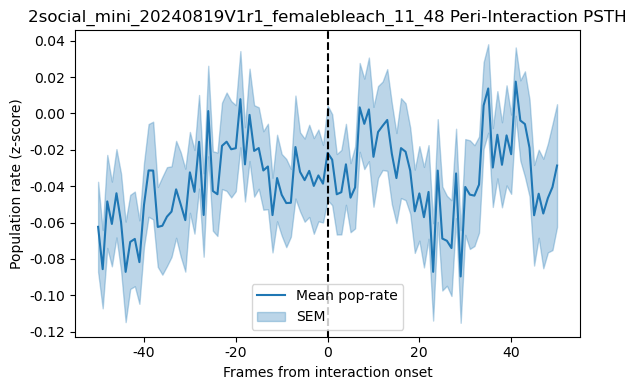

Baseline vs Suppress:  W = 445.0, p = 9.408e-01
Suppress vs Rebound:   W = 409.0, p = 6.030e-01

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2:


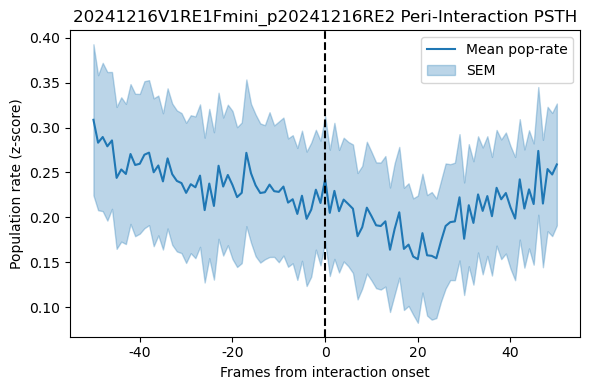

Baseline vs Suppress:  W = 401.0, p = 1.297e-01
Suppress vs Rebound:   W = 329.0, p = 2.014e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1:


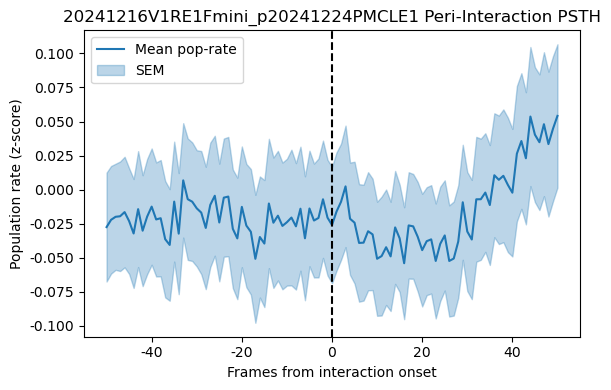

Baseline vs Suppress:  W = 1423.0, p = 2.635e-01
Suppress vs Rebound:   W = 1195.0, p = 2.840e-02

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1:


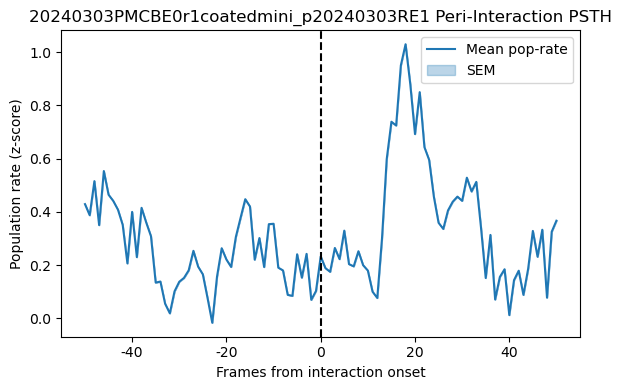

Baseline vs Suppress:  W = 0.0, p = 1.000e+00
Suppress vs Rebound:   W = 0.0, p = 1.000e+00

=== Event‐Level Analysis: Extreme Thresholds (pop_rate < -1 or > +1) ===

Session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
  Found 0 'Very Low' events, 71 'Very High' events
  No complete 'Very Low' snippets to test.
  Very High: Wilcoxon(before vs after) → W = 1273.0, p = 9.771e-01

Session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
  Found 0 'Very Low' events, 4 'Very High' events
  No complete 'Very Low' snippets to test.
  Very High: Wilcoxon(before vs after) → W = 4.0, p = 8.750e-01

Session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
  Found 0 'Very Low' events, 150 'Very High' events
  No complete 'Very Low' snippets to test.
  Very High: Wilcoxon(before vs after) → W = 5584.0, p = 8.829e-01

Session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_

In [30]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu, wilcoxon, zscore
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate, return normalized matrix
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return:
      - pop_rate: mean across normalized neurons per frame (1D array length n_frames)
      - normalized_matrix: 2D array of shape (n_neurons_kept, n_frames)
      - df_reset: DataFrame with reset index
      - neuron_cols_kept: list of column names corresponding to rows of normalized_matrix
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, np.empty((0, len(df))), df.reset_index(), []

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    filtered_cols = [neuron_cols[i] for i in range(len(neuron_cols)) if keep[i]]
    return pop_rate, normalized, df.reset_index(), filtered_cols

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Cluster neurons within a session
# ----------------------------------------------------------------------------
def cluster_neurons(normalized_matrix, n_clusters=3, n_pcs=10):
    """
    Given normalized_matrix (n_neurons x n_frames), perform PCA to reduce dimensionality,
    then cluster neurons into n_clusters using KMeans on the first n_pcs principal components.
    Return:
      - labels: array of length n_neurons indicating cluster index [0..n_clusters-1]
      - cluster_rates: array of shape (n_clusters, n_frames) giving mean activity per cluster per frame
    """
    n_neurons, n_frames = normalized_matrix.shape
    if n_neurons == 0:
        return np.array([]), np.empty((n_clusters, n_frames))

    # If fewer neurons than n_pcs, reduce n_pcs
    pcs = min(n_pcs, n_neurons)
    # PCA: fit on neurons x frames → get scores of shape (n_neurons, pcs)
    pca = PCA(n_components=pcs)
    pcscores = pca.fit_transform(normalized_matrix)  # (n_neurons, pcs)

    # KMeans clustering on neuron scores
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = kmeans.fit_predict(pcscores)  # (n_neurons, )

    # Compute cluster rates: for each cluster, average the normalized activity across neurons in cluster
    cluster_rates = np.zeros((n_clusters, n_frames))
    for c in range(n_clusters):
        members = np.where(labels == c)[0]
        if len(members) > 0:
            cluster_rates[c, :] = normalized_matrix[members, :].mean(axis=0)
        else:
            # If a cluster has no members, keep zeros
            cluster_rates[c, :] = np.zeros(n_frames)

    return labels, cluster_rates

# ----------------------------------------------------------------------------
# 5. Process and aggregate "social" vs "single" sessions, include cluster-level signals
# ----------------------------------------------------------------------------
def collect_groups_with_clusters(session_paths, threshold=250.0, n_clusters=3):
    """
    Given a list of session_paths, determine for each whether it is social or single.
    Collect:
      - pop_single: list of pop_rate frames for single sessions
      - pop_snon: list of pop_rate frames for social_non frames
      - pop_sint: list of pop_rate frames for social_int frames
    Also, for each cluster (0..n_clusters-1), collect:
      - pop_single_clusters[c]
      - pop_snon_clusters[c]
      - pop_sint_clusters[c]

    Returns:
      pop_single, pop_snon, pop_sint,
      pop_single_clusters, pop_snon_clusters, pop_sint_clusters,
      social_onsets_dict (for PSTH), cluster_labels_dict (per session → labels),
      cluster_counts_dict (neurons per cluster, per session)
    """
    # Overall lists
    pop_single = []
    pop_snon = []
    pop_sint = []

    # Cluster-level lists: each is a list of length n_clusters, each element is a list of frames
    pop_single_clusters = [[] for _ in range(n_clusters)]
    pop_snon_clusters = [[] for _ in range(n_clusters)]
    pop_sint_clusters = [[] for _ in range(n_clusters)]

    social_onsets_dict = {}      # rec_path → list of onset indices
    cluster_labels_dict = {}     # rec_path → (labels array for each neuron)
    cluster_counts_dict = {}     # rec_path → dict(cluster_index → neuron_count)

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()

        pop_rate, normalized, df_reset, neuron_cols = process_neuron_activity(df, exclude_mapping)
        # If there are no neurons kept, skip clustering
        if normalized.size == 0:
            # Still classify single vs social to collect empty signals if needed
            com_cols = [col for col in df_reset.columns if col.startswith('com')]
            if any(col.endswith('_x') for col in com_cols):
                # Could be single session
                pop_single += pop_rate.tolist()
            continue

        # Perform clustering
        labels, cluster_rates = cluster_neurons(normalized, n_clusters=n_clusters)
        cluster_labels_dict[rec_path] = labels
        counts = {c: int(np.sum(labels == c)) for c in range(n_clusters)}
        cluster_counts_dict[rec_path] = counts

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_reset.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_reset)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue

            # Single population-level
            pop_sint += pop_rate[dist_raw <= threshold].tolist()
            pop_snon += pop_rate[dist_raw > threshold].tolist()

            # Cluster-level
            for c in range(n_clusters):
                # cluster_rates[c, :] is shape (n_frames,)
                pop_sint_clusters[c] += cluster_rates[c, dist_raw <= threshold].tolist()
                pop_snon_clusters[c] += cluster_rates[c, dist_raw > threshold].tolist()

            # Record indices where non-interaction → interaction transitions occur
            labels_dist = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels_dist[:-1] == 'non') & (labels_dist[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_reset.columns and 'com_y' in df_reset.columns and 'com_z' in df_reset.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_reset)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue

            # Population-level
            pop_single += pop_rate.tolist()

            # Cluster-level
            for c in range(n_clusters):
                pop_single_clusters[c] += cluster_rates[c, :].tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return (pop_single, pop_snon, pop_sint,
            pop_single_clusters, pop_snon_clusters, pop_sint_clusters,
            social_onsets_dict, cluster_labels_dict, cluster_counts_dict)

# ----------------------------------------------------------------------------
# 6. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U + Effect Sizes
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests,
    then compute effect sizes (eta-squared for KW, rank-biserial for MWU).
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        N = len(pop_single) + len(pop_snon) + len(pop_sint)
        k = 3
        eta2 = (h_stat - k + 1) / (N - k)  # Eta-squared approximation
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}, eta² ≈ {eta2:.4f}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests and rank-biserial effect sizes
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            U, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            # Compute rank-biserial r: r = 1 - (2*U)/(n1*n2)
            n1, n2 = len(a_data), len(b_data)
            r_rb = 1 - (2 * U) / (n1 * n2)
            print(f"  {a_name} vs {b_name}: U = {U:.1f}, p = {p_u:.3e}, rank-biserial r ≈ {r_rb:.4f}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 7. Categorize "social_int" into Very Low, Mid, Very High
# ----------------------------------------------------------------------------
def categorize_social_int(pop_sint):
    """
    Given a list or array of pop_rate values during social_int,
    categorize each frame as 'very_low' (< -1), 'mid' (-1 <= <= 1), or 'very_high' (> 1).
    Return the three subsets and their counts.
    """
    pop_sint = np.array(pop_sint)
    very_low_mask  = pop_sint < -1
    very_high_mask = pop_sint > 1
    mid_mask       = (~very_low_mask) & (~very_high_mask)

    pop_very_low  = pop_sint[very_low_mask]
    pop_mid       = pop_sint[mid_mask]
    pop_very_high = pop_sint[very_high_mask]

    counts = {
        'very_low_count': len(pop_very_low),
        'mid_count': len(pop_mid),
        'very_high_count': len(pop_very_high)
    }

    return (pop_very_low, pop_mid, pop_very_high), counts

def plot_social_int_subcategories(pop_sint):
    """
    Visualize the distribution of social_int split into Very Low (< -1), Mid (-1 to +1), and Very High (> +1).
    Print counts for each subcategory.
    """
    (pop_very_low, pop_mid, pop_very_high), counts = categorize_social_int(pop_sint)
    labels = ['very_low (< -1)', 'mid (-1 to 1)', 'very_high (> 1)']
    data = [pop_very_low, pop_mid, pop_very_high]
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Subcategories of social_int")
    plt.tight_layout()
    plt.show()

    for label, cnt in counts.items():
        print(f"{label}: {cnt}")
    return counts

# ----------------------------------------------------------------------------
# 8. Peri-Event PSTH significance tests (event-level)
# ----------------------------------------------------------------------------
def analyze_psth_significance(snippets, t_window_frames=50):
    """
    Given an array `snippets` of shape (n_events, 2*t_window_frames+1),
    compute paired Wilcoxon tests for:
      - baseline (frames [-50:-10]) vs suppress (frames [-5:+5])
      - suppress ([-5:+5]) vs rebound ([+10:+30])
    """
    if snippets.size == 0:
        print("No snippets provided for PSTH analysis.")
        return

    n_events, total_len = snippets.shape
    window = (total_len - 1) // 2

    before_means = snippets[:, :window-10].mean(axis=1)          # [-50:-10]
    suppress_means = snippets[:, window-5:window+6].mean(axis=1)  # [-5:+5]
    rebound_means = snippets[:, window+10:window+31].mean(axis=1) # [10:30]

    # baseline vs suppress
    if len(before_means) == len(suppress_means) and len(before_means) > 0:
        stat1, p1 = wilcoxon(before_means, suppress_means)
        print(f"Baseline vs Suppress:  W = {stat1:.1f}, p = {p1:.3e}")
    else:
        print("Cannot test Baseline vs Suppress: insufficient data.")

    # suppress vs rebound
    if len(suppress_means) == len(rebound_means) and len(suppress_means) > 0:
        stat2, p2 = wilcoxon(suppress_means, rebound_means)
        print(f"Suppress vs Rebound:   W = {stat2:.1f}, p = {p2:.3e}")
    else:
        print("Cannot test Suppress vs Rebound: insufficient data.")

# ----------------------------------------------------------------------------
# 9. Plot Peri-Event PSTH for social interaction onsets (event-level)
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event, and return the snippets matrix.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return np.array([])

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return np.array([])

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return snippets

# ----------------------------------------------------------------------------
# 10. Event-level clustering based on extreme thresholds
# ----------------------------------------------------------------------------
def collect_extreme_onsets(pop_rate_full, threshold_low=-1.0, threshold_high=1.0, window=10):
    """
    Find frames where pop_rate < threshold_low (Very Low events) or pop_rate > threshold_high (Very High events).
    Return two lists: (low_onset_idxs, high_onset_idxs) and their corresponding snippets matrices.
    """
    low_idxs = np.where(pop_rate_full < threshold_low)[0]
    high_idxs = np.where(pop_rate_full > threshold_high)[0]

    snippets_low = []
    snippets_high = []

    for idx in low_idxs:
        start = idx - window
        end   = idx + window
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippets_low.append(pop_rate_full[start:end+1])
    for idx in high_idxs:
        start = idx - window
        end   = idx + window
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippets_high.append(pop_rate_full[start:end+1])

    return (low_idxs[:len(snippets_low)], 
            np.vstack(snippets_low) if snippets_low else np.array([]),
            high_idxs[:len(snippets_high)],
            np.vstack(snippets_high) if snippets_high else np.array([]))

# ----------------------------------------------------------------------------
# 11. Session-level mean calculations & comparisons
# ----------------------------------------------------------------------------
def collect_session_level_means(social_paths, single_paths, threshold=250.0):
    """
    For each session, compute:
      - mean pop_rate for entire single session
      - mean pop_rate during social_non and social_int for each social session
    Return three lists of means.
    """
    single_means = []
    social_non_means = []
    social_int_means = []

    # Process single sessions
    for rec_path in single_paths:
        try:
            df = load_session_data(rec_path)
            if df.index.name == 'timestamp_ms_mini':
                df = df.reset_index()
            pop_rate, _, df_new, _ = process_neuron_activity(df, exclude_mapping)
            mean_single = np.nanmean(pop_rate) if pop_rate.size else np.nan
            single_means.append(mean_single)
        except Exception as e:
            print(f"Skipping single session {rec_path}: {e}")

    # Process social sessions
    for rec_path in social_paths:
        try:
            df = load_session_data(rec_path)
            if df.index.name == 'timestamp_ms_mini':
                df = df.reset_index()
            pop_rate, _, df_new, _ = process_neuron_activity(df, exclude_mapping)
            dist_raw = compute_com_distance_raw(df_new)
            mask_int = dist_raw <= threshold
            mask_non = dist_raw > threshold
            mean_int = np.nanmean(pop_rate[mask_int]) if np.any(mask_int) else np.nan
            mean_non = np.nanmean(pop_rate[mask_non]) if np.any(mask_non) else np.nan
            social_int_means.append(mean_int)
            social_non_means.append(mean_non)
        except Exception as e:
            print(f"Skipping social session {rec_path}: {e}")

    return single_means, social_non_means, social_int_means

# ----------------------------------------------------------------------------
# 12. Main execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # ----------------------------------------------------------------------------
    # 12.1 Define your session lists here
    # ----------------------------------------------------------------------------
    social_sessions = [
        # Replace these with your actual social-session paths:
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
    ]

    single_sessions = [
        # Replace these with your actual single-session paths:
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54"
    ]

    threshold = 250.0   # COM distance threshold for social sessions
    n_clusters = 3      # Number of clusters for neuron clustering

    # ----------------------------------------------------------------------------
    # 12.2 Frame-level analysis with clustering
    # ----------------------------------------------------------------------------
    print("\n=== Frame‐Level Analysis with Clustering ===")
    all_sessions = social_sessions + single_sessions

    (pop_single, pop_snon, pop_sint,
     pop_single_clusters, pop_snon_clusters, pop_sint_clusters,
     social_onsets_dict, cluster_labels_dict, cluster_counts_dict) = \
        collect_groups_with_clusters(all_sessions, threshold=threshold, n_clusters=n_clusters)

    print(f"\nFrame counts: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    print("\n--- Splitting social_int into subcategories ---")
    counts = plot_social_int_subcategories(pop_sint)

    # Cluster-level distributions: plot per-cluster violin plots for single vs social_non vs social_int
    for c in range(n_clusters):
        print(f"\nCluster {c} (n = varying by session):")
        plot_three_group_distributions(pop_single_clusters[c], pop_sint_clusters[c], pop_snon_clusters[c])

    print("\n=== Peri-Event PSTH & Significance (Frame‐Level) ===")
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _, _, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        snippets = plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)
        if snippets.size > 0:
            analyze_psth_significance(snippets, t_window_frames=50)

    # ----------------------------------------------------------------------------
    # 12.3 Event-level analysis for extreme thresholds (Very Low / Very High)
    # ----------------------------------------------------------------------------
    print("\n=== Event‐Level Analysis: Extreme Thresholds (pop_rate < -1 or > +1) ===")
    for rec_path in social_sessions:
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _, _, _ = process_neuron_activity(df, exclude_mapping)
        low_idxs, snippets_low, high_idxs, snippets_high = collect_extreme_onsets(
            pop_rate_full, threshold_low=-1.0, threshold_high=1.0, window=10
        )
        print(f"\nSession: {rec_path}")
        print(f"  Found {len(low_idxs)} 'Very Low' events, {len(high_idxs)} 'Very High' events")

        if snippets_low.size > 0:
            before_low = snippets_low[:, :10].mean(axis=1)
            after_low  = snippets_low[:, 10:].mean(axis=1)
            statL, pL = wilcoxon(before_low, after_low)
            print(f"  Very Low: Wilcoxon(before vs after) → W = {statL}, p = {pL:.3e}")
        else:
            print("  No complete 'Very Low' snippets to test.")

        if snippets_high.size > 0:
            before_high = snippets_high[:, :10].mean(axis=1)
            after_high  = snippets_high[:, 10:].mean(axis=1)
            statH, pH = wilcoxon(before_high, after_high)
            print(f"  Very High: Wilcoxon(before vs after) → W = {statH}, p = {pH:.3e}")
        else:
            print("  No complete 'Very High' snippets to test.")

    # ----------------------------------------------------------------------------
    # 12.4 Session-level analysis
    # ----------------------------------------------------------------------------
    print("\n=== Session‐Level Analysis ===")
    single_means, social_non_means, social_int_means = collect_session_level_means(
        social_sessions, single_sessions, threshold
    )

    print("\nSingle means per session:", single_means)
    print("Social_non means per session:", social_non_means)
    print("Social_int means per session:", social_int_means)

    # Remove any nan before testing
    single_vals    = [v for v in single_means if not np.isnan(v)]
    social_non_vals = [v for v in social_non_means if not np.isnan(v)]
    social_int_vals = [v for v in social_int_means if not np.isnan(v)]

    print("\n--- Session‐Level Kruskal–Wallis & Mann–Whitney U ---")
    if len(single_vals) > 0 and len(social_non_vals) > 0 and len(social_int_vals) > 0:
        H_sess, p_kw_sess = kruskal(single_vals, social_non_vals, social_int_vals)
        print(f"Session‐level Kruskal–Wallis: H = {H_sess:.3f}, p = {p_kw_sess:.3e}")
    else:
        print("Cannot perform session-level Kruskal–Wallis: insufficient data in one group.")

    if len(single_vals) > 0 and len(social_non_vals) > 0:
        U1, p1 = mannwhitneyu(single_vals, social_non_vals, alternative='two-sided')
        print(f"Session: single vs social_non → U = {U1:.3f}, p = {p1:.3e}")
    else:
        print("Skipping session‐level single vs social_non: insufficient data.")

    if len(single_vals) > 0 and len(social_int_vals) > 0:
        U2, p2 = mannwhitneyu(single_vals, social_int_vals, alternative='two-sided')
        print(f"Session: single vs social_int → U = {U2:.3f}, p = {p2:.3e}")
    else:
        print("Skipping session‐level single vs social_int: insufficient data.")

    if len(social_non_vals) > 0 and len(social_int_vals) > 0:
        U3, p3 = mannwhitneyu(social_non_vals, social_int_vals, alternative='two-sided')
        print(f"Session: social_non vs social_int → U = {U3:.3f}, p = {p3:.3e}")
    else:
        print("Skipping session‐level social_non vs social_int: insufficient data.")

    print("\nAnalysis complete.")



=== Frame‐Level Population Analysis ===
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37
Processing session:

/tmp/ipykernel_919466/1188610654.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


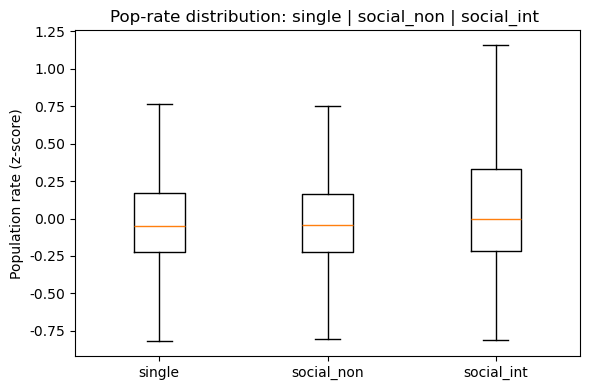

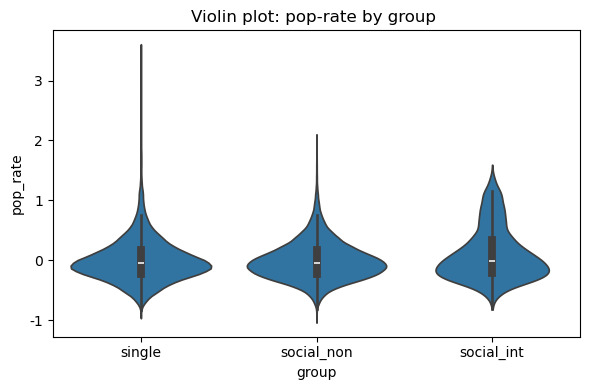

Kruskal–Wallis H = 110.758, p = 8.896e-25, eta² ≈ 0.0007
  single vs social_non: U = 2761967454.0, p = 7.623e-02, rank-biserial r ≈ 0.0053
  single vs social_int: U = 125323138.0, p = 2.136e-25, rank-biserial r ≈ 0.1034
  social_non vs social_int: U = 111669060.0, p = 6.486e-24, rank-biserial r ≈ 0.1004

--- Splitting social_int into subcategories ---


/tmp/ipykernel_919466/1188610654.py:264: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


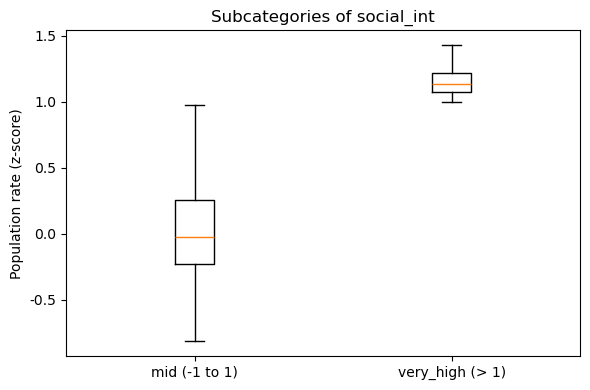

very_low_count: 0
mid_count: 3338
very_high_count: 197

=== Neuron‐Level Analysis ===
Saved per-neuron distance correlation to 'per_neuron_distance_correlation.csv'
Saved per-neuron AUC results to 'per_neuron_auc.csv'
Saved per-neuron GLM results to 'per_neuron_glm.csv'

=== Session‐Level Means Comparison ===

Single means per session: [-7.977351922758506e-18, -6.351219984447823e-18, -3.814567868972689e-17, 1.5951122140758787e-17, 3.032415089721901e-17, 6.3840317678355815e-18, -1.780529956485764e-17, -1.7773288160965534e-17]
Social_non means per session: [0.0015053373006806681, 0.011093031533005449, 0.0007723596195282322, 0.004092746710886572, -0.0015039291269231107, -0.023997401183476683, -0.033734304814783636, -0.007366544952584213]
Social_int means per session: [-0.11277272659336551, -0.0963367450279882, -0.03726847350932417, -0.1566373149087552, 0.049698281528854284, 0.29166072207610105, 0.22753024580215123, 0.42561182745785825]
Session-level Kruskal–Wallis: H = 0.000, p = 1.000e+0

In [35]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, mannwhitneyu, kruskal, zscore
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from statsmodels.stats.multitest import multipletests

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 in rec_path/MIR_Aligned,
    attach session_id, recording_date, experiment, session_path, file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity: exclude low-variance, z-score, return pop_rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    - Exclude neurons whose ROI index is in exclude_dict.
    - Remove bottom 5% variance neurons.
    - z-score each remaining neuron trace (axis=1).
    Returns:
      pop_rate: (n_frames,)
      normalized: (n_neurons_kept, n_frames)
      df_reset: DataFrame with reset index
      neuron_cols_kept: list of column names for each row of normalized
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, np.empty((0, len(df))), df.reset_index(), []
    activity = df[neuron_cols].values.T  # (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    filtered_cols = [neuron_cols[i] for i in range(len(neuron_cols)) if keep[i]]
    return pop_rate, normalized, df.reset_index(), filtered_cols

# ----------------------------------------------------------------------------
# 3. Compute COM distance (social) or COM speed (single)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes 'comX_x', 'comX_y', 'comX_z'.
    Take the first two prefixes p1, p2, compute Euclidean distance per frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("Need ≥2 'com' prefixes for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

def compute_com_speed(df_new):
    """
    For single session: requires com_x, com_y, com_z.
    Compute per-frame displacement magnitude (first frame difference = 0).
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session needs 'com_x','com_y','com_z'.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Collect groups: population-level & store normalized matrices for neuron-level
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    For each rec_path:
      - load data & preprocess neurons
      - if social (≥2 com prefixes): compute dist_raw, split pop_rate into pop_sint & pop_snon
      - if single (has com_x,y,z but <2 prefixes): all pop_rate → pop_single
      - record social_onsets (non→int transitions) for PSTH if needed
      - store normalized matrix & neuron_cols for neuron-level analysis
    Returns:
      pop_single, pop_snon, pop_sint,
      social_onsets_dict: {rec_path: [onset_idxs...]},
      neuron_data_dict: {rec_path: (normalized, neuron_cols_kept)}
    """
    pop_single = []
    pop_snon = []
    pop_sint = []
    social_onsets_dict = {}
    neuron_data_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()

        pop_rate, normalized, df_reset, neuron_cols = process_neuron_activity(df, exclude_mapping)
        neuron_data_dict[rec_path] = (normalized, neuron_cols)

        # Detect com prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_reset.columns if col.startswith('com') and '_' in col})
        if len(com_prefixes) >= 2:
            # Social session
            try:
                dist_raw = compute_com_distance_raw(df_reset)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_sint += pop_rate[dist_raw <= threshold].tolist()
            pop_snon += pop_rate[dist_raw > threshold].tolist()
            labels_dist = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels_dist[:-1] == 'non') & (labels_dist[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_reset.columns and 'com_y' in df_reset.columns and 'com_z' in df_reset.columns:
            # Single session
            try:
                _ = compute_com_speed(df_reset)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: neither social nor single (missing 'com' columns).")
            continue

    return pop_single, pop_snon, pop_sint, social_onsets_dict, neuron_data_dict

# ----------------------------------------------------------------------------
# 5. Population‐level plotting & statistics
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon, title_suffix=""):
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title(f"Pop-rate distribution: single | social_non | social_int {title_suffix}")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title(f"Violin plot: pop-rate by group {title_suffix}")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        N = len(pop_single) + len(pop_snon) + len(pop_sint)
        k = 3
        eta2 = (h_stat - k + 1) / (N - k)  # approximate eta²
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}, eta² ≈ {eta2:.4f}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U + rank-biserial r
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            U, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            n1, n2 = len(a_data), len(b_data)
            r_rb = 1 - (2 * U) / (n1 * n2)
            print(f"  {a_name} vs {b_name}: U = {U:.1f}, p = {p_u:.3e}, rank-biserial r ≈ {r_rb:.4f}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Split social_int into Very Low / Mid / Very High
# ----------------------------------------------------------------------------
def categorize_social_int(pop_sint):
    pop_sint = np.array(pop_sint)
    very_low_mask  = pop_sint < -1
    very_high_mask = pop_sint > 1
    mid_mask       = (~very_low_mask) & (~very_high_mask)
    pop_very_low  = pop_sint[very_low_mask]
    pop_mid       = pop_sint[mid_mask]
    pop_very_high = pop_sint[very_high_mask]
    counts = {
        'very_low_count': len(pop_very_low),
        'mid_count': len(pop_mid),
        'very_high_count': len(pop_very_high)
    }
    return (pop_very_low, pop_mid, pop_very_high), counts

def plot_social_int_subcategories(pop_sint):
    (pop_very_low, pop_mid, pop_very_high), counts = categorize_social_int(pop_sint)
    labels = ['very_low (< -1)', 'mid (-1 to 1)', 'very_high (> 1)']
    data = [pop_very_low, pop_mid, pop_very_high]
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Subcategories of social_int")
    plt.tight_layout()
    plt.show()

    for label, cnt in counts.items():
        print(f"{label}: {cnt}")
    return counts

# ----------------------------------------------------------------------------
# 7. Per-neuron Pearson correlation with distance (social)
# ----------------------------------------------------------------------------
def per_neuron_distance_correlation(neuron_matrix, dist_raw):
    """
    For each neuron (row in neuron_matrix), compute Pearson r & p between its trace and dist_raw.
    Returns DataFrame with columns: neuron_idx, pearson_r, pearson_p, pearson_p_fdr, signif
    """
    n_neurons, n_frames = neuron_matrix.shape
    results = []
    for i in range(n_neurons):
        trace = neuron_matrix[i, :]
        valid = ~np.isnan(trace) & ~np.isnan(dist_raw)
        if valid.sum() < 10:
            continue
        r_val, p_val = pearsonr(trace[valid], dist_raw[valid])
        results.append({'neuron': i, 'pearson_r': r_val, 'pearson_p': p_val})

    df = pd.DataFrame(results)
    if not df.empty:
        reject, pvals_corr, _, _ = multipletests(df['pearson_p'].values, alpha=0.05, method='fdr_bh')
        df['pearson_p_fdr'] = pvals_corr
        df['signif'] = reject
    else:
        df['pearson_p_fdr'] = []
        df['signif'] = []
    return df

# ----------------------------------------------------------------------------
# 8. Per-neuron AUC classification (social_int vs non_int)
# ----------------------------------------------------------------------------
def per_neuron_auc(neuron_matrix, binary_label):
    """
    For each neuron (row), compute AUC = roc_auc_score(binary_label, trace).
    Then compute Mann–Whitney U between trace[int==1] and trace[int==0] to get p-value & r.
    Returns DataFrame: neuron_idx, AUC, p_mwu, r_rb, p_mwu_fdr, signif
    """
    n_neurons, n_frames = neuron_matrix.shape
    idx_int    = np.where(binary_label == 1)[0]
    idx_nonint = np.where(binary_label == 0)[0]
    results = []
    for i in range(n_neurons):
        trace = neuron_matrix[i, :]
        if len(idx_int) < 5 or len(idx_nonint) < 5:
            continue
        try:
            auc = roc_auc_score(binary_label, trace)
        except ValueError:
            continue
        try:
            U, p_val = mannwhitneyu(trace[idx_int], trace[idx_nonint], alternative='two-sided')
            n1, n2 = len(idx_int), len(idx_nonint)
            r_rb = 1 - (2 * U) / (n1 * n2)
        except ValueError:
            p_val = np.nan
            r_rb = np.nan
        results.append({'neuron': i, 'AUC': auc, 'p_mwu': p_val, 'r_rb': r_rb})

    df = pd.DataFrame(results)
    if not df.empty:
        reject, pvals_corr, _, _ = multipletests(df['p_mwu'].values, alpha=0.05, method='fdr_bh')
        df['p_mwu_fdr'] = pvals_corr
        df['signif'] = reject
    else:
        df['p_mwu_fdr'] = []
        df['signif'] = []
    return df

# ----------------------------------------------------------------------------
# 9. Per-neuron GLM regression (continuous or binary predictor)
# ----------------------------------------------------------------------------
def per_neuron_glm(neuron_matrix, predictor, predictor_name="social", alpha=0.05):
    """
    Fit a simple GLM for each neuron: trace ~ 1 + predictor.
    predictor: length n_frames array (continuous or 0/1).
    Returns DataFrame: neuron_idx, beta1, p1, beta1_fdr, signif
    """
    n_neurons, n_frames = neuron_matrix.shape
    results = []
    for i in range(n_neurons):
        trace = neuron_matrix[i, :]
        valid = ~np.isnan(trace) & ~np.isnan(predictor)
        if valid.sum() < 10:
            continue
        y = trace[valid]
        X = sm.add_constant(predictor[valid])
        try:
            model = sm.GLM(y, X, family=sm.families.Gaussian())
            res = model.fit()
            beta1 = res.params[1]
            p1 = res.pvalues[1]
        except (ValueError, PerfectSeparationError):
            continue
        results.append({'neuron': i, 'beta1': beta1, 'p1': p1})

    df = pd.DataFrame(results)
    if not df.empty:
        reject, pvals_corr, _, _ = multipletests(df['p1'].values, alpha=alpha, method='fdr_bh')
        df['p1_fdr'] = pvals_corr
        df['signif'] = reject
    else:
        df['p1_fdr'] = []
        df['signif'] = []
    return df

# ----------------------------------------------------------------------------
# 10. Session-level means (for completeness)
# ----------------------------------------------------------------------------
def collect_session_level_means(social_paths, single_paths, threshold=250.0):
    single_means = []
    social_non_means = []
    social_int_means = []

    for rec_path in single_paths:
        try:
            df = load_session_data(rec_path)
            if df.index.name == 'timestamp_ms_mini':
                df = df.reset_index()
            pop_rate, _, _, _ = process_neuron_activity(df, exclude_mapping)
            single_means.append(np.nanmean(pop_rate) if pop_rate.size else np.nan)
        except Exception as e:
            print(f"Skipping single session {rec_path}: {e}")

    for rec_path in social_paths:
        try:
            df = load_session_data(rec_path)
            if df.index.name == 'timestamp_ms_mini':
                df = df.reset_index()
            pop_rate, _, df_new, _ = process_neuron_activity(df, exclude_mapping)
            dist_raw = compute_com_distance_raw(df_new)
            mask_int = dist_raw <= threshold
            mask_non = dist_raw > threshold
            social_int_means.append(np.nanmean(pop_rate[mask_int]) if np.any(mask_int) else np.nan)
            social_non_means.append(np.nanmean(pop_rate[mask_non]) if np.any(mask_non) else np.nan)
        except Exception as e:
            print(f"Skipping social session {rec_path}: {e}")

    return single_means, social_non_means, social_int_means

# ----------------------------------------------------------------------------
# 11. Main execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # -------------------------------
    # 11.1 Define your session paths
    # -------------------------------
    social_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
    ]

    single_sessions = [
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54"
    ]

    threshold = 250.0  # COM distance threshold
    all_sessions = social_sessions + single_sessions

    # ------------------------------------------
    # 11.2 Frame-level population analysis
    # ------------------------------------------
    print("\n=== Frame‐Level Population Analysis ===")
    pop_single, pop_snon, pop_sint, social_onsets_dict, neuron_data_dict = collect_groups(all_sessions, threshold)
    print(f"\nFrame counts: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    print("\n--- Splitting social_int into subcategories ---")
    _ = plot_social_int_subcategories(pop_sint)

    # ------------------------------------------
    # 11.3 Neuron-level analysis (continuous & binary & GLM)
    # ------------------------------------------
    print("\n=== Neuron‐Level Analysis ===")
    all_corr_results = []
    all_auc_results = []
    all_glm_results = []

    for rec_path in all_sessions:
        normalized, neuron_cols = neuron_data_dict.get(rec_path, (np.empty((0,0)), []))
        if normalized.size == 0:
            continue

        # Reload to compute dist_raw for social sessions
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, _, df_new, _ = process_neuron_activity(df, exclude_mapping)

        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        if len(com_prefixes) >= 2:
            # Social session: compute dist_raw
            dist_raw = compute_com_distance_raw(df_new)
            # Continuous correlation
            df_corr = per_neuron_distance_correlation(normalized, dist_raw)
            df_corr['session_path'] = rec_path
            all_corr_results.append(df_corr)

            # Binary label: social_int (1) vs non_int (0)
            binary_label = (dist_raw <= threshold).astype(int)
            df_auc = per_neuron_auc(normalized, binary_label)
            df_auc['session_path'] = rec_path
            all_auc_results.append(df_auc)

            # GLM regression with continuous predictor = dist_raw (z-scored)
            cont_pred = (dist_raw - np.nanmean(dist_raw)) / np.nanstd(dist_raw) if np.nanstd(dist_raw) > 0 else dist_raw
            df_glm_cont = per_neuron_glm(normalized, cont_pred, predictor_name='dist_raw')
            df_glm_cont['session_path'] = rec_path
            all_glm_results.append(df_glm_cont)

            # GLM regression with binary predictor = social_int
            df_glm_bin = per_neuron_glm(normalized, binary_label, predictor_name='social_int')
            df_glm_bin['session_path'] = rec_path
            all_glm_results.append(df_glm_bin)

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # Single session: no dist_raw, but AUC & GLM on binary_label=0 for all frames
            n_frames = normalized.shape[1]
            binary_label = np.zeros(n_frames, dtype=int)
            df_auc = per_neuron_auc(normalized, binary_label)
            df_auc['session_path'] = rec_path
            all_auc_results.append(df_auc)

            cont_pred = np.zeros(n_frames)
            df_glm_cont = per_neuron_glm(normalized, cont_pred, predictor_name='dist_raw_single')
            df_glm_cont['session_path'] = rec_path
            all_glm_results.append(df_glm_cont)

            df_glm_bin = per_neuron_glm(normalized, binary_label, predictor_name='social_int_single')
            df_glm_bin['session_path'] = rec_path
            all_glm_results.append(df_glm_bin)

        else:
            continue

    # Concatenate and save neuron-level results
    if all_corr_results:
        df_all_corr = pd.concat(all_corr_results, ignore_index=True)
        df_all_corr.to_csv("per_neuron_distance_correlation.csv", index=False)
        print("Saved per-neuron distance correlation to 'per_neuron_distance_correlation.csv'")

    if all_auc_results:
        df_all_auc = pd.concat(all_auc_results, ignore_index=True)
        df_all_auc.to_csv("per_neuron_auc.csv", index=False)
        print("Saved per-neuron AUC results to 'per_neuron_auc.csv'")

    if all_glm_results:
        df_all_glm = pd.concat(all_glm_results, ignore_index=True)
        df_all_glm.to_csv("per_neuron_glm.csv", index=False)
        print("Saved per-neuron GLM results to 'per_neuron_glm.csv'")

    # ------------------------------------------
    # 11.4 Session-level means
    # ------------------------------------------
    print("\n=== Session‐Level Means Comparison ===")
    single_means, social_non_means, social_int_means = collect_session_level_means(
        social_sessions, single_sessions, threshold
    )
    print("\nSingle means per session:", single_means)
    print("Social_non means per session:", social_non_means)
    print("Social_int means per session:", social_int_means)

    single_vals    = [v for v in single_means    if not np.isnan(v)]
    social_non_vals = [v for v in social_non_means if not np.isnan(v)]
    social_int_vals = [v for v in social_int_means if not np.isnan(v)]

    if len(single_vals) and len(social_non_vals) and len(social_int_vals):
        H_sess, p_kw_sess = kruskal(single_vals, social_non_vals, social_int_vals)
        print(f"Session-level Kruskal–Wallis: H = {H_sess:.3f}, p = {p_kw_sess:.3e}")
    else:
        print("Skipping session-level Kruskal–Wallis (insufficient data).")

    if len(single_vals) and len(social_non_vals):
        U1, p1 = mannwhitneyu(single_vals, social_non_vals, alternative='two-sided')
        print(f"Session: single vs social_non → U = {U1:.3f}, p = {p1:.3e}")
    else:
        print("Skipping session-level single vs social_non.")

    if len(single_vals) and len(social_int_vals):
        U2, p2 = mannwhitneyu(single_vals, social_int_vals, alternative='two-sided')
        print(f"Session: single vs social_int → U = {U2:.3f}, p = {p2:.3e}")
    else:
        print("Skipping session-level single vs social_int.")

    if len(social_non_vals) and len(social_int_vals):
        U3, p3 = mannwhitneyu(social_non_vals, social_int_vals, alternative='two-sided')
        print(f"Session: social_non vs social_int → U = {U3:.3f}, p = {p3:.3e}")
    else:
        print("Skipping session-level social_non vs social_int.")

    print("\nAnalysis complete.")


In [36]:
import pandas as pd

# 1. 读取 per_neuron_distance_correlation.csv
df_corr = pd.read_csv("per_neuron_distance_correlation.csv")

# 展示前 5 行
print("=== Distance Correlation (first 5 rows) ===")
print(df_corr.head(), "\n")

# 筛选出显著且 |pearson_r| ≥ 0.3 的 neuron
df_corr_sig = df_corr[(df_corr['signif'] == True) & (df_corr['pearson_r'].abs() >= 0.3)]
print(f"Distance‐corr: {len(df_corr_sig)} neurons with |r| ≥ 0.3 and FDR‐corrected p < 0.05")
print(df_corr_sig[['session_path', 'neuron', 'pearson_r', 'pearson_p_fdr']].to_string(index=False), "\n")


# 2. 读取 per_neuron_auc.csv
df_auc = pd.read_csv("per_neuron_auc.csv")

print("=== AUC Results (first 5 rows) ===")
print(df_auc.head(), "\n")

# 筛选出显著且 AUC ≥ 0.7 的 neuron
df_auc_sig = df_auc[(df_auc['signif'] == True) & (df_auc['AUC'] >= 0.7)]
print(f"AUC: {len(df_auc_sig)} neurons with AUC ≥ 0.7 and FDR‐corrected p < 0.05")
print(df_auc_sig[['session_path', 'neuron', 'AUC', 'p_mwu_fdr']].to_string(index=False), "\n")


# 3. 读取 per_neuron_glm.csv
df_glm = pd.read_csv("per_neuron_glm.csv")

print("=== GLM Results (first 5 rows) ===")
print(df_glm.head(), "\n")

# 假设你想筛选出绝对β1 ≥ 0.3 且显著的 neuron
df_glm_sig = df_glm[(df_glm['signif'] == True) & (df_glm['beta1'].abs() >= 0.3)]
print(f"GLM: {len(df_glm_sig)} neurons with |β1| ≥ 0.3 and FDR‐corrected p < 0.05")
print(df_glm_sig[['session_path', 'neuron', 'beta1', 'p1_fdr']].to_string(index=False), "\n")


# 如果想把每个表格完整地加载并返回 DataFrame 对象，可以执行以下函数：
def load_and_filter_results():
    results = {}

    # 读取并过滤 distance correlation
    df_corr = pd.read_csv("per_neuron_distance_correlation.csv")
    df_corr_sig = df_corr[(df_corr['signif'] == True) & (df_corr['pearson_r'].abs() >= 0.3)]
    results['distance_corr_all'] = df_corr
    results['distance_corr_sig'] = df_corr_sig

    # 读取并过滤 AUC
    df_auc = pd.read_csv("per_neuron_auc.csv")
    df_auc_sig = df_auc[(df_auc['signif'] == True) & (df_auc['AUC'] >= 0.7)]
    results['auc_all'] = df_auc
    results['auc_sig'] = df_auc_sig

    # 读取并过滤 GLM
    df_glm = pd.read_csv("per_neuron_glm.csv")
    df_glm_sig = df_glm[(df_glm['signif'] == True) & (df_glm['beta1'].abs() >= 0.3)]
    results['glm_all'] = df_glm
    results['glm_sig'] = df_glm_sig

    return results

# 调用示例
res = load_and_filter_results()
print("Loaded and filtered results. Keys:", res.keys())


=== Distance Correlation (first 5 rows) ===
   neuron  pearson_r     pearson_p  pearson_p_fdr  signif  \
0       0   0.083843  2.134004e-22   6.402012e-22    True   
1       1   0.120088  2.387642e-44   1.671350e-43    True   
2       2   0.043972  3.411670e-07   4.622262e-07    True   
3       3  -0.083200  4.449420e-22   1.245838e-21    True   
4       4  -0.082606  8.720090e-22   2.289023e-21    True   

                                        session_path  
0  /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/...  
1  /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/...  
2  /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/...  
3  /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/...  
4  /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/...   

Distance‐corr: 18 neurons with |r| ≥ 0.3 and FDR‐corrected p < 0.05
                                                                              session_path  neuron  pearson_r  pearson_p_fdr
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini

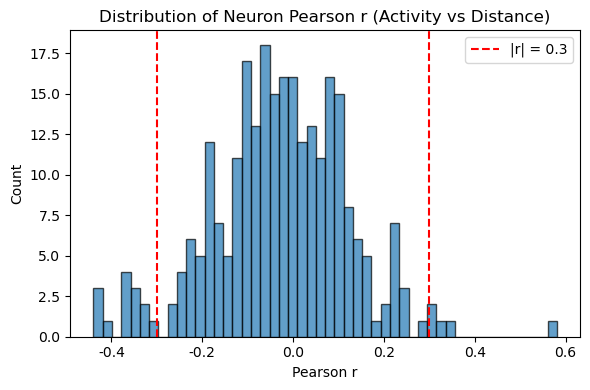

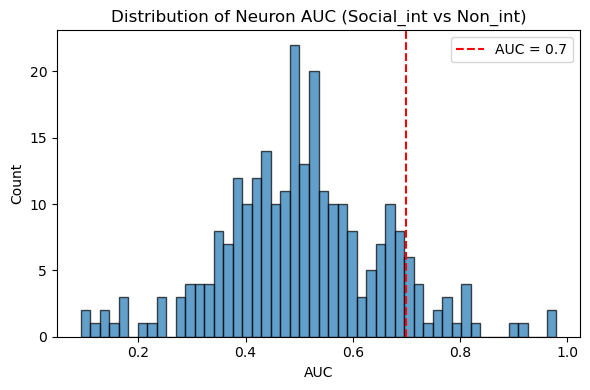

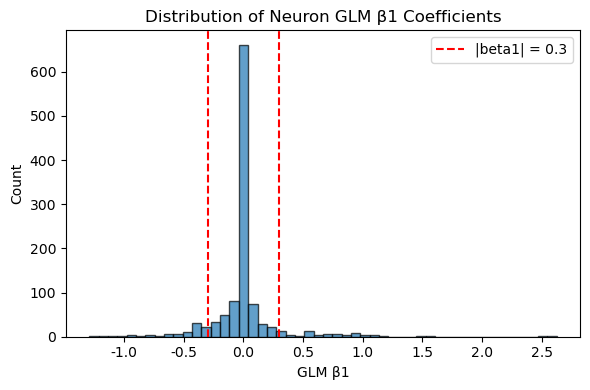

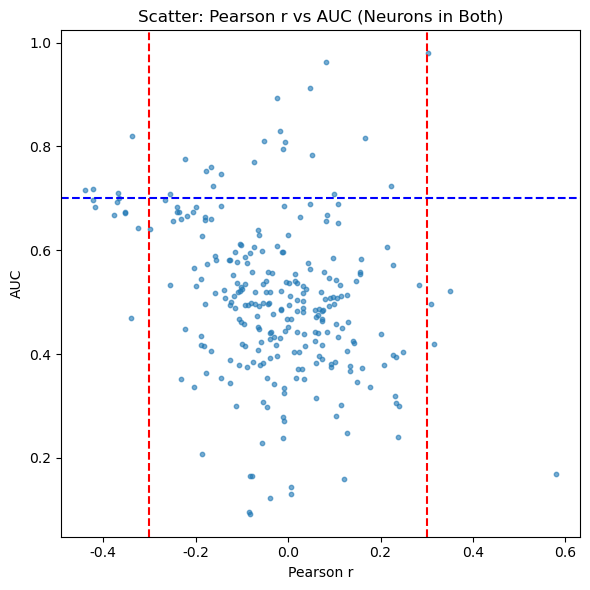

=== Significant Neuron Counts per Session ===
                                                    distance_corr_sig  \
session_path                                                            
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2...                 41   
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2...                 38   
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/2...                 36   
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/2...                 15   
/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/2...                 30   
/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/2...                 13   
/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/2...                 32   
/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/2...                 27   

                                                    AUC_sig  GLM_sig  
session_path                                                          
/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2...       25       65  
/data/big_

/tmp/ipykernel_919466/1701219775.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


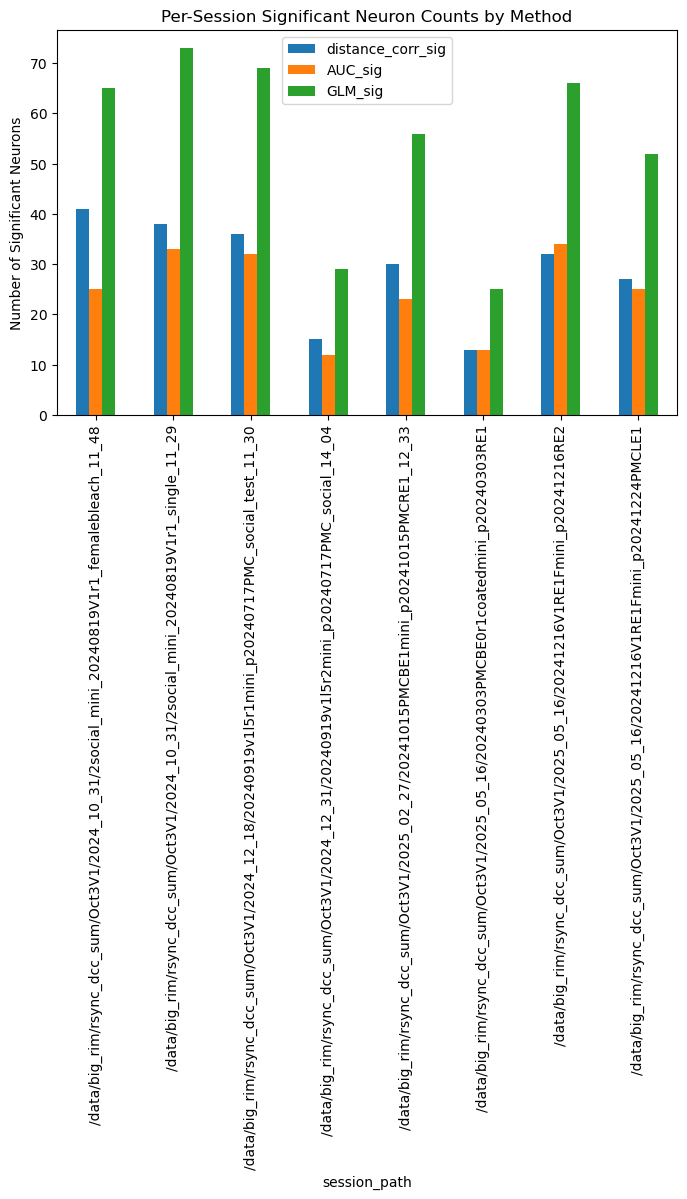

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load per_neuron_distance_correlation.csv if exists
if os.path.exists("per_neuron_distance_correlation.csv"):
    df_corr = pd.read_csv("per_neuron_distance_correlation.csv")
    # Histogram of Pearson r distribution
    plt.figure(figsize=(6, 4))
    plt.hist(df_corr['pearson_r'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(0.3, color='red', linestyle='--', label='|r| = 0.3')
    plt.axvline(-0.3, color='red', linestyle='--')
    plt.xlabel('Pearson r')
    plt.ylabel('Count')
    plt.title('Distribution of Neuron Pearson r (Activity vs Distance)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("File not found: per_neuron_distance_correlation.csv")

# 2. Load per_neuron_auc.csv if exists
if os.path.exists("per_neuron_auc.csv"):
    df_auc = pd.read_csv("per_neuron_auc.csv")
    # Histogram of AUC distribution
    plt.figure(figsize=(6, 4))
    plt.hist(df_auc['AUC'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(0.7, color='red', linestyle='--', label='AUC = 0.7')
    plt.xlabel('AUC')
    plt.ylabel('Count')
    plt.title('Distribution of Neuron AUC (Social_int vs Non_int)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("File not found: per_neuron_auc.csv")

# 3. Load per_neuron_glm.csv if exists
if os.path.exists("per_neuron_glm.csv"):
    df_glm = pd.read_csv("per_neuron_glm.csv")
    # Histogram of GLM beta1 distribution
    plt.figure(figsize=(6, 4))
    plt.hist(df_glm['beta1'].dropna(), bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(0.3, color='red', linestyle='--', label='|beta1| = 0.3')
    plt.axvline(-0.3, color='red', linestyle='--')
    plt.xlabel('GLM β1')
    plt.ylabel('Count')
    plt.title('Distribution of Neuron GLM β1 Coefficients')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("File not found: per_neuron_glm.csv")

# 4. Scatter plot of Pearson r vs AUC for neurons present in both files
if os.path.exists("per_neuron_distance_correlation.csv") and os.path.exists("per_neuron_auc.csv"):
    df_corr = pd.read_csv("per_neuron_distance_correlation.csv")
    df_auc = pd.read_csv("per_neuron_auc.csv")
    df_corr_subset = df_corr[['session_path', 'neuron', 'pearson_r']]
    df_auc_subset = df_auc[['session_path', 'neuron', 'AUC']]
    df_merged = pd.merge(df_corr_subset, df_auc_subset, on=['session_path', 'neuron'], how='inner')
    plt.figure(figsize=(6, 6))
    plt.scatter(df_merged['pearson_r'], df_merged['AUC'], s=10, alpha=0.6)
    plt.axvline(0.3, color='red', linestyle='--')
    plt.axvline(-0.3, color='red', linestyle='--')
    plt.axhline(0.7, color='blue', linestyle='--')
    plt.xlabel('Pearson r')
    plt.ylabel('AUC')
    plt.title('Scatter: Pearson r vs AUC (Neurons in Both)')
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create scatter plot: missing one or both CSVs.")

# 5. Count significant neurons per session for each method
if os.path.exists("per_neuron_distance_correlation.csv"):
    df_corr = pd.read_csv("per_neuron_distance_correlation.csv")
    corr_sig_counts = df_corr[df_corr['signif'] == True]['session_path'].value_counts()
else:
    corr_sig_counts = pd.Series(dtype=int)

if os.path.exists("per_neuron_auc.csv"):
    df_auc = pd.read_csv("per_neuron_auc.csv")
    auc_sig_counts = df_auc[df_auc['signif'] == True]['session_path'].value_counts()
else:
    auc_sig_counts = pd.Series(dtype=int)

if os.path.exists("per_neuron_glm.csv"):
    df_glm = pd.read_csv("per_neuron_glm.csv")
    glm_sig_counts = df_glm[df_glm['signif'] == True]['session_path'].value_counts()
else:
    glm_sig_counts = pd.Series(dtype=int)

df_counts = pd.DataFrame({
    'distance_corr_sig': corr_sig_counts,
    'AUC_sig': auc_sig_counts,
    'GLM_sig': glm_sig_counts
}).fillna(0).astype(int)

print("=== Significant Neuron Counts per Session ===")
print(df_counts)

# Bar plot of significant counts
if not df_counts.empty:
    df_counts.plot(kind='bar', figsize=(8, 5))
    plt.ylabel('Number of Significant Neurons')
    plt.title('Per-Session Significant Neuron Counts by Method')
    plt.tight_layout()
    plt.show()
else:
    print("No significant neuron counts to plot.")



Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_

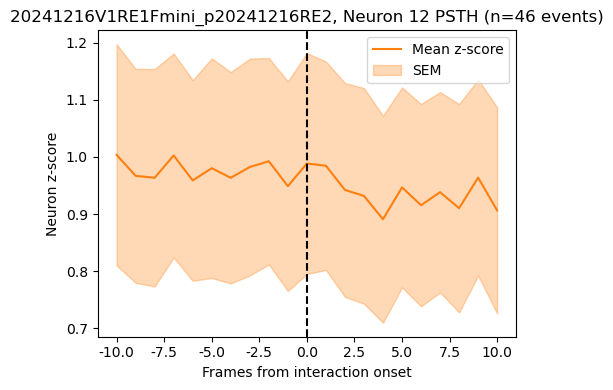

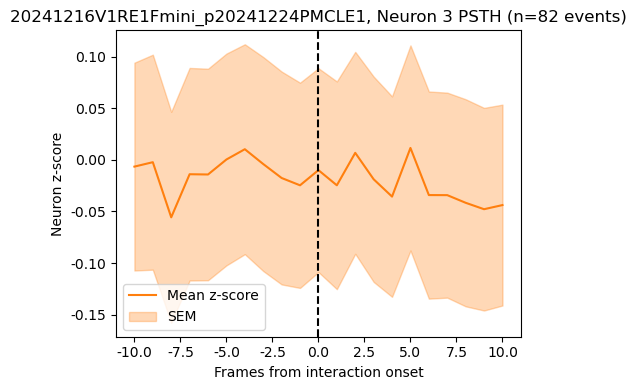

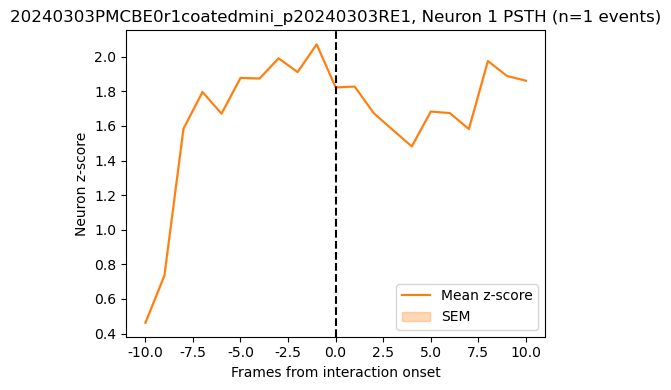

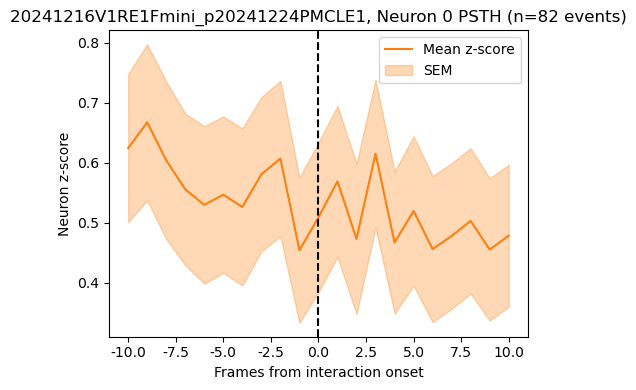

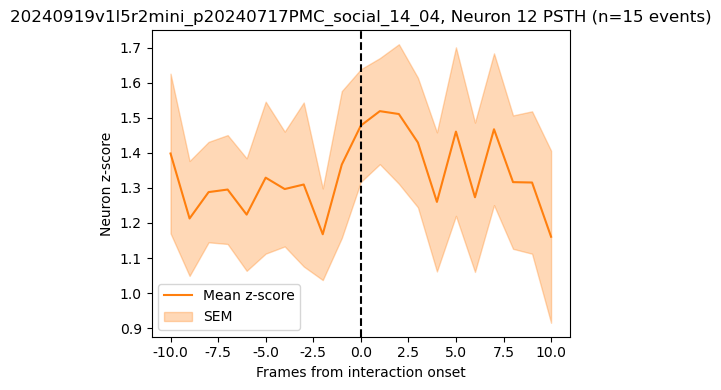

In [38]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from statsmodels.stats.multitest import multipletests

# ----------------------------------------------------------------------------
# 1. 用户需要自行修改：会话路径列表 & 排除字典路径 & COM距离阈值
# ----------------------------------------------------------------------------
social_sessions = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_p20240717PMC_social_test_11_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_02_27/20241015PMCBE1mini_p20241015PMCRE1_12_33",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_p20240717PMC_social_14_04",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240910V1r_AO_single_12_50",
    # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241216RE2",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20241216V1RE1Fmini_p20241224PMCLE1",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2025_05_16/20240303PMCBE0r1coatedmini_p20240303RE1"
]

single_sessions = [
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_37",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r1_16_53",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_14_30",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_14/20240916v1r2_15_58",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_18/20240919v1l5r1mini_11_21",
    "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_12_31/20240919v1l5r2mini_13_54"
]

all_sessions = social_sessions + single_sessions

# COM 距离阈值 (单位与 df_new 列中一致，一般是以 mm 为单位)
threshold = 250.0

# 排除字典 JSON 路径，请根据你自己环境调整
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'

# ----------------------------------------------------------------------------
# 2. 加载排除字典
# ----------------------------------------------------------------------------
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    如果会话路径在 exclude_dict 中，则返回要排除的 ROI 索引列表；
    否则尝试匹配 key 是否包含在 session_path 里，找不到就返回空列表。
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

# ----------------------------------------------------------------------------
# 3. 加载 HDF5 并附加元数据
# ----------------------------------------------------------------------------
def load_session_data(rec_path):
    """
    加载 rec_path 下的 MIR_Aligned 目录里第一个 '*aligned_predictions_with_ca_and_dF_F*.h5' 文件，
    读取 key='df' 返回 DataFrame，并附加一系列列：
      - session_id, recording_date, experiment, session_path, file_path
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 4. 处理神经元活动：剔除 + z-score
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    - 如果索引名是 'timestamp_ms_mini'，则 reset_index；
    - 根据 exclude_dict → 排除 ROI 列；
    - 保留方差前 95% 的 neuron，z-score 标准化；
    返回：
      pop_rate: shape=(n_frames,) 的 numpy 数组
      normalized: shape=(n_kept_neurons, n_frames) 的 numpy 数组
      df_reset: 重置索引后的 DataFrame
      filtered_cols: 保留下来的 neuron 列名字列表
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, np.empty((0, len(df))), df.reset_index(), []
    activity = df[neuron_cols].values.T  # (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh_var = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh_var
    filtered = activity[keep, :]  # (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    filtered_cols = [neuron_cols[i] for i in range(len(neuron_cols)) if keep[i]]
    return pop_rate, normalized, df.reset_index(), filtered_cols

# ----------------------------------------------------------------------------
# 5. 计算社交会话的 COM 距离
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    对于社交会话，找到所有形如 'comX_x', 'comX_y', 'comX_z' 的前缀，
    取前两个（p1, p2），计算它们三维坐标差值的欧氏距离，
    返回长度 = n_frames 的 numpy 数组 dist_raw。
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("Need ≥2 'com' prefixes for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 6. 收集所有会话，返回 pop_rate 三个组 & 社交 onsets & neuron_data 字典
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    遍历 session_paths 中的每条会话：
      - 加载 DataFrame，调用 process_neuron_activity 得到 pop_rate, normalized, df_reset, neuron_cols
      - 如果是社交会话 (≥2 个 'comX_x' 前缀)：计算 dist_raw，分出 pop_sint/pop_snon，
        并记录“non → int”转折点索引到 social_onsets_dict[rec_path]
      - 如果是单鼠会话 (只有 'com_x','com_y','com_z')：全部帧都加入 pop_single
      - 将 (normalized, neuron_cols) 存到 neuron_data_dict[rec_path]
    返回：
      pop_single, pop_snon, pop_sint, social_onsets_dict, neuron_data_dict
    """
    pop_single = []
    pop_snon = []
    pop_sint = []
    social_onsets_dict = {}
    neuron_data_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()

        pop_rate, normalized, df_reset, neuron_cols = process_neuron_activity(df, exclude_mapping)
        neuron_data_dict[rec_path] = (normalized, neuron_cols)

        # 判断是否社交会话：至少有 2 个 "comX_x" 前缀
        com_prefixes = sorted({col.split('_')[0] for col in df_reset.columns if col.startswith('com') and '_' in col})
        if len(com_prefixes) >= 2:
            try:
                dist_raw = compute_com_distance_raw(df_reset)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_sint += pop_rate[dist_raw <= threshold].tolist()
            pop_snon += pop_rate[dist_raw > threshold].tolist()
            labels_dist = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels_dist[:-1] == 'non') & (labels_dist[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        # 判断是否单鼠会话：含 'com_x','com_y','com_z' 但上面不满足 ≥2 前缀
        elif 'com_x' in df_reset.columns and 'com_y' in df_reset.columns and 'com_z' in df_reset.columns:
            pop_single += pop_rate.tolist()

        else:
            # 既不满足社交 (≥2 comX)，也不满足单鼠 (com_x,y,z)，则跳过
            print(f"  Skipping: neither social nor single")
            continue

    return pop_single, pop_snon, pop_sint, social_onsets_dict, neuron_data_dict

# --------------------------------------------------------------
# 7. 运行 collect_groups，构建字典
# --------------------------------------------------------------
pop_single, pop_snon, pop_sint, social_onsets_dict, neuron_data_dict = collect_groups(all_sessions, threshold)

# ----------------------------------------------------------------------------
# 8. 加载三张 CSV 并筛选显著 + 效应量大的 neuron
# ----------------------------------------------------------------------------
df_corr = pd.read_csv("per_neuron_distance_correlation.csv")
df_auc = pd.read_csv("per_neuron_auc.csv")
df_glm = pd.read_csv("per_neuron_glm.csv")

# 8.1 distance_corr: 要求 signif=True 且 |pearson_r| ≥ 0.3
df_corr_sig = df_corr[(df_corr['signif'] == True) & (df_corr['pearson_r'].abs() >= 0.3)]
set_corr = set(zip(df_corr_sig['session_path'], df_corr_sig['neuron']))

# 8.2 AUC: 要求 signif=True 且 AUC ≥ 0.7
df_auc_sig = df_auc[(df_auc['signif'] == True) & (df_auc['AUC'] >= 0.7)]
set_auc = set(zip(df_auc_sig['session_path'], df_auc_sig['neuron']))

# 8.3 GLM: 要求 signif=True 且 |beta1| ≥ 0.3
df_glm_sig = df_glm[(df_glm['signif'] == True) & (df_glm['beta1'].abs() >= 0.3)]
set_glm = set(zip(df_glm_sig['session_path'], df_glm_sig['neuron']))

# 8.4 三者取交集，得到“同时满足所有条件”的 (session_path, neuron_index)
set_intersection = set_corr & set_auc & set_glm
print(f"\nNeurons passing all three criteria: {len(set_intersection)}")
for sess, neu in set_intersection:
    print(f"  Session: {sess}, Neuron index: {neu}")

# ----------------------------------------------------------------------------
# 9. 定义函数：给定单个 neuron 及其会话的所有 onsets，计算 ±window 帧的 PSTH
# ----------------------------------------------------------------------------
def compute_psth_for_neuron(normalized_matrix, onsets, neuron_idx, window_frames=10):
    """
    normalized_matrix: (n_neurons, n_frames) array
    onsets: list of interaction onset frame indices
    neuron_idx: 行索引，表示要绘制的 neuron 在 normalized_matrix 中的行
    window_frames: 向前向后各取多少帧 (默认为 10)

    返回：
      mean_trace: shape=(2*window_frames+1,) 的 numpy 数组
      sem_trace:  shape=(2*window_frames+1,) 的 numpy 数组
      event_count: 成功包含完整窗口的事件数量
    """
    snippets = []
    n_neurons, n_frames = normalized_matrix.shape
    for onset in onsets:
        start = onset - window_frames
        end = onset + window_frames
        if start < 0 or end >= n_frames:
            continue
        snippet = normalized_matrix[neuron_idx, start:end+1]
        snippets.append(snippet)
    if not snippets:
        return None, None, 0
    arr = np.vstack(snippets)  # shape = (n_events, 2*window_frames+1)
    mean_trace = np.nanmean(arr, axis=0)
    sem_trace = np.nanstd(arr, axis=0) / np.sqrt(arr.shape[0])
    return mean_trace, sem_trace, arr.shape[0]

# ----------------------------------------------------------------------------
# 10. 对每个满足交集条件的 neuron，绘制其 PSTH
# ----------------------------------------------------------------------------
window = 10  # ±10 帧

for sess_path, neu_idx in set_intersection:
    normalized, neuron_cols = neuron_data_dict[sess_path]
    if normalized.size == 0:
        continue

    n_neurons, n_frames = normalized.shape
    if neu_idx < 0 or neu_idx >= n_neurons:
        continue

    onsets = social_onsets_dict.get(sess_path, [])
    if not onsets:
        continue

    mean_trace, sem_trace, event_count = compute_psth_for_neuron(normalized, onsets, neu_idx, window_frames=window)
    if event_count == 0:
        continue

    x_axis = np.arange(-window, window+1)
    plt.figure(figsize=(5, 4))
    plt.plot(x_axis, mean_trace, color='C1', label='Mean z‐score')
    plt.fill_between(x_axis, mean_trace - sem_trace, mean_trace + sem_trace, color='C1', alpha=0.3, label='SEM')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Neuron z‐score")
    sess_name = os.path.basename(os.path.normpath(sess_path))
    plt.title(f"{sess_name}, Neuron {neu_idx} PSTH (n={event_count} events)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [19]:
import matplotlib

# Force Matplotlib to use a known, installed sans‐serif
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
matplotlib.rcParams['font.family'] = 'sans-serif'

# (Optional) If you ever imported Chinese fonts before, you can clear Matplotlib’s font cache:
# from matplotlib import font_manager
# font_manager._rebuild()


Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/
Processing session: /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/

Samples: single = 17808, social_non = 17417, social_int = 491



/tmp/ipykernel_919466/1675556605.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)


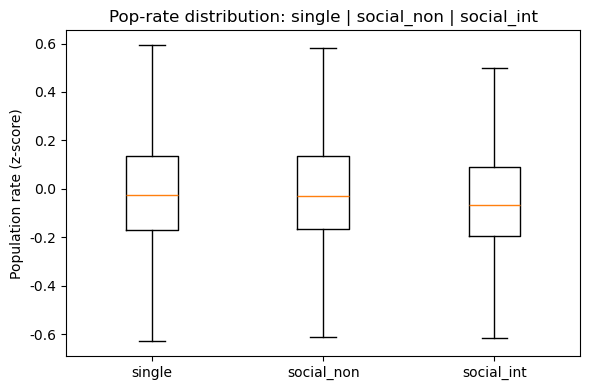

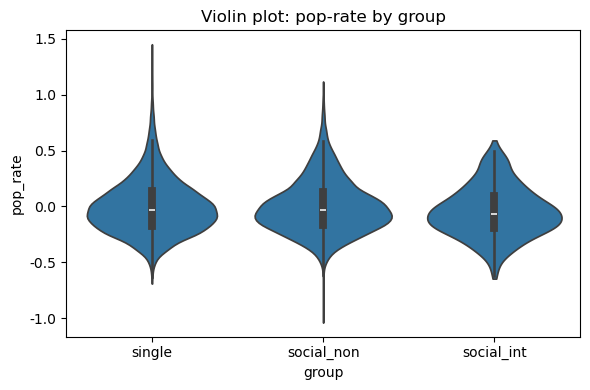

Kruskal–Wallis H = 14.068, p = 8.813e-04
  single vs social_non → U = 154445805.0, p = 5.056e-01
  single vs social_int → U = 4784629.0, p = 3.509e-04
  social_non vs social_int → U = 4700530.0, p = 1.706e-04

Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/:


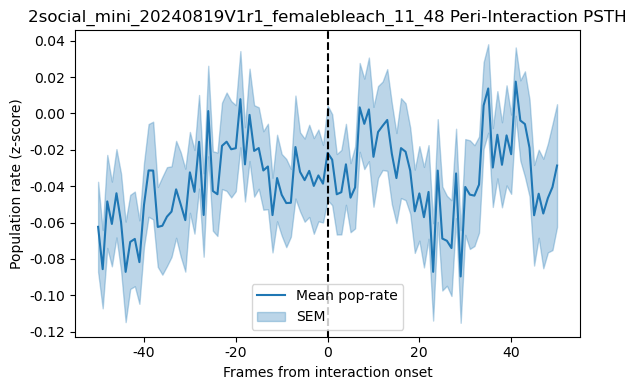


Peri-Event PSTH for /data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/:


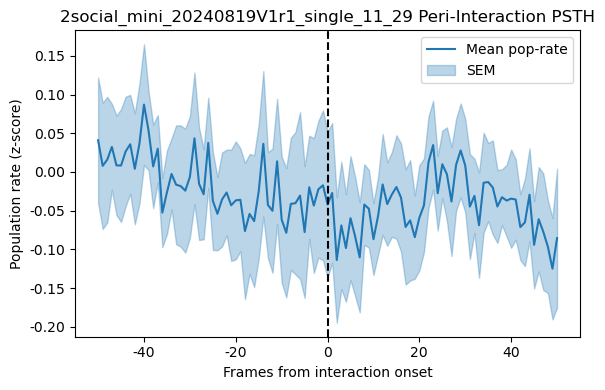


Analysis complete.


In [21]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from scipy.stats import zscore

# ----------------------------------------------------------------------------
# 1. Exclusion dictionary & HDF5 loading functions
# ----------------------------------------------------------------------------
exclude_json_path = '/home/lq53/mir_repos/BBOP/random_tests/25feb_more_corr_explo/neuro_exclude.json'
with open(exclude_json_path, 'r') as f:
    exclude_mapping = json.load(f)

def get_excluded_neurons_for_session(session_path, exclude_dict):
    """
    If the session_path is in the exclusion dictionary, return the list of neuron indices to exclude.
    Otherwise, return an empty list.
    """
    if not isinstance(exclude_dict, dict):
        return []
    if session_path in exclude_dict:
        return exclude_dict[session_path]
    for key, val in exclude_dict.items():
        if key in session_path:
            return val
    return []

def load_session_data(rec_path):
    """
    Load the first matching .h5 file under rec_path/MIR_Aligned, return it as a DataFrame,
    and add extra columns: session_id, recording_date, experiment, session_path, and file_path.
    """
    h5_dir = os.path.join(rec_path, 'MIR_Aligned')
    pattern = '*aligned_predictions_with_ca_and_dF_F*.h5'
    h5_files = glob.glob(os.path.join(h5_dir, pattern))
    if not h5_files:
        raise FileNotFoundError(f"No .h5 found in {h5_dir}")
    df = pd.read_hdf(h5_files[0], key='df')
    norm_path = os.path.normpath(rec_path)
    df['session_id']     = os.path.basename(norm_path)
    df['recording_date'] = os.path.basename(os.path.dirname(norm_path))
    df['experiment']     = os.path.basename(os.path.dirname(os.path.dirname(norm_path)))
    df['session_path']   = rec_path
    df['file_path']      = h5_files[0]
    return df

# ----------------------------------------------------------------------------
# 2. Process neuron activity and compute population rate
# ----------------------------------------------------------------------------
def process_neuron_activity(df, exclude_dict):
    """
    Exclude and z-score normalize all 'dF_F_roi*' columns in the DataFrame.
    Return pop_rate (mean across normalized neurons per frame) and the DataFrame with its index reset.
    """
    if df.index.name == 'timestamp_ms_mini':
        df = df.reset_index()
    session_path = df['session_path'].iloc[0]
    excluded = get_excluded_neurons_for_session(session_path, exclude_dict)
    exclude_cols = {f'dF_F_roi{i}' for i in excluded}
    neuron_cols = [c for c in df.columns if c.startswith('dF_F_roi') and c not in exclude_cols]
    if not neuron_cols:
        pop_rate = np.zeros(len(df))
        return pop_rate, df.reset_index()

    activity = df[neuron_cols].values.T  # shape: (n_neurons, n_frames)
    variances = np.var(activity, axis=1)
    thresh = np.percentile(variances, 5) if variances.size else 0
    keep = variances > thresh
    filtered = activity[keep, :]  # shape: (n_kept_neurons, n_frames)
    normalized = zscore(filtered, axis=1, nan_policy='omit') if filtered.size else filtered
    pop_rate = normalized.mean(axis=0) if normalized.size else np.zeros(len(df))
    return pop_rate, df.reset_index()

# ----------------------------------------------------------------------------
# 3a. Compute raw COM distance for social sessions (multi-prefix version)
# ----------------------------------------------------------------------------
def compute_com_distance_raw(df_new):
    """
    Find all prefixes of the form 'com<idx>_x' in df_new.columns (e.g., com0, com1, com2).
    Use the first two prefixes (p1, p2) to compute Euclidean distance between (p1_x, p1_y, p1_z)
    and (p2_x, p2_y, p2_z) for each frame.
    """
    prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
    if len(prefixes) < 2:
        raise ValueError("At least two 'com' prefixes (e.g., com0_x, com1_x) are required for social session.")
    p1, p2 = prefixes[0], prefixes[1]
    dx = df_new[f'{p1}_x'] - df_new[f'{p2}_x']
    dy = df_new[f'{p1}_y'] - df_new[f'{p2}_y']
    dz = df_new[f'{p1}_z'] - df_new[f'{p2}_z']
    return np.sqrt(dx.values**2 + dy.values**2 + dz.values**2)

# ----------------------------------------------------------------------------
# 3b. Compute COM speed for single sessions (single-prefix version)
# ----------------------------------------------------------------------------
def compute_com_speed(df_new):
    """
    For single sessions, find columns 'com_x', 'com_y', 'com_z' and compute per-frame displacement magnitude.
    The first frame's displacement is set to 0.
    """
    if not all(k in df_new.columns for k in ['com_x','com_y','com_z']):
        raise ValueError("Single session must contain 'com_x', 'com_y', and 'com_z' columns.")
    x = df_new['com_x'].values
    y = df_new['com_y'].values
    z = df_new['com_z'].values
    dx = np.diff(x, prepend=x[0])
    dy = np.diff(y, prepend=y[0])
    dz = np.diff(z, prepend=z[0])
    return np.sqrt(dx**2 + dy**2 + dz**2)

# ----------------------------------------------------------------------------
# 4. Process and aggregate "social" vs "single" sessions
# ----------------------------------------------------------------------------
def collect_groups(session_paths, threshold=250.0):
    """
    Given a list of session_paths, automatically determine for each whether it is social or single,
    collect pop_rate into:
      - all_pop_single
      - all_pop_social_int (interaction frames)
      - all_pop_social_non (non-interaction frames)
    Return these three lists plus a dictionary of social event onsets for each social session.
    """
    all_pop_single     = []
    all_pop_social_int = []
    all_pop_social_non = []
    social_onsets_dict = {}

    for rec_path in session_paths:
        print(f"Processing session: {rec_path}")
        try:
            df = load_session_data(rec_path)
        except FileNotFoundError as e:
            print(f"  Skipping: {e}")
            continue

        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate, df_new = process_neuron_activity(df, exclude_mapping)

        # Detect 'com' prefixes
        com_prefixes = sorted({col.split('_')[0] for col in df_new.columns if col.startswith('com') and '_' in col})
        # If at least two prefixes → social; if 'com_x' exists → single; else skip
        if len(com_prefixes) >= 2:
            # --- Social session
            try:
                dist_raw = compute_com_distance_raw(df_new)
            except ValueError as e:
                print(f"  Skipping (social): {e}")
                continue
            pop_int = pop_rate[dist_raw <= threshold].tolist()
            pop_non = pop_rate[dist_raw > threshold].tolist()
            all_pop_social_int += pop_int
            all_pop_social_non += pop_non

            # Record indices where non-interaction → interaction transitions occur
            labels = np.where(dist_raw <= threshold, 'int', 'non')
            onsets = np.where((labels[:-1] == 'non') & (labels[1:] == 'int'))[0] + 1
            social_onsets_dict[rec_path] = onsets.tolist()

        elif 'com_x' in df_new.columns and 'com_y' in df_new.columns and 'com_z' in df_new.columns:
            # --- Single session
            try:
                _ = compute_com_speed(df_new)
            except ValueError as e:
                print(f"  Skipping (single): {e}")
                continue
            all_pop_single += pop_rate.tolist()

        else:
            print(f"  Skipping: missing 'com' columns → neither social nor single")
            continue

    return all_pop_single, all_pop_social_int, all_pop_social_non, social_onsets_dict

# ----------------------------------------------------------------------------
# 5. Statistical tests & visualization: boxplot + violin + Kruskal–Wallis + Mann–Whitney U
# ----------------------------------------------------------------------------
def plot_three_group_distributions(pop_single, pop_sint, pop_snon):
    """
    Plot the distributions of pop_rate for three groups:
      - single
      - social_non
      - social_int
    Perform Kruskal–Wallis test (if all groups are non-empty) and pairwise Mann–Whitney U tests.
    """
    data = [pop_single, pop_snon, pop_sint]
    labels = ['single', 'social_non', 'social_int']

    # Filter out empty groups
    nonempty_data = [grp for grp in data if len(grp) > 0]
    nonempty_labels = [labels[i] for i in range(3) if len(data[i]) > 0]

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(nonempty_data, labels=nonempty_labels, showfliers=False)
    plt.ylabel("Population rate (z-score)")
    plt.title("Pop-rate distribution: single | social_non | social_int")
    plt.tight_layout()
    plt.show()

    # Violin plot (if seaborn is installed)
    try:
        import seaborn as sns
        df_violin = pd.DataFrame({
            'pop_rate': np.hstack(data),
            'group': np.repeat(labels, [len(pop_single), len(pop_snon), len(pop_sint)])
        })
        df_violin = df_violin[df_violin['group'].isin(nonempty_labels)]
        plt.figure(figsize=(6, 4))
        sns.violinplot(x='group', y='pop_rate', data=df_violin, cut=0)
        plt.title("Violin plot: pop-rate by group")
        plt.tight_layout()
        plt.show()
    except ImportError:
        pass

    # Kruskal–Wallis (requires all three groups to be non-empty)
    if all(len(grp) > 0 for grp in data):
        h_stat, p_kw = kruskal(pop_single, pop_snon, pop_sint)
        print(f"Kruskal–Wallis H = {h_stat:.3f}, p = {p_kw:.3e}")
    else:
        print("Cannot perform Kruskal–Wallis: at least one group is empty.")

    # Pairwise Mann–Whitney U tests
    pairs = [
        ('single', pop_single, 'social_non', pop_snon),
        ('single', pop_single, 'social_int', pop_sint),
        ('social_non', pop_snon, 'social_int', pop_sint)
    ]
    for a_name, a_data, b_name, b_data in pairs:
        if len(a_data) > 0 and len(b_data) > 0:
            u_stat, p_u = mannwhitneyu(a_data, b_data, alternative='two-sided')
            print(f"  {a_name} vs {b_name} → U = {u_stat:.1f}, p = {p_u:.3e}")
        else:
            print(f"  Skipping {a_name} vs {b_name}: at least one group is empty.")

# ----------------------------------------------------------------------------
# 6. Optional: Plot Peri-Event PSTH for social interaction onsets
# ----------------------------------------------------------------------------
def plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50):
    """
    For the given social session, around each interaction onset, plot the peri-event PSTH
    of pop_rate for t_window_frames before and after the event.
    """
    if not onsets:
        print(f"{rec_path} → No interaction onsets found.")
        return

    snippets = []
    for idx in onsets:
        start = idx - t_window_frames
        end   = idx + t_window_frames
        if start < 0 or end >= len(pop_rate_full):
            continue
        snippet = pop_rate_full[start:end+1]
        snippets.append(snippet)

    if not snippets:
        print(f"{rec_path} → No complete peri-event windows available.")
        return

    snippets = np.vstack(snippets)
    mean_trace = np.nanmean(snippets, axis=0)
    sem_trace  = np.nanstd(snippets, axis=0) / np.sqrt(snippets.shape[0])

    x_axis = np.arange(-t_window_frames, t_window_frames+1)
    plt.figure(figsize=(6, 4))
    plt.plot(x_axis, mean_trace, color='C0', label='Mean pop-rate')
    plt.fill_between(
        x_axis,
        mean_trace - sem_trace,
        mean_trace + sem_trace,
        color='C0', alpha=0.3, label='SEM'
    )
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Frames from interaction onset")
    plt.ylabel("Population rate (z-score)")
    session_name = os.path.basename(os.path.normpath(rec_path))
    plt.title(f"{session_name} Peri-Interaction PSTH")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------
# 7. Example execution
# ----------------------------------------------------------------------------
if __name__ == '__main__':
    # Gather all session paths into a list
    session_paths = [
        # Social sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_femalebleach_11_48/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_31/2social_mini_20240819V1r1_single_11_29/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/2social_mini_20240819V1r1_AO_single_14_30/",
        # Single sessions
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_13_41/",
        "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_10_17/20240819V1r1_14_25/",
        # "/data/big_rim/rsync_dcc_sum/Oct3V1/2024_11_01/20240819V1r1_AO_14_56/"
    ]

    threshold = 250.0  # COM distance threshold for social sessions

    # Collect three groups of pop_rate and social event onsets
    pop_single, pop_sint, pop_snon, social_onsets_dict = collect_groups(session_paths, threshold)

    print(f"\nSamples: single = {len(pop_single)}, social_non = {len(pop_snon)}, social_int = {len(pop_sint)}\n")

    # Statistical tests and visualization for the three groups
    plot_three_group_distributions(pop_single, pop_sint, pop_snon)

    # Optional: Plot Peri-Event PSTH for each social session
    for rec_path, onsets in social_onsets_dict.items():
        df = load_session_data(rec_path)
        if df.index.name == 'timestamp_ms_mini':
            df = df.reset_index()
        pop_rate_full, _ = process_neuron_activity(df, exclude_mapping)
        print(f"\nPeri-Event PSTH for {rec_path}:")
        plot_peri_event_population(rec_path, onsets, pop_rate_full, t_window_frames=50)

    print("\nAnalysis complete.")
